In [1]:
import os
import numpy as np
import itertools
import time
import random
from collections import OrderedDict, Counter, defaultdict
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

import copy
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import random_split

import math
import json
from typing import Callable, Iterable, Tuple
from torch.optim import Optimizer
from torch.utils.data import WeightedRandomSampler

import wandb
wandb.login()
from pytorch_lightning.loggers import WandbLogger

import collections

wandb: Currently logged in as: chucooleg (use `wandb login --relogin` to force relogin)


## Data -- Generation

In [2]:
def generate_cards(attributes, attr_order, num_attributes, num_attr_vals):
    
    attr_order = attr_order[:num_attributes]
    attributes = {att_k:attributes[att_k][:num_attr_vals] for att_k in attributes if att_k in attr_order}
    
    cards = []
    idx_to_card = {}
    card_to_idx = {}

    i = 0
    attr_vals = [attributes[attr] for attr in attr_order]
    for combo in itertools.product(*attr_vals):
        card = tuple(combo)
        cards.append(card)
        card_to_idx[card] = i
        idx_to_card[i] = card
        i += 1
    
    assert len(cards) == len(set(cards))
    print(f'Generated {len(cards)} unqiue cards')                
    return cards, idx_to_card, card_to_idx


def num_shared_attributes(card1, card2):
    matching_concepts = tuple(s1 if s1==s2 else '-' for s1,s2 in zip(card1,card2))
    num_matching_concepts = len([c for c in matching_concepts if c != '-'])
    return matching_concepts, num_matching_concepts


def generate_card_pairs(cards, card_to_idx):
    '''
    find all combos of cards, filter down to the ones that share concepts.
    '''
    cardpairs_with_shared_concepts = []
    cardpairs_without_shared_concepts = []

    cardpair_to_idx, idx_to_cardpair, idx = {}, {}, 0
    num_matching_concepts_all = {}
    for card1, card2 in itertools.combinations(cards,2):
        if card1 != card2:
            matching_concepts, num_matching_concepts = num_shared_attributes(card1, card2)
            num_matching_concepts_all[(card1, card2)] = num_matching_concepts
            if num_matching_concepts:
                cardpairs_with_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            else:
                cardpairs_without_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            idx_to_cardpair[idx] = (card_to_idx[card1], card_to_idx[card2])
            cardpair_to_idx[(card_to_idx[card1], card_to_idx[card2])] = idx
            idx += 1
    print(f'Generated {len(cardpairs_with_shared_concepts) + len(cardpairs_without_shared_concepts)} cardpairs')
    print(f'-- {len(cardpairs_with_shared_concepts)} cardpairs with shared concept')
    print(f'-- {len(cardpairs_without_shared_concepts)} cardpairs without shared concept')
    print(Counter(num_matching_concepts_all.values()).most_common())
    return cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair


def match_concept_to_card(concept, card):
    '''
    Given a concept, determine if card matches.
    
    Arguments:
        concept: ('red', 'void', '-', '-')
        card: ex1. ('red', 'void', 'triangle', 'XOX')
              ex2. ('green', 'void', 'square', 'OXX')
    Returns:
        match: bool. ex1. True,
                     ex2. False
    '''
    match = 0
    for ct, cd in zip(concept, card):
        # As long as one concept matches, it is a match!
        if ct == cd:
            match += 1
    return match


def default_to_regular(d):
    if isinstance(d, defaultdict):
        d = {k: default_to_regular(v) for k, v in d.items()}
    return d

def gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=100, debug=False):
    
    # all cards
    cards, idx_to_card, card_to_idx = generate_cards(attributes, attr_order, num_attributes, num_attr_vals)
    # all card pairs
    cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair = \
        generate_card_pairs(cards, card_to_idx)
    
    # generate answers
    all_matches = []
    number_of_shared_concepts_per_match = []
    cardpair_to_matches = defaultdict(lambda : defaultdict(int))
#     for cardpair in cardpairs_with_shared_concepts + cardpairs_without_shared_concepts: # NOTE!!
    for cardpair in cardpairs_with_shared_concepts:
        shared_concept = cardpair[1]
        # look for all matching cards
        # ((card pair query), matching card)
        for card in cards:
            num_matched_concepts = match_concept_to_card(shared_concept, card)
            if num_matched_concepts:
                all_matches.append((cardpair_to_idx[cardpair[0]], card_to_idx[card]))
                cardpair_to_matches[cardpair_to_idx[cardpair[0]]][card_to_idx[card]] = num_matched_concepts
                number_of_shared_concepts_per_match.append(num_matched_concepts)
    cardpair_to_matches = default_to_regular(cardpair_to_matches)
    print('Total number of matches = ', len(all_matches))
    print('Number of shared concepts per match = ', Counter(number_of_shared_concepts_per_match).most_common())
    
    # hold out some cardpairs
    unseen_cardpair_indices = list(np.random.choice(len(cardpair_to_idx), size=num_unseen_cardpairs, replace=False))
    train_cardpair_indices = [idx for idx in range(len(cardpair_to_idx)) if idx not in unseen_cardpair_indices]
    assert len(set(unseen_cardpair_indices) | set(train_cardpair_indices)) == len(cardpair_to_idx)
    
    data = {
        'idx_to_key': idx_to_card,
        'key_to_idx': card_to_idx,
        'query_to_idx': cardpair_to_idx, 
        'idx_to_query': idx_to_cardpair,
        'all_matches': all_matches, # list of tuples (query idx, answer card)
        'query_to_keys': cardpair_to_matches, # lookup query idx:{'card1':num matched concepts, 'card2':num matched concepts,...}
        'unseen_query_indices': unseen_cardpair_indices,
        'seen_query_indices': train_cardpair_indices
    }
    return data


attributes = {
    'color': ['red', 'green', 'blue', 'orange', 'cyan', 'magenta', 'black', 'yellow'],
    'fill': ['void', 'dashed', 'solid', 'checkered', 'dotted', 'mosaic', 'noise', 'brushed'],
    'shape': ['square', 'circle', 'triangle', 'star', 'hexagon', 'pentagon', 'ellipse', 'rectangle'],
    'config': ['OOO', 'OOX', 'OXO', 'OXX', 'XOO', 'XOX', 'XXO', 'XXX']
}

attr_order = ['color', 'fill', 'shape', 'config']

num_attributes = 2
num_attr_vals = 6
game_data = gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)

Generated 36 unqiue cards
Generated 630 cardpairs
-- 180 cardpairs with shared concept
-- 450 cardpairs without shared concept
[(0, 450), (1, 180)]
Total number of matches =  1080
Number of shared concepts per match =  [(1, 1080)]


## Data -- Distribution, Splits

In [3]:
distribution_epsilon = 1e-100

count_table = np.zeros((len(game_data['idx_to_key']), len(game_data['idx_to_query'])))
        
for q, k in game_data['all_matches']:
    count_table[k, q] += 1    
        
xy = count_table/np.sum(count_table)
xy += distribution_epsilon
xy /= np.sum(xy)

x = np.sum(xy,0)
y = np.sum(xy,1)
xyind = y[None].T @ x[None]

In [4]:
# + 0.1
[(0.0029940119760479044, 270), (0.003548458638278998, 54)]
# + nothing
Counter(list(xy.reshape(-1))).most_common()

[(1e-100, 21600), (0.000925925925925926, 1080)]

In [5]:
np.sum(count_table)

1080.0

In [6]:
xy_rank = np.linalg.matrix_rank(xy)
print('xy_rank=',xy_rank)

xy_div_xyind_rank = np.linalg.matrix_rank((xy/xyind))
print('xy_div_xyind_rank=',xy_div_xyind_rank)

xy_rank= 11
xy_div_xyind_rank= 11


In [7]:
figsize = (20,15)
# figrange = (fx_s, fx_e, fy_s, fy_e)
figrange = (0, len(game_data['idx_to_key']), 0, len(game_data['idx_to_query']))

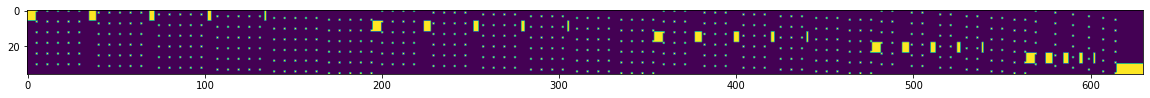

In [8]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

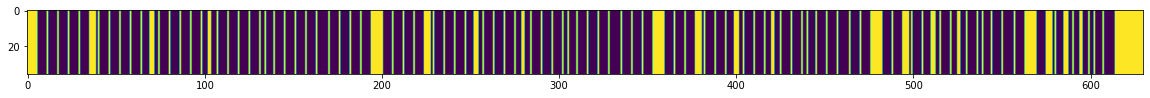

In [9]:
# all
plt.figure(figsize = figsize)
plt.imshow((xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

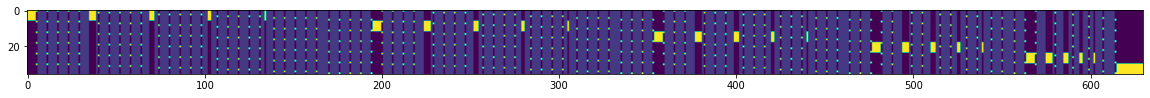

In [10]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

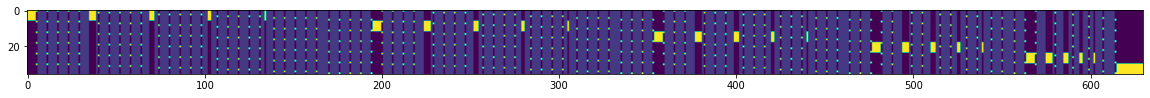

In [11]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [12]:
Counter(list((xy/xyind).reshape(-1))).most_common()

[(0.9999999999999991, 9450),
 (0.9999999999999989, 3600),
 (6.480000000000002e-97, 3150),
 (0.999999999999999, 3150),
 (6.48e-97, 1200),
 (6.480000000000001e-97, 1050),
 (6.000000000000002, 630),
 (5.999999999999999, 240),
 (6.0, 210)]

## Dataset

In [13]:
### One embed per query!

class GameDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return self.query_support_size * self.key_support_size
    
    def __getitem__(self, idx):
        '''
        key_idx: (xy_i) * (xy.shape[1]=self.query_support_size) + (xy_j)
        '''
        x_i, y_j = idx//self.query_support_size, idx%self.query_support_size
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0
        
        if self.debug:
            yj1, yj2 = self.raw_data['idx_to_query'][y_j]
            print('query\n', y_j,":", yj1, yj2, self.raw_data['idx_to_key'][yj1], self.raw_data['idx_to_key'][yj2])
            print('key\n', x_i, self.raw_data['idx_to_key'][x_i])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
        
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        )    

game_dataset = GameDataset(raw_data=game_data, debug=True)
game_dataset[10] 
print('-----')
game_dataset[7] # 7 has zero prob of being sampled

query
 10 : 0 11 ('red', 'void') ('green', 'mosaic')
key
 0 ('red', 'void')
all matches 
 []
-----
query
 7 : 0 8 ('red', 'void') ('green', 'solid')
key
 0 ('red', 'void')
all matches 
 []


(7,
 tensor([7]),
 tensor([0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [14]:
class GameTestFullDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        queries_with_shared_attr_only: bool.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return len(self.raw_data['idx_to_query'])
    
    def __getitem__(self, idx):
        '''
        key_idx: int. 0 to query_support_size-1
        '''
        y_j = idx
        x_i = torch.empty(1) # just a meaningless value
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0

        if self.debug:
            yj1, yj2 = self.raw_data['idx_to_query'][y_j]
            print('query\n', y_j,":", yj1, yj2, self.raw_data['idx_to_key'][yj1], self.raw_data['idx_to_key'][yj2])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
            
            
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        ) 
    
game_testdataset = GameTestFullDataset(raw_data=game_data, debug=True)
game_testdataset[10]
print('-----')
game_testdataset[7] # 7 has zero prob of being sampled

query
 10 : 0 11 ('red', 'void') ('green', 'mosaic')
all matches 
 []
-----
query
 7 : 0 8 ('red', 'void') ('green', 'solid')
all matches 
 []


(7,
 tensor([7]),
 tensor([0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [15]:
class GameDataModule(pl.LightningDataModule):
    
    def __init__(self, batch_size, raw_data, seen_train_xy, seen_val_xy, debug=False):
        super().__init__()
        self.batch_size = batch_size
        self.dataset = GameDataset(raw_data=raw_data, debug=debug)
#         self.testdataset = GameTestFullDataset(raw_data=raw_data, debug=debug)
        self.seen_train_xy = seen_train_xy
        self.seen_val_xy = seen_val_xy
        self.setup_samplers()
        
    def setup_samplers(self):
        self.train_sampler = WeightedRandomSampler(
            weights=self.seen_train_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        ) 
        self.val_sampler = WeightedRandomSampler(
            weights=self.seen_val_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        )
        
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train = self.dataset
            self.val = self.dataset
#         if stage == 'test' or stage is None:
#             self.test = self.testdataset
            
    def train_dataloader(self):
        train_loader = DataLoader(
            self.train, batch_size=self.batch_size, shuffle=False, sampler=self.train_sampler
        )
        return train_loader
    
    def val_dataloader(self):
        val_loader = DataLoader(
            self.val, batch_size=self.batch_size,  shuffle=False, sampler=self.val_sampler
        )
        return val_loader
    
#     def test_dataloader(self):
#         test_loader = DataLoader(
#             self.test, batch_size=self.batch_size, shuffle=False
#         )
#         return test_loader  

## Model Architecture

In [16]:
def construct_full_model(hparams):
    '''
    return: nn.Module.
    '''
    # embeddings
    query_embed_X = ScaledEmbedding(hparams['query_support_size'], hparams['d_model'])
    key_embed_X = ScaledEmbedding(hparams['key_support_size'], hparams['d_model'])
    embed_dropout = nn.Dropout(hparams['embed_dropout'])
    
    # full model
    model = EncoderPredictor(
        inp_query_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', query_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        inp_key_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', key_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        classifier = nn.Sequential(
            OrderedDict([   
                ('linear1', nn.Linear(2*hparams['d_model'], hparams['d_model'])),
                ('nonLinear1', nn.ReLU()),
                ('linear-out', nn.Linear(hparams['d_model'], 1)),
            ])
        ) if not hparams['dotproduct_bottleneck'] else None, 
        
        key_support_size = hparams['key_support_size'],
        d_model = hparams['d_model'],
        debug = hparams['debug'],
    )
    
    return model

In [17]:
class ScaledEmbedding(nn.Module):

    def __init__(self, V, d_model):
        super(ScaledEmbedding, self).__init__()
        self.embedding = nn.Embedding(V, d_model)
        # scale embedding to have variance 0.01
        nn.init.normal_(self.embedding.weight, mean=0., std=(0.01)**(1/2))
        self.d_model = d_model

    def forward(self, tokens):
        '''
        tokens: shape (batch_size=b, len)
        '''
        # shape (b, len, d_model)
        embedded = self.embedding(tokens) * math.sqrt(self.d_model)
        if torch.max(embedded) > 2000.:
            import pdb; pdb.set_trace()
        return embedded

In [18]:
class EncoderPredictor(nn.Module):
    
    def __init__(self, inp_query_layer, inp_key_layer, classifier, key_support_size, d_model, debug=False):
        super().__init__()
        self.inp_query_layer = inp_query_layer
        self.inp_key_layer = inp_key_layer
        self.classifier = classifier
        self.key_support_size = key_support_size
        self.d_model = d_model
        
    def forward(self, X_query, X_key, val_bool, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1) if test bool, else (b, num matched cards) or None.
        '''
        if X_key is not None: assert X_query.shape == X_key.shape
        if val_bool:
            return self.forward_norm_support(X_query, debug=debug)
        else:
            assert X_key is not None, 'X_key should not be None for normalizing over minibatch keys.'
            return self.forward_norm_minibatch(X_query, X_key, debug=debug)

    def forward_norm_minibatch(self, X_query, X_key, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)
        
        # shape(b, d_model)
        key_repr = self.encode_key(X_key).squeeze(1)
        assert key_repr.shape == (b, self.d_model)

        if self.classifier:
            raise ValueError('Not supposed to use classifier!')
            # shape(b, b, d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, b, self.d_model)
            # shape(b, b, d_model)
            key_repr_tiled = key_repr.unsqueeze(0).expand(b, b, self.d_model)
            # shape(b, b, 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            assert query_key_concat.shape == (b, b, 2*self.d_model)
            # shape(b*b, 2*d_model)
            query_key_concat = query_key_concat.reshape(b*b, 2*self.d_model)
            # shape(b*b, 1)
            logits = self.classifier(query_key_concat)
            assert logits.shape == (b*b, 1)
            # shape(b, b)
            logits = logits.squeeze(1).reshape(b, b)
        else:
            # shape(b, b) dotproduct=logit matrix
            logits = torch.matmul(query_repr, key_repr.T)
        assert logits.shape == (b, b)
        
        # shape(b, b)
        return logits

    def forward_norm_support(self, X_query, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)

        # shape(size(support), d_model)
        keys_repr = self.encode_all_keys()
        assert keys_repr.shape == (self.key_support_size, self.d_model)
        
        if self.classifier:
            # shape(b, size(support), d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), d_model)
            key_repr_tiled = keys_repr.unsqueeze(0).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            # shape(b*size(support), 2*d_model)
            query_key_concat = query_key_concat.reshape(b*self.key_support_size, 2*self.d_model)
            # shape(b*size(support), 1)
            logits = self.classifier(query_key_concat)
            # shape(b, size(support))
            logits = logits.squeeze(1).reshape(b, self.key_support_size)
        else:
            # shape(b, size(support)) dotproduct=logit matrix
            logits = torch.matmul(query_repr, keys_repr.T)
        assert logits.shape == (b, self.key_support_size)
        
        # shape(b, size(support)) 
        return logits

    def encode_query(self, X):
        '''
        X: (batch_size=b,1)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_query_layer(X)
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed     
        
    def encode_key(self, X):
        '''
        X: (batch_size=b)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_key_layer(X) 
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed  

    def encode_all_keys(self):
        
        # shape(size(support), embed_dim)
        all_embed = self.inp_key_layer.scaled_embed.embedding.weight
        assert all_embed.requires_grad == True
        assert all_embed.shape == (self.key_support_size, self.d_model)
        
        return all_embed

## Loss, Metric

In [19]:
class InfoCELoss(nn.Module):
    '''
    InfoCE Loss on a (b, b) logits matrix with Temperature scaling
    '''

    def __init__(self, temperature_const=1.0):
        super().__init__()
        self.temperature_const = temperature_const
        self.CE_loss = nn.CrossEntropyLoss(reduction='sum')

    def forward(self, logits, debug=False):
        '''
        logits: shape (batch_size=b, b)
        '''
        assert logits.shape[0] == logits.shape[1]
        b = logits.shape[0]
        
        logits /= self.temperature_const
        
        labels = torch.arange(b).type_as(logits).long()
        sum_loss_per_row = self.CE_loss(logits, labels)
        sum_loss_per_col = self.CE_loss(logits.T, labels)
        
        if debug:
            print('sum_loss_per_row=',sum_loss_per_row)
            print('sum_loss_per_col=',sum_loss_per_col)

        loss = (sum_loss_per_row + sum_loss_per_col) * 0.5
        return loss


# ---------------------------    
loss_criterion = InfoCELoss(temperature_const=0.1)

logits = torch.tensor([
    [1.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))
print('-------------')
logits = torch.tensor([
    [3.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))


# ref
# sum_loss_per_row= tensor(20.0001)
# sum_loss_per_col= tensor(60.0001)
# avg loss= tensor(40.0001)
# -------------
# sum_loss_per_row= tensor(0.6933)
# sum_loss_per_col= tensor(40.0001)
# avg loss= tensor(20.3467)

sum_loss_per_row= tensor(20.0001)
sum_loss_per_col= tensor(60.0001)
avg loss= tensor(40.0001)
-------------
sum_loss_per_row= tensor(0.6933)
sum_loss_per_col= tensor(40.0001)
avg loss= tensor(20.3467)


In [20]:
class ThresholdedMetrics(nn.Module):
    
    def __init__(self, raw_data):
        '''
        tot_k: total number of candidates. e.g. 81 cards
        '''
        super().__init__()
        self.raw_data = raw_data
        self.key_support_size = len(self.raw_data['idx_to_key'])
        self.threshold = 1.0 / (self.key_support_size)
        self.softmax = nn.Softmax(dim=1)

    def breakdown_errors(self, X_query, corrects):
        '''
        X_query: shape (b,1) (if one embed per query)
        corrects: shape (b, support size)
        '''
        b = X_query.shape[0]
        assert corrects.shape == (b, self.key_support_size)
        
        X_query_list = X_query.squeeze(-1)
        wrongs = (1 - corrects).cpu().numpy()
        
        num_matched_concepts = [
             self.raw_data['query_to_keys'].get(X_query_list[batch_i].item(), {}).get(card_idx, 0)
            for batch_i in range(b) for card_idx in range(self.key_support_size)  
        ]
        
        num_matched_concepts = np.array(num_matched_concepts).reshape(b, self.key_support_size)
        assert num_matched_concepts.shape == wrongs.shape
        
        wrongs_mask = wrongs.reshape(-1).tolist()
        num_matched_concepts = num_matched_concepts.reshape(-1).tolist()

        error_count_by_num_matched_concepts = {k:0 for k in range(num_attributes)}
        total_count_by_num_matched_concepts = {k:0 for k in range(num_attributes)}
        for w,k in zip(wrongs_mask, num_matched_concepts):
            if w == 1:
                error_count_by_num_matched_concepts[k] += 1
            total_count_by_num_matched_concepts[k] += 1    

        error_counts, total_counts = {}, {}
        for k in range(num_attributes):
            err_ct = error_count_by_num_matched_concepts[k]
            tot_ct = total_count_by_num_matched_concepts[k]
            error_counts[f'error_rate_for_{k}_matched_concepts'] = 0 if tot_ct == 0 else (err_ct *1.0 / tot_ct)
            total_counts[f'total_count_for_{k}_matched_concepts'] = tot_ct

        return {**error_counts, **total_counts}    
    
    def forward(self, X_query, logits, X_keys, full_test_bool=False, breakdown_errors_bool=False, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        b, key_support_size = logits.shape
        assert key_support_size == self.key_support_size
        assert logits.shape == X_keys.shape
        
        if full_test_bool:
            # filter down to query cards with >0 true matches
            queryIdxs_with_nonzero_matches = list(self.raw_data['query_to_keys'].keys())
            X_query_flat = X_query.squeeze(-1)
            fil = torch.stack([(X_query_flat == qId) for qId in queryIdxs_with_nonzero_matches], dim=1).any(dim=1)
            assert fil.shape == (b, )
            
            # queries with shared attributes
            fil_metrics = self.compute_metrics(X_query[fil], logits[fil], X_keys[fil], breakdown_errors_bool, debug)
            fil_metrics = {'nonNullQueries_'+k:fil_metrics[k] for k in fil_metrics}
            
            # queries without shared attributes
            not_fil = torch.logical_not(fil)
            not_fil_metrics = self.compute_metrics(X_query[not_fil], logits[not_fil], X_keys[not_fil], breakdown_errors_bool, debug)
            not_fil_metrics = {'NullQueries_'+k:not_fil_metrics[k] for k in not_fil_metrics}
            
            # all queries
            all_metrics = self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
            
            return {**fil_metrics, **not_fil_metrics, **all_metrics}
        else:
            return self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
    
    def compute_metrics(self, X_query, logits, X_keys, breakdown_errors_bool=False, debug=False):
        '''
        X_query: shape (b,1) (if one embed per query)
        logits: shape (b, support size)
        X_keys: shape (b, support size). value 1.0 at where card matches. value 0 otherwise.
        '''
        b, key_support_size = logits.shape
        
        # model predictions, shape (b, support size)
        binary_predictions = (self.softmax(logits) >= self.threshold).type(torch.float)
        # ground truth, shape (b, support size)
        gt = X_keys
        # correct predictions, shape (b, support size)
        corrects = (binary_predictions == gt).type(torch.float)
        
        # accuracy, computed per query, average across queries
        # (b,)
        accuracy_row = torch.sum(corrects, dim=1) / key_support_size
        # scalar
        accuracy_meanrows = torch.mean(accuracy_row)
        # accuracy, computed per query-key, average across all
        accuracy_all = torch.sum(corrects) / (b * key_support_size)
        
        # precision, computed per query, average across queries
        # (b,)
        precision_row = torch.sum((corrects * binary_predictions), dim=1) / torch.sum(binary_predictions, dim=1)
        # scalar
        precision_meanrows = torch.mean(precision_row)
        # precision, computed per query-key, average across all
        precision_all = torch.sum((corrects * binary_predictions)) / torch.sum(binary_predictions)

        # recall, computed per query, average across queries
        # (b,)
        recall_row = torch.sum((corrects * gt), dim=1) / torch.sum(gt, dim=1)
        # scalar
        recall_meanrows = torch.mean(recall_row)
        # recall, computed per query-key, average across all
        recall_all = torch.sum((corrects * gt)) / torch.sum(gt)
        
        # f1, computed per query, average across queries
        # (b,)
        f1_row = 2 * (precision_row * recall_row) / (precision_row + recall_row)
        # scalar
        f1_meanrows = torch.mean(f1_row)
        # f1, computed per query-key, average across all
        f1_all = (precision_all * recall_all) / (precision_all + recall_all)
        
        if breakdown_errors_bool:
            error_breakdown_by_num_matched_concepts = self.breakdown_errors(X_query, corrects)
        else:
            error_breakdown_by_num_matched_concepts = {} 
            
        if debug:
            print('####################################################')
            print('Metrics Per Query:')
            print('accuracy_rows', accuracy_row)
            print('precision_row', precision_row)
            print('recall_row', recall_row)
            print('f1_row', f1_row)
            print('####################################################')
            print('Metrics Averaged Across Queries')
            print('accuracy_meanrows', accuracy_meanrows)
            print('precision_meanrows', precision_meanrows)
            print('recall_meanrows', recall_meanrows)
            print('f1_meanrows', f1_meanrows)
            print('####################################################')
            print('Metrics Averaged Across All Query-Key Pairs:')
            print('accuracy_all', accuracy_all)
            print('precision_all', precision_all)
            print('recall_all', recall_all)
            print('f1_all', f1_all)
            print('####################################################')
            print('error_breakdown', error_breakdown_by_num_matched_concepts)
            
        metrics = {
            'accuracy_by_Query': accuracy_meanrows,
            'precision_by_Query': precision_meanrows,
            'recall_by_Query': recall_meanrows,
            'f1_by_Query': f1_meanrows,
            'accuracy_by_QueryKey': accuracy_all,
            'precision_by_QueryKey': precision_all,
            'recall_by_QueryKey': recall_all,
            'f1_by_QueryKey': f1_all
        }
        metrics = {
            **metrics, **error_breakdown_by_num_matched_concepts
        }
        return metrics


def test_metric_module():
    key_support_size=3
    thresh=1./key_support_size

    m_f = ThresholdedMetrics(raw_data=game_data)
    m_f.key_support_size = 3

    logits = torch.tensor(
        [
            [thresh, thresh, thresh],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    print('----------------------------------------------')
    
    logits = torch.tensor(
        [
            [0.4, 0.2, 0.4],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    
    
# test_metric_module()

# reference output
# accuracy_row tensor([0.3333, 0.3333, 1.0000])
# precision_row tensor([0.3333, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.5000, 0.5000, 1.0000])
# {'accuracy': tensor(0.5556), 'precision': tensor(0.5556), 'recall': tensor(1.), 'f1': tensor(0.6667)}
# ----------------------------------------------
# accuracy_row tensor([0.6667, 0.3333, 1.0000])
# precision_row tensor([0.5000, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.6667, 0.5000, 1.0000])
# {'accuracy': tensor(0.6667), 'precision': tensor(0.6111), 'recall': tensor(1.), 'f1': tensor(0.7222)}

## Training Module

In [21]:
# Build Lightning Module
# https://colab.research.google.com/drive/1F_RNcHzTfFuQf-LeKvSlud6x7jXYkG31#scrollTo=UIXLW8CO-W8w

thresholded_metrics = ThresholdedMetrics(raw_data=game_data)

class TrainModule(pl.LightningModule):
    
    def __init__(self, hparams, gt_distributions):
        '''
        hparams: dictionary of hyperparams
        gt_distributions: dictionary that stores the groundtruth 'xy', 'xyind' distributions.
                         each is a key_support_size by query_support_size matrix that sums up to 1.0
        '''
        super().__init__()
        self.hparams = hparams
        self.debug = hparams['debug']
        self.save_hyperparameters()
        
        self.model = construct_full_model(hparams)
        self.loss_criterion = InfoCELoss(temperature_const=self.hparams['loss_temperature_const'])
        self.metrics = thresholded_metrics

        self.key_support_size = self.hparams['key_support_size']
        self.query_support_size = self.hparams['query_support_size']
        
        # for pulling model p(x,y) and p(x,y)/[pxpy]
        self.populate_logits_matrix = hparams['populate_logits_matrix']
        if self.populate_logits_matrix:
            self.register_buffer(
                name='model_logits_matrix',
                tensor= torch.zeros(hparams['key_support_size'], hparams['query_support_size'])
            )
            self.setup_gt_distributions(gt_distributions)
        
    def log_metrics(self, metrics_dict):
        for k, v in metrics_dict.items():
            self.log(k, v)
            
    def get_max_memory_alloc(self):
        devices_max_memory_alloc = {}
        for i in range(torch.cuda.device_count()):
            device = torch.device(f'cuda:{i}')
            devices_max_memory_alloc[device] = torch.cuda.max_memory_allocated(device) / 1e6
            torch.cuda.reset_max_memory_allocated(device)
        return devices_max_memory_alloc
    
    ###################################################
    
    def forward(self, X_query, X_key, X_keys, val_bool, full_test_bool=False, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1)
        X_keys: (b, key_support_size) 1s and 0s.
        test_bool: boolean.
        '''
        batch_size = X_query.shape[0]
        
        # ToDo batch_size_b
        
        # shape (b,support) if test_bool else (b, b)
        logits = self.model(X_query, X_key, val_bool, debug=debug)
        # scalar
        loss = None if val_bool else self.loss_criterion(logits, debug=debug)
        # scalar
        metrics = self.metrics(
            logits=logits, X_keys=X_keys, X_query=X_query, 
            debug=debug, full_test_bool=full_test_bool, breakdown_errors_bool=True, 
        ) if val_bool else None

        return logits, loss, metrics
    
    ###################################################
    
    def setup_gt_distributions(self, gt_distributions):
        '''called once during init to setup groundtruth distributions'''
        assert gt_distributions['xy'].shape == gt_distributions['xyind'].shape
        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy',
            tensor= torch.tensor(gt_distributions['xy'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xyind',
            tensor= torch.tensor(gt_distributions['xyind'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy_div_xyind',
            tensor= self.gt_xy/self.gt_xyind
        )
        # scalar
        self.register_buffer(
            name='one',
            tensor= torch.tensor([1.0])
        )   
        # scalar
        self.register_buffer(
            name='gt_mi',
            tensor= self.compute_mutual_information(self.gt_xy, self.gt_xy_div_xyind)
        ) 
   
    
    def populate_model_logits_matrix(self, query_idx, logits):
        '''
        query_idx: shape (b,)
        logits: shape(b, key_support_size)
        '''  
        assert query_idx.shape[0] == logits.shape[0]
        b = query_idx.shape[0]
        assert logits.shape[1] == self.key_support_size
        for i in range(b):
            self.model_logits_matrix[:,query_idx[i]] = logits[i]
    
    def compute_mutual_information(self, xy, xy_div_xyind):
        '''
        xy: p(xy). shape(b, key_support_size)
        xy_div_xyind_hat: p(xy)/[p(x)(y)].
                          shape(b, key_support_size)
        '''
        assert torch.isclose(torch.sum(xy), self.one.type_as(xy))
        assert xy.shape == xy_div_xyind.shape == (
            self.key_support_size, self.query_support_size
        )
        pmi = torch.log(xy_div_xyind)
        mi = torch.sum(xy * pmi)
        return mi
    
    def pull_model_distribution(self, debug=True):

        # sanity check
        sum_logits = torch.sum(self.model_logits_matrix)
        assert sum_logits != 0.0
        
        if debug:
            print('Sum of model logits matrix\n', sum_logits)
            print('Number of model logits with zero value\n', torch.sum(self.model_logits_matrix == 0.0)) 
            print('Variance of model logits\n', torch.var(self.model_logits_matrix))
        
        # estimate the full distribution
        # hat( k * pxy/(pxpy)
        f = torch.exp(self.model_logits_matrix)
        # hat( k * pxy)
        xy_hat = f * self.gt_xyind
        # hat( pxy)
        xy_hat = (xy_hat / torch.sum(xy_hat))
        
        # estimate exp(pmi)
        # hat(k)
        k_hat = torch.sum(f) / torch.sum(self.gt_xy_div_xyind)
        # hat(pxy/(pxpy)
        xy_div_xyind_hat = (f / k_hat)
        if torch.any(torch.isnan(xy_div_xyind_hat)):
            import pdb; pdb.set_trace()
        
        # estimate MI
        # scalar
        mi_hat = self.compute_mutual_information(xy_hat, xy_div_xyind_hat)
        # scalar
        mi_gt_minus_hat = self.gt_mi - mi_hat
        
        # estimate KL divergence
        kl_div_val = F.kl_div(torch.log(xy_hat), self.gt_xy)

        # estimate ranks
        xy_hat = xy_hat.detach().cpu().numpy()
        xy_div_xyind_hat = xy_div_xyind_hat.detach().cpu().numpy()
        # hat(pxy rank)
        xy_hat_rank = np.linalg.matrix_rank(xy_hat)
        # hat(pxy/(pxpy rank)
        xy_div_xyind_hat_rank = np.linalg.matrix_rank(xy_div_xyind_hat) 
        
        pulled_distribution_results = {
            'xy_hat':xy_hat,
            'xy_div_xyind_hat':xy_div_xyind_hat,
            'xy_hat_rank':xy_hat_rank,
            'xy_div_xyind_hat_rank':xy_div_xyind_hat_rank,
            'mi_hat':mi_hat,
            'mi_gt_minus_hat':mi_gt_minus_hat,
            'kl_div':kl_div_val
        }
        
        return pulled_distribution_results

    ###################################################
    
    def training_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        # scalar
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        # dict
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('train step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\nX_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:\n', [(m,metrics[m]) for m in metrics]
            )
        
        # log
        step_metrics = {**{'train_loss': loss}, **{'train_'+m:metrics[m] for m in metrics}}
        self.log_metrics(step_metrics)
        return loss
    
    def validation_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('validation step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\X_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:', [(m,metrics[m]) for m in metrics]
            )
            
        # log 
        step_metrics = {**{'val_loss': loss}, **{'val_'+m:metrics[m] for m in metrics}}
        devices_max_memory_alloc = self.get_max_memory_alloc()
        for device, val in devices_max_memory_alloc.items():
            step_metrics[f'step_max_memory_alloc_cuda:{device}'] = val
        self.log_metrics(step_metrics)
        return step_metrics
    
    def test_step(self, batch, batch_nb):
        
        # (b,1), (b,1), _, (b, support size)
        query_idx, X_query, _, X_keys = batch
        
        # compute scores for all keys
        # shape(b, key_support_size), _, dictionary
        logits, _, metrics = self(X_query, None, X_keys, val_bool=True, full_test_bool=True, debug=self.debug)
        
        if self.populate_logits_matrix:
            self.populate_model_logits_matrix(query_idx, logits)
        
        # log
        step_metrics = {'test_'+m:metrics[m] for m in metrics}
        self.log_metrics(step_metrics)
        return step_metrics 
    
    ###################################################
    
    def aggregate_metrics_at_epoch_end(self, outputs):
        # log metrics
        epoch_metrics = {}
        metric_names = outputs[0].keys()
        for m in metric_names:
            if not ('max_memory_alloc_cuda' in m or 'count' in m or 'rate' in m):
                epoch_metrics['avg_'+m] = torch.stack([x[m] for x in outputs]).mean()
            elif '_matched_concepts' in m:
                epoch_metrics['avg_'+m] = np.mean([x[m] for x in outputs])
        self.log_metrics(epoch_metrics)
        return epoch_metrics         
    
    def validation_epoch_end(self, outputs):
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        return averaged_metrics
    
    def test_epoch_end(self, outputs):        
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        try:
            assert 'avg_test_error_rate_for_1_matched_concepts' in averaged_metrics
        except:
            import pdb; pdb.set_trace()
            
        return averaged_metrics
    
    ###################################################
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(
            params=self.model.parameters(),
            lr=self.hparams['lr'],
            betas=(
                self.hparams['adam_beta1'], self.hparams['adam_beta2']),
            eps=self.hparams['adam_epsilon'],
            weight_decay=self.hparams['adam_weight_decay']
        )
        return opt

## hparams, init train module

In [22]:
# W&B References
# https://docs.wandb.com/library/integrations/lightning
# colab example
# https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch-lightning/Supercharge_your_Training_with_Pytorch_Lightning_%2B_Weights_%26_Biases.ipynb
# step by step guide
# https://wandb.ai/cayush/pytorchlightning/reports/Use-Pytorch-Lightning-with-Weights-Biases--Vmlldzo2NjQ1Mw


# Distributed Weighted Sampler
# https://discuss.pytorch.org/t/how-to-use-my-own-sampler-when-i-already-use-distributedsampler/62143/8
# https://github.com/PyTorchLightning/pytorch-lightning/discussions/3716#discussioncomment-238296

# torch lightning -- how sampler is added or removed
# https://pytorch-lightning.readthedocs.io/en/stable/multi_gpu.html?highlight=sampler#remove-samplers


hparams = {
    # game difficulty
    'num_attributes': num_attributes,
    'num_attr_vals': num_attr_vals,
    # distribution
    'distribution_epsilon': distribution_epsilon,
    'xy_size': xy.shape,
    # 
    'batch_size': 128,
    # Arch
    'key_support_size': len(game_data['idx_to_key']),
    'query_support_size': len(game_data['idx_to_query']),
    # embedding
    'd_model': 16,
    'embed_dropout': 0.0,
    # final prediction
    'dotproduct_bottleneck':True,
    # loss
    'loss_temperature_const': 1.0,
    # optimizer
    'lr': 0.001,
    'adam_beta1': 0.9,
    'adam_beta2': 0.999,
    'adam_epsilon': 1e-08,
    'warmup_steps': 12000,
    'adam_weight_decay':0,
    'gradient_clip_val': 0,
    # others
    'debug':False,
    'populate_logits_matrix': True
}

pl.seed_everything(42)

# model
trainmodule =  TrainModule(hparams, gt_distributions={'xy':xy, 'xyind':xyind})# , raw_data=game_data)
model_summary = pl.core.memory.ModelSummary(trainmodule, mode='full')
print(model_summary,'\n')

# data
game_datamodule = GameDataModule(
    batch_size = hparams['batch_size'],
    raw_data = game_data,
    seen_train_xy = xy,
    seen_val_xy = xy,
    debug=hparams['debug']
)

# logger
run_name = 'CardGame:OR;attr{}-val{};epsilon{};d_model{};params{}K;dot-product'.format(num_attributes, num_attr_vals, str(distribution_epsilon), hparams['d_model'], round(max(model_summary.param_nums)/1000,2))
project_name = 'ContrastiveLearning-cardgame-Scaling'
wd_logger = WandbLogger(name=run_name, project=project_name)
print('RUN NAME :\n', run_name)
# check point path
ckpt_dir_PATH = os.path.join('checkpoints', project_name, run_name)

Global seed set to 42


   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 10.7 K
1  | model.inp_query_layer                        | Sequential         | 10.1 K
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 10.1 K
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 10.1 K
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 576   
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 576   
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 576   
8  | loss_criterion                               | InfoCELoss         | 0     
9  | loss_criterion.CE_loss                       | CrossEntropyLoss   | 0     
10 | metrics                      

## Run Training

In [23]:
# checkpoints
os.makedirs(ckpt_dir_PATH, exist_ok=True)
checkpoint_callback = ModelCheckpoint(
    monitor='avg_val_accuracy_by_Query',
    dirpath=ckpt_dir_PATH,
    filename='{epoch:02d}-{val_loss:.2f}',
    save_top_k=6,
    save_last=True,
    mode='max',
)

# trainer
trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=15000, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    callbacks=[checkpoint_callback]
)

#fit
with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)
    
wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
<ipython-input-23-a09c12e82836>:26: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


wandb: WARNING Serializing object of type ndarray that is 181552 bytes
wandb: WARNING Serializing object of type ndarray that is 181552 bytes

   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 10.7 K
1  | model.inp_query_layer                        | Sequential         | 10.1 K
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 10.1 K
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 10.1 K
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 576   
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 576   
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 576   
8  | loss_criterion                               |

Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  50%|█████     | 1/2 [00:00<00:00, 14.19it/s, loss=654, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 14.48it/s, loss=654, v_num=7ikc]
                                                 

/home/user/miniconda/lib/python3.8/site-packages/torch/cuda/memory.py:231: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 1:  50%|█████     | 1/2 [00:00<00:00, 15.90it/s, loss=655, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 1/2 [00:00<00:00, 13.24it/s, loss=654, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 1/2 [00:00<00:00, 11.52it/s, loss=657, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 1/2 [00:00<00:00, 15.58it/s, loss=656, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|█████     | 1/2 [00:00<00:00, 13.10it/s, loss=656, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|█████     | 1/2 [00:00<00:00, 13.38it/s, loss=657, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7:  50%|█████     | 1/2 [00:00<00:00, 12.51it/s, loss=658, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8:  50%|█████     | 1/2 [00:00<00:00, 15.34it/s, loss=656, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9:  50%|█████     | 1/2 [00:00<00:00, 14.89it/s, loss=654, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10:  50%|█████     | 1

Epoch 44:  50%|█████     | 1/2 [00:00<00:00, 15.05it/s, loss=631, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 45:  50%|█████     | 1/2 [00:00<00:00, 13.98it/s, loss=630, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 46:  50%|█████     | 1/2 [00:00<00:00, 15.66it/s, loss=630, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 47:  50%|█████     | 1/2 [00:00<00:00, 16.14it/s, loss=630, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 48:  50%|█████     | 1/2 [00:00<00:00, 11.88it/s, loss=629, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 12.87it/s, loss=628, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 50:  50%|█████     | 1/2 [00:00<00:00, 14.79it/s, loss=628, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 51:  50%|█████     | 1/2 [00:00<00:00, 15.36it/s, loss=628, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 52:  50%|█████     | 1/2 [00:00<00:00, 11.63it/s, loss=627, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 53:  50%|████

Epoch 87:  50%|█████     | 1/2 [00:00<00:00, 13.63it/s, loss=610, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 88:  50%|█████     | 1/2 [00:00<00:00, 15.20it/s, loss=610, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 89:  50%|█████     | 1/2 [00:00<00:00, 15.35it/s, loss=610, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 90:  50%|█████     | 1/2 [00:00<00:00, 15.29it/s, loss=610, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 91:  50%|█████     | 1/2 [00:00<00:00, 15.27it/s, loss=609, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 92:  50%|█████     | 1/2 [00:00<00:00, 15.98it/s, loss=609, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 93:  50%|█████     | 1/2 [00:00<00:00, 16.08it/s, loss=609, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 94:  50%|█████     | 1/2 [00:00<00:00, 14.20it/s, loss=608, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 95:  50%|█████     | 1/2 [00:00<00:00, 14.72it/s, loss=608, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 96:  50%|████

Epoch 130:  50%|█████     | 1/2 [00:00<00:00, 15.17it/s, loss=591, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 131:  50%|█████     | 1/2 [00:00<00:00, 13.48it/s, loss=591, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 132:  50%|█████     | 1/2 [00:00<00:00, 12.66it/s, loss=591, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 133:  50%|█████     | 1/2 [00:00<00:00, 14.69it/s, loss=590, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 134:  50%|█████     | 1/2 [00:00<00:00, 15.75it/s, loss=590, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 135:  50%|█████     | 1/2 [00:00<00:00, 15.45it/s, loss=590, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 136:  50%|█████     | 1/2 [00:00<00:00, 16.29it/s, loss=589, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 137:  50%|█████     | 1/2 [00:00<00:00, 14.90it/s, loss=588, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 138:  50%|█████     | 1/2 [00:00<00:00, 14.46it/s, loss=588, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 139:

Epoch 172:  50%|█████     | 1/2 [00:00<00:00, 14.18it/s, loss=563, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 173:  50%|█████     | 1/2 [00:00<00:00, 13.00it/s, loss=562, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 174:  50%|█████     | 1/2 [00:00<00:00, 15.57it/s, loss=562, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 175:  50%|█████     | 1/2 [00:00<00:00, 16.39it/s, loss=560, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 176:  50%|█████     | 1/2 [00:00<00:00, 15.53it/s, loss=559, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 177:  50%|█████     | 1/2 [00:00<00:00, 13.75it/s, loss=558, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 178:  50%|█████     | 1/2 [00:00<00:00, 13.91it/s, loss=558, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 179:  50%|█████     | 1/2 [00:00<00:00, 13.47it/s, loss=557, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 180:  50%|█████     | 1/2 [00:00<00:00, 10.98it/s, loss=556, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 181:

Epoch 215:  50%|█████     | 1/2 [00:00<00:00, 14.96it/s, loss=530, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 216:  50%|█████     | 1/2 [00:00<00:00, 14.48it/s, loss=529, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 217:  50%|█████     | 1/2 [00:00<00:00, 15.57it/s, loss=528, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 218:  50%|█████     | 1/2 [00:00<00:00, 13.78it/s, loss=527, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 219:  50%|█████     | 1/2 [00:00<00:00, 12.03it/s, loss=526, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 220:  50%|█████     | 1/2 [00:00<00:00, 13.12it/s, loss=525, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 221:  50%|█████     | 1/2 [00:00<00:00, 13.41it/s, loss=525, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 222:  50%|█████     | 1/2 [00:00<00:00, 11.59it/s, loss=524, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 223:  50%|█████     | 1/2 [00:00<00:00, 14.98it/s, loss=523, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 224:

Epoch 257:  50%|█████     | 1/2 [00:00<00:00, 15.53it/s, loss=497, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 258:  50%|█████     | 1/2 [00:00<00:00, 15.91it/s, loss=497, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 259:  50%|█████     | 1/2 [00:00<00:00, 15.40it/s, loss=497, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 260:  50%|█████     | 1/2 [00:00<00:00, 15.78it/s, loss=497, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 261:  50%|█████     | 1/2 [00:00<00:00, 16.12it/s, loss=496, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 262:  50%|█████     | 1/2 [00:00<00:00, 15.59it/s, loss=495, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 263:  50%|█████     | 1/2 [00:00<00:00, 15.37it/s, loss=494, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 264:  50%|█████     | 1/2 [00:00<00:00, 17.21it/s, loss=493, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 265:  50%|█████     | 1/2 [00:00<00:00, 15.19it/s, loss=492, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 266:

Epoch 300:  50%|█████     | 1/2 [00:00<00:00, 15.19it/s, loss=468, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 301:  50%|█████     | 1/2 [00:00<00:00, 15.93it/s, loss=467, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 302:  50%|█████     | 1/2 [00:00<00:00, 15.44it/s, loss=467, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 303:  50%|█████     | 1/2 [00:00<00:00, 15.13it/s, loss=466, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 304:  50%|█████     | 1/2 [00:00<00:00, 15.35it/s, loss=466, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 305:  50%|█████     | 1/2 [00:00<00:00, 16.19it/s, loss=465, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 306:  50%|█████     | 1/2 [00:00<00:00, 15.88it/s, loss=464, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 307:  50%|█████     | 1/2 [00:00<00:00, 13.51it/s, loss=464, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 308:  50%|█████     | 1/2 [00:00<00:00, 12.40it/s, loss=463, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 309:

Epoch 342:  50%|█████     | 1/2 [00:00<00:00, 14.99it/s, loss=446, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 343:  50%|█████     | 1/2 [00:00<00:00, 15.34it/s, loss=446, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 344:  50%|█████     | 1/2 [00:00<00:00, 13.99it/s, loss=445, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 345:  50%|█████     | 1/2 [00:00<00:00, 15.53it/s, loss=444, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 346:  50%|█████     | 1/2 [00:00<00:00, 12.49it/s, loss=444, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 347:  50%|█████     | 1/2 [00:00<00:00, 16.34it/s, loss=443, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 348:  50%|█████     | 1/2 [00:00<00:00, 15.71it/s, loss=443, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 349: 100%|██████████| 2/2 [00:00<00:00, 13.66it/s, loss=442, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 350:  50%|█████     | 1/2 [00:00<00:00, 15.59it/s, loss=442, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 351:

Epoch 385:  50%|█████     | 1/2 [00:00<00:00, 14.13it/s, loss=430, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 386:  50%|█████     | 1/2 [00:00<00:00, 15.02it/s, loss=430, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 387:  50%|█████     | 1/2 [00:00<00:00, 15.17it/s, loss=430, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 388:  50%|█████     | 1/2 [00:00<00:00, 15.36it/s, loss=429, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 389:  50%|█████     | 1/2 [00:00<00:00, 15.60it/s, loss=429, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 390:  50%|█████     | 1/2 [00:00<00:00, 11.68it/s, loss=429, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 391:  50%|█████     | 1/2 [00:00<00:00, 15.09it/s, loss=429, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 392:  50%|█████     | 1/2 [00:00<00:00, 14.62it/s, loss=428, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 393:  50%|█████     | 1/2 [00:00<00:00, 15.24it/s, loss=428, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 394:

Epoch 427:  50%|█████     | 1/2 [00:00<00:00, 11.32it/s, loss=421, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 428:  50%|█████     | 1/2 [00:00<00:00, 12.38it/s, loss=421, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 429:  50%|█████     | 1/2 [00:00<00:00, 15.47it/s, loss=421, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 430:  50%|█████     | 1/2 [00:00<00:00, 14.85it/s, loss=421, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 431:  50%|█████     | 1/2 [00:00<00:00, 13.14it/s, loss=421, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 432:  50%|█████     | 1/2 [00:00<00:00, 14.99it/s, loss=421, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 433:  50%|█████     | 1/2 [00:00<00:00, 14.67it/s, loss=421, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 434:  50%|█████     | 1/2 [00:00<00:00, 15.42it/s, loss=421, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 435:  50%|█████     | 1/2 [00:00<00:00, 12.63it/s, loss=421, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 436:

Epoch 470:  50%|█████     | 1/2 [00:00<00:00, 15.26it/s, loss=414, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 471:  50%|█████     | 1/2 [00:00<00:00, 15.62it/s, loss=414, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 472:  50%|█████     | 1/2 [00:00<00:00, 15.03it/s, loss=414, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 473:  50%|█████     | 1/2 [00:00<00:00, 14.09it/s, loss=414, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 474:  50%|█████     | 1/2 [00:00<00:00, 11.31it/s, loss=414, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 475:  50%|█████     | 1/2 [00:00<00:00, 14.20it/s, loss=414, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 476:  50%|█████     | 1/2 [00:00<00:00, 15.19it/s, loss=413, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 477:  50%|█████     | 1/2 [00:00<00:00, 15.77it/s, loss=413, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 478:  50%|█████     | 1/2 [00:00<00:00, 15.93it/s, loss=413, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 479:

Epoch 512:  50%|█████     | 1/2 [00:00<00:00, 15.08it/s, loss=409, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 513:  50%|█████     | 1/2 [00:00<00:00, 13.25it/s, loss=409, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 514:  50%|█████     | 1/2 [00:00<00:00, 10.77it/s, loss=409, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 515:  50%|█████     | 1/2 [00:00<00:00, 11.70it/s, loss=410, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 516:  50%|█████     | 1/2 [00:00<00:00, 14.58it/s, loss=410, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 517:  50%|█████     | 1/2 [00:00<00:00, 15.09it/s, loss=410, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 518:  50%|█████     | 1/2 [00:00<00:00, 14.78it/s, loss=410, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 519:  50%|█████     | 1/2 [00:00<00:00, 14.45it/s, loss=410, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 520:  50%|█████     | 1/2 [00:00<00:00, 14.00it/s, loss=410, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 521:

Epoch 555:  50%|█████     | 1/2 [00:00<00:00, 15.48it/s, loss=408, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 556:  50%|█████     | 1/2 [00:00<00:00, 16.61it/s, loss=407, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 557:  50%|█████     | 1/2 [00:00<00:00, 15.70it/s, loss=407, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 558:  50%|█████     | 1/2 [00:00<00:00, 13.87it/s, loss=407, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 559:  50%|█████     | 1/2 [00:00<00:00, 13.72it/s, loss=407, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 560:  50%|█████     | 1/2 [00:00<00:00, 12.73it/s, loss=406, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 561:  50%|█████     | 1/2 [00:00<00:00, 15.00it/s, loss=406, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 562:  50%|█████     | 1/2 [00:00<00:00, 15.93it/s, loss=406, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 563:  50%|█████     | 1/2 [00:00<00:00, 14.92it/s, loss=406, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 564:

Epoch 597:  50%|█████     | 1/2 [00:00<00:00, 15.70it/s, loss=405, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 598:  50%|█████     | 1/2 [00:00<00:00, 15.82it/s, loss=405, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 599: 100%|██████████| 2/2 [00:00<00:00, 11.68it/s, loss=405, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 600:  50%|█████     | 1/2 [00:00<00:00, 12.32it/s, loss=405, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 601:  50%|█████     | 1/2 [00:00<00:00, 15.22it/s, loss=405, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 602:  50%|█████     | 1/2 [00:00<00:00, 14.63it/s, loss=405, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 603:  50%|█████     | 1/2 [00:00<00:00, 12.00it/s, loss=405, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 604:  50%|█████     | 1/2 [00:00<00:00, 15.06it/s, loss=405, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 605:  50%|█████     | 1/2 [00:00<00:00, 14.82it/s, loss=405, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 606:

Epoch 640:  50%|█████     | 1/2 [00:00<00:00, 14.95it/s, loss=404, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 641:  50%|█████     | 1/2 [00:00<00:00, 14.14it/s, loss=404, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 642:  50%|█████     | 1/2 [00:00<00:00, 15.56it/s, loss=404, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 643:  50%|█████     | 1/2 [00:00<00:00, 16.53it/s, loss=404, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 644:  50%|█████     | 1/2 [00:00<00:00, 15.19it/s, loss=404, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 645:  50%|█████     | 1/2 [00:00<00:00, 15.06it/s, loss=404, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 646:  50%|█████     | 1/2 [00:00<00:00, 14.60it/s, loss=403, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 647:  50%|█████     | 1/2 [00:00<00:00, 14.99it/s, loss=403, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 648:  50%|█████     | 1/2 [00:00<00:00, 11.67it/s, loss=403, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 649:

Epoch 682:  50%|█████     | 1/2 [00:00<00:00, 14.77it/s, loss=403, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 683:  50%|█████     | 1/2 [00:00<00:00, 15.74it/s, loss=403, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 684:  50%|█████     | 1/2 [00:00<00:00, 15.22it/s, loss=403, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 685:  50%|█████     | 1/2 [00:00<00:00, 15.82it/s, loss=403, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 686:  50%|█████     | 1/2 [00:00<00:00, 11.99it/s, loss=403, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 687:  50%|█████     | 1/2 [00:00<00:00, 12.45it/s, loss=403, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 688:  50%|█████     | 1/2 [00:00<00:00, 14.35it/s, loss=403, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 689:  50%|█████     | 1/2 [00:00<00:00, 11.95it/s, loss=403, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 690:  50%|█████     | 1/2 [00:00<00:00, 15.62it/s, loss=403, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 691:

Epoch 725:  50%|█████     | 1/2 [00:00<00:00, 12.66it/s, loss=401, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 726:  50%|█████     | 1/2 [00:00<00:00, 12.24it/s, loss=401, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 727:  50%|█████     | 1/2 [00:00<00:00, 13.48it/s, loss=401, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 728:  50%|█████     | 1/2 [00:00<00:00, 14.62it/s, loss=401, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 729:  50%|█████     | 1/2 [00:00<00:00, 14.85it/s, loss=401, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 730:  50%|█████     | 1/2 [00:00<00:00, 16.20it/s, loss=401, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 731:  50%|█████     | 1/2 [00:00<00:00, 16.18it/s, loss=401, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 732:  50%|█████     | 1/2 [00:00<00:00, 11.22it/s, loss=401, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 733:  50%|█████     | 1/2 [00:00<00:00, 12.35it/s, loss=401, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 734:

Epoch 767:  50%|█████     | 1/2 [00:00<00:00, 13.30it/s, loss=401, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 768:  50%|█████     | 1/2 [00:00<00:00, 15.23it/s, loss=401, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 769:  50%|█████     | 1/2 [00:00<00:00, 14.78it/s, loss=400, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 770:  50%|█████     | 1/2 [00:00<00:00, 13.43it/s, loss=400, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 771:  50%|█████     | 1/2 [00:00<00:00, 14.53it/s, loss=400, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 772:  50%|█████     | 1/2 [00:00<00:00, 13.91it/s, loss=400, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 773:  50%|█████     | 1/2 [00:00<00:00, 14.81it/s, loss=400, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 774:  50%|█████     | 1/2 [00:00<00:00, 12.74it/s, loss=400, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 775:  50%|█████     | 1/2 [00:00<00:00, 15.18it/s, loss=400, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 776:

Epoch 810:  50%|█████     | 1/2 [00:00<00:00, 15.31it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 811:  50%|█████     | 1/2 [00:00<00:00, 14.69it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 812:  50%|█████     | 1/2 [00:00<00:00, 15.75it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 813:  50%|█████     | 1/2 [00:00<00:00, 12.12it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 814:  50%|█████     | 1/2 [00:00<00:00, 14.10it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 815:  50%|█████     | 1/2 [00:00<00:00, 14.01it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 816:  50%|█████     | 1/2 [00:00<00:00, 15.12it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 817:  50%|█████     | 1/2 [00:00<00:00, 15.60it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 818:  50%|█████     | 1/2 [00:00<00:00, 15.19it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 819:

Epoch 852:  50%|█████     | 1/2 [00:00<00:00, 14.85it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 853:  50%|█████     | 1/2 [00:00<00:00, 11.57it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 854:  50%|█████     | 1/2 [00:00<00:00, 16.59it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 855:  50%|█████     | 1/2 [00:00<00:00, 13.05it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 856:  50%|█████     | 1/2 [00:00<00:00, 15.09it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 857:  50%|█████     | 1/2 [00:00<00:00, 11.34it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 858:  50%|█████     | 1/2 [00:00<00:00, 15.48it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 859:  50%|█████     | 1/2 [00:00<00:00, 14.78it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 860:  50%|█████     | 1/2 [00:00<00:00, 12.51it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 861:

Epoch 895:  50%|█████     | 1/2 [00:00<00:00, 14.70it/s, loss=400, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 896:  50%|█████     | 1/2 [00:00<00:00, 15.13it/s, loss=400, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 897:  50%|█████     | 1/2 [00:00<00:00, 13.32it/s, loss=400, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 898:  50%|█████     | 1/2 [00:00<00:00, 14.51it/s, loss=400, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 899: 100%|██████████| 2/2 [00:00<00:00, 11.38it/s, loss=400, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 900:  50%|█████     | 1/2 [00:00<00:00, 15.47it/s, loss=400, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 901:  50%|█████     | 1/2 [00:00<00:00, 12.68it/s, loss=400, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 902:  50%|█████     | 1/2 [00:00<00:00, 14.79it/s, loss=400, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 903:  50%|█████     | 1/2 [00:00<00:00, 11.41it/s, loss=400, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 904:

Epoch 937:  50%|█████     | 1/2 [00:00<00:00, 10.87it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 938:  50%|█████     | 1/2 [00:00<00:00, 15.56it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 939:  50%|█████     | 1/2 [00:00<00:00, 14.26it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 940:  50%|█████     | 1/2 [00:00<00:00, 15.05it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 941:  50%|█████     | 1/2 [00:00<00:00, 14.92it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 942:  50%|█████     | 1/2 [00:00<00:00, 14.32it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 943:  50%|█████     | 1/2 [00:00<00:00, 15.54it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 944:  50%|█████     | 1/2 [00:00<00:00, 11.78it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 945:  50%|█████     | 1/2 [00:00<00:00, 14.66it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 946:

Epoch 980:  50%|█████     | 1/2 [00:00<00:00, 14.95it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 981:  50%|█████     | 1/2 [00:00<00:00, 13.60it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 982:  50%|█████     | 1/2 [00:00<00:00, 11.89it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 983:  50%|█████     | 1/2 [00:00<00:00, 14.36it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 984:  50%|█████     | 1/2 [00:00<00:00, 13.93it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 985:  50%|█████     | 1/2 [00:00<00:00, 14.92it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 986:  50%|█████     | 1/2 [00:00<00:00, 14.12it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 987:  50%|█████     | 1/2 [00:00<00:00, 15.13it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 988:  50%|█████     | 1/2 [00:00<00:00, 14.78it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 989:

Epoch 1022:  50%|█████     | 1/2 [00:00<00:00, 12.92it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1023:  50%|█████     | 1/2 [00:00<00:00, 15.39it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1024:  50%|█████     | 1/2 [00:00<00:00, 15.16it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1025:  50%|█████     | 1/2 [00:00<00:00, 11.58it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1026:  50%|█████     | 1/2 [00:00<00:00, 13.82it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1027:  50%|█████     | 1/2 [00:00<00:00, 11.00it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1028:  50%|█████     | 1/2 [00:00<00:00, 11.48it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1029:  50%|█████     | 1/2 [00:00<00:00, 15.23it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1030:  50%|█████     | 1/2 [00:00<00:00, 16.30it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1064:  50%|█████     | 1/2 [00:00<00:00, 14.93it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1065:  50%|█████     | 1/2 [00:00<00:00, 14.98it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1066:  50%|█████     | 1/2 [00:00<00:00, 15.53it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1067:  50%|█████     | 1/2 [00:00<00:00, 15.54it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1068:  50%|█████     | 1/2 [00:00<00:00, 15.54it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1069:  50%|█████     | 1/2 [00:00<00:00, 15.19it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1070:  50%|█████     | 1/2 [00:00<00:00, 14.75it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1071:  50%|█████     | 1/2 [00:00<00:00, 14.43it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1072:  50%|█████     | 1/2 [00:00<00:00, 11.34it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1106:  50%|█████     | 1/2 [00:00<00:00, 14.30it/s, loss=400, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1107:  50%|█████     | 1/2 [00:00<00:00, 16.28it/s, loss=400, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1108:  50%|█████     | 1/2 [00:00<00:00, 14.87it/s, loss=400, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1109:  50%|█████     | 1/2 [00:00<00:00, 13.78it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1110:  50%|█████     | 1/2 [00:00<00:00, 14.79it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1111:  50%|█████     | 1/2 [00:00<00:00, 12.09it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1112:  50%|█████     | 1/2 [00:00<00:00, 14.57it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1113:  50%|█████     | 1/2 [00:00<00:00, 14.12it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1114:  50%|█████     | 1/2 [00:00<00:00, 15.18it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1148:  50%|█████     | 1/2 [00:00<00:00, 14.73it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1149: 100%|██████████| 2/2 [00:00<00:00, 13.59it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1150:  50%|█████     | 1/2 [00:00<00:00, 16.05it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1151:  50%|█████     | 1/2 [00:00<00:00, 15.36it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1152:  50%|█████     | 1/2 [00:00<00:00, 15.09it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1153:  50%|█████     | 1/2 [00:00<00:00, 15.61it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1154:  50%|█████     | 1/2 [00:00<00:00, 14.37it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1155:  50%|█████     | 1/2 [00:00<00:00, 14.71it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1156:  50%|█████     | 1/2 [00:00<00:00, 15.04it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1190:  50%|█████     | 1/2 [00:00<00:00, 14.51it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1191:  50%|█████     | 1/2 [00:00<00:00, 14.62it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1192:  50%|█████     | 1/2 [00:00<00:00, 13.52it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1193:  50%|█████     | 1/2 [00:00<00:00, 15.16it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1194:  50%|█████     | 1/2 [00:00<00:00, 15.08it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1195:  50%|█████     | 1/2 [00:00<00:00, 15.28it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1196:  50%|█████     | 1/2 [00:00<00:00, 16.20it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1197:  50%|█████     | 1/2 [00:00<00:00, 14.20it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1198:  50%|█████     | 1/2 [00:00<00:00, 15.32it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1232:  50%|█████     | 1/2 [00:00<00:00, 15.40it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1233:  50%|█████     | 1/2 [00:00<00:00, 14.70it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1234:  50%|█████     | 1/2 [00:00<00:00, 15.34it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1235:  50%|█████     | 1/2 [00:00<00:00, 15.63it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1236:  50%|█████     | 1/2 [00:00<00:00, 15.05it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1237:  50%|█████     | 1/2 [00:00<00:00, 15.19it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1238:  50%|█████     | 1/2 [00:00<00:00, 15.24it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1239:  50%|█████     | 1/2 [00:00<00:00, 14.65it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1240:  50%|█████     | 1/2 [00:00<00:00, 16.32it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1274:  50%|█████     | 1/2 [00:00<00:00, 13.31it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1275:  50%|█████     | 1/2 [00:00<00:00, 15.91it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1276:  50%|█████     | 1/2 [00:00<00:00, 12.70it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1277:  50%|█████     | 1/2 [00:00<00:00, 13.10it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1278:  50%|█████     | 1/2 [00:00<00:00, 14.93it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1279:  50%|█████     | 1/2 [00:00<00:00, 14.20it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1280:  50%|█████     | 1/2 [00:00<00:00, 13.30it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1281:  50%|█████     | 1/2 [00:00<00:00, 17.09it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1282:  50%|█████     | 1/2 [00:00<00:00, 12.97it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1316:  50%|█████     | 1/2 [00:00<00:00, 13.09it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1317:  50%|█████     | 1/2 [00:00<00:00, 14.15it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1318:  50%|█████     | 1/2 [00:00<00:00, 13.43it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1319:  50%|█████     | 1/2 [00:00<00:00, 15.04it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1320:  50%|█████     | 1/2 [00:00<00:00, 13.58it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1321:  50%|█████     | 1/2 [00:00<00:00, 15.15it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1322:  50%|█████     | 1/2 [00:00<00:00, 15.60it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1323:  50%|█████     | 1/2 [00:00<00:00, 15.79it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1324:  50%|█████     | 1/2 [00:00<00:00, 14.75it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1358:  50%|█████     | 1/2 [00:00<00:00, 15.21it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1359:  50%|█████     | 1/2 [00:00<00:00, 14.94it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1360:  50%|█████     | 1/2 [00:00<00:00, 12.32it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1361:  50%|█████     | 1/2 [00:00<00:00, 15.44it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1362:  50%|█████     | 1/2 [00:00<00:00, 16.17it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1363:  50%|█████     | 1/2 [00:00<00:00, 14.48it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1364:  50%|█████     | 1/2 [00:00<00:00, 16.22it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1365:  50%|█████     | 1/2 [00:00<00:00, 15.77it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1366:  50%|█████     | 1/2 [00:00<00:00, 10.89it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1400:  50%|█████     | 1/2 [00:00<00:00, 11.46it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1401:  50%|█████     | 1/2 [00:00<00:00, 15.20it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1402:  50%|█████     | 1/2 [00:00<00:00, 15.41it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1403:  50%|█████     | 1/2 [00:00<00:00, 13.09it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1404:  50%|█████     | 1/2 [00:00<00:00, 14.85it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1405:  50%|█████     | 1/2 [00:00<00:00, 13.49it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1406:  50%|█████     | 1/2 [00:00<00:00, 14.63it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1407:  50%|█████     | 1/2 [00:00<00:00, 14.27it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1408:  50%|█████     | 1/2 [00:00<00:00, 14.33it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1442:  50%|█████     | 1/2 [00:00<00:00, 15.53it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1443:  50%|█████     | 1/2 [00:00<00:00, 14.04it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1444:  50%|█████     | 1/2 [00:00<00:00, 15.37it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1445:  50%|█████     | 1/2 [00:00<00:00, 15.16it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1446:  50%|█████     | 1/2 [00:00<00:00, 13.71it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1447:  50%|█████     | 1/2 [00:00<00:00, 11.31it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1448:  50%|█████     | 1/2 [00:00<00:00, 14.82it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1449: 100%|██████████| 2/2 [00:00<00:00, 10.74it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1450:  50%|█████     | 1/2 [00:00<00:00, 15.89it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1484:  50%|█████     | 1/2 [00:00<00:00, 14.72it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1485:  50%|█████     | 1/2 [00:00<00:00, 14.56it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1486:  50%|█████     | 1/2 [00:00<00:00, 14.75it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1487:  50%|█████     | 1/2 [00:00<00:00, 15.73it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1488:  50%|█████     | 1/2 [00:00<00:00, 11.91it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1489:  50%|█████     | 1/2 [00:00<00:00, 15.07it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1490:  50%|█████     | 1/2 [00:00<00:00, 15.08it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1491:  50%|█████     | 1/2 [00:00<00:00, 11.74it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1492:  50%|█████     | 1/2 [00:00<00:00, 15.16it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1526:  50%|█████     | 1/2 [00:00<00:00, 13.99it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1527:  50%|█████     | 1/2 [00:00<00:00, 15.07it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1528:  50%|█████     | 1/2 [00:00<00:00, 12.76it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1529:  50%|█████     | 1/2 [00:00<00:00, 13.90it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1530:  50%|█████     | 1/2 [00:00<00:00, 15.79it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1531:  50%|█████     | 1/2 [00:00<00:00, 15.58it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1532:  50%|█████     | 1/2 [00:00<00:00, 13.15it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1533:  50%|█████     | 1/2 [00:00<00:00, 14.81it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1534:  50%|█████     | 1/2 [00:00<00:00, 11.66it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1568:  50%|█████     | 1/2 [00:00<00:00, 14.79it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1569:  50%|█████     | 1/2 [00:00<00:00, 12.20it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1570:  50%|█████     | 1/2 [00:00<00:00, 14.56it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1571:  50%|█████     | 1/2 [00:00<00:00, 11.50it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1572:  50%|█████     | 1/2 [00:00<00:00, 16.07it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1573:  50%|█████     | 1/2 [00:00<00:00, 14.79it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1574:  50%|█████     | 1/2 [00:00<00:00, 15.33it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1575:  50%|█████     | 1/2 [00:00<00:00, 14.66it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1576:  50%|█████     | 1/2 [00:00<00:00, 14.34it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1610:  50%|█████     | 1/2 [00:00<00:00, 11.44it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1611:  50%|█████     | 1/2 [00:00<00:00, 12.70it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1612:  50%|█████     | 1/2 [00:00<00:00, 15.85it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1613:  50%|█████     | 1/2 [00:00<00:00, 14.46it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1614:  50%|█████     | 1/2 [00:00<00:00, 14.70it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1615:  50%|█████     | 1/2 [00:00<00:00, 12.92it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1616:  50%|█████     | 1/2 [00:00<00:00, 14.88it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1617:  50%|█████     | 1/2 [00:00<00:00, 15.04it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1618:  50%|█████     | 1/2 [00:00<00:00, 13.86it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1652:  50%|█████     | 1/2 [00:00<00:00, 11.33it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1653:  50%|█████     | 1/2 [00:00<00:00, 15.61it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1654:  50%|█████     | 1/2 [00:00<00:00, 13.19it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1655:  50%|█████     | 1/2 [00:00<00:00, 13.01it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1656:  50%|█████     | 1/2 [00:00<00:00, 11.73it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1657:  50%|█████     | 1/2 [00:00<00:00, 14.06it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1658:  50%|█████     | 1/2 [00:00<00:00, 10.91it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1659:  50%|█████     | 1/2 [00:00<00:00, 11.57it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1660:  50%|█████     | 1/2 [00:00<00:00, 14.11it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1694:  50%|█████     | 1/2 [00:00<00:00, 11.52it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1695:  50%|█████     | 1/2 [00:00<00:00, 13.29it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1696:  50%|█████     | 1/2 [00:00<00:00, 12.59it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1697:  50%|█████     | 1/2 [00:00<00:00, 13.08it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1698:  50%|█████     | 1/2 [00:00<00:00, 15.02it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1699: 100%|██████████| 2/2 [00:00<00:00, 12.71it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1700:  50%|█████     | 1/2 [00:00<00:00, 14.72it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1701:  50%|█████     | 1/2 [00:00<00:00, 11.34it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1702:  50%|█████     | 1/2 [00:00<00:00, 14.07it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1736:  50%|█████     | 1/2 [00:00<00:00, 15.65it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1737:  50%|█████     | 1/2 [00:00<00:00, 14.28it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1738:  50%|█████     | 1/2 [00:00<00:00, 13.01it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1739:  50%|█████     | 1/2 [00:00<00:00, 13.31it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1740:  50%|█████     | 1/2 [00:00<00:00, 14.17it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1741:  50%|█████     | 1/2 [00:00<00:00, 12.66it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1742:  50%|█████     | 1/2 [00:00<00:00, 14.81it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1743:  50%|█████     | 1/2 [00:00<00:00, 13.62it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1744:  50%|█████     | 1/2 [00:00<00:00, 15.80it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1778:  50%|█████     | 1/2 [00:00<00:00, 14.56it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1779:  50%|█████     | 1/2 [00:00<00:00, 15.03it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1780:  50%|█████     | 1/2 [00:00<00:00, 13.04it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1781:  50%|█████     | 1/2 [00:00<00:00, 16.09it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1782:  50%|█████     | 1/2 [00:00<00:00, 14.69it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1783:  50%|█████     | 1/2 [00:00<00:00, 15.13it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1784:  50%|█████     | 1/2 [00:00<00:00, 13.29it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1785:  50%|█████     | 1/2 [00:00<00:00, 11.79it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1786:  50%|█████     | 1/2 [00:00<00:00, 15.19it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1820:  50%|█████     | 1/2 [00:00<00:00, 15.04it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1821:  50%|█████     | 1/2 [00:00<00:00, 13.49it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1822:  50%|█████     | 1/2 [00:00<00:00, 14.58it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1823:  50%|█████     | 1/2 [00:00<00:00, 15.06it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1824:  50%|█████     | 1/2 [00:00<00:00, 15.80it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1825:  50%|█████     | 1/2 [00:00<00:00, 14.92it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1826:  50%|█████     | 1/2 [00:00<00:00, 14.62it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1827:  50%|█████     | 1/2 [00:00<00:00, 13.64it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1828:  50%|█████     | 1/2 [00:00<00:00, 13.57it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1862:  50%|█████     | 1/2 [00:00<00:00, 13.76it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1863:  50%|█████     | 1/2 [00:00<00:00, 11.09it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1864:  50%|█████     | 1/2 [00:00<00:00, 15.30it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1865:  50%|█████     | 1/2 [00:00<00:00, 14.50it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1866:  50%|█████     | 1/2 [00:00<00:00, 13.27it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1867:  50%|█████     | 1/2 [00:00<00:00, 14.12it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1868:  50%|█████     | 1/2 [00:00<00:00, 12.20it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1869:  50%|█████     | 1/2 [00:00<00:00, 14.11it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1870:  50%|█████     | 1/2 [00:00<00:00, 14.60it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1904:  50%|█████     | 1/2 [00:00<00:00, 15.45it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1905:  50%|█████     | 1/2 [00:00<00:00, 11.48it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1906:  50%|█████     | 1/2 [00:00<00:00, 13.94it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1907:  50%|█████     | 1/2 [00:00<00:00, 12.28it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1908:  50%|█████     | 1/2 [00:00<00:00, 11.10it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1909:  50%|█████     | 1/2 [00:00<00:00, 15.49it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1910:  50%|█████     | 1/2 [00:00<00:00, 15.71it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1911:  50%|█████     | 1/2 [00:00<00:00, 14.14it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1912:  50%|█████     | 1/2 [00:00<00:00, 13.84it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1946:  50%|█████     | 1/2 [00:00<00:00, 14.40it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1947:  50%|█████     | 1/2 [00:00<00:00, 15.14it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1948:  50%|█████     | 1/2 [00:00<00:00, 15.38it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1949: 100%|██████████| 2/2 [00:00<00:00, 13.12it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1950: 100%|██████████| 2/2 [00:00<00:00, 19.97it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1951:  50%|█████     | 1/2 [00:00<00:00, 10.79it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1952:  50%|█████     | 1/2 [00:00<00:00, 15.61it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1953:  50%|█████     | 1/2 [00:00<00:00, 13.23it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1954:  50%|█████     | 1/2 [00:00<00:00, 15.32it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 1988:  50%|█████     | 1/2 [00:00<00:00, 14.59it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1989:  50%|█████     | 1/2 [00:00<00:00, 14.60it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1990:  50%|█████     | 1/2 [00:00<00:00, 11.92it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1991:  50%|█████     | 1/2 [00:00<00:00, 15.30it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1992:  50%|█████     | 1/2 [00:00<00:00, 13.49it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1993:  50%|█████     | 1/2 [00:00<00:00, 11.12it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1994:  50%|█████     | 1/2 [00:00<00:00, 15.34it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1995:  50%|█████     | 1/2 [00:00<00:00, 13.93it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 1996:  50%|█████     | 1/2 [00:00<00:00, 15.71it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2030:  50%|█████     | 1/2 [00:00<00:00, 14.13it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2031:  50%|█████     | 1/2 [00:00<00:00, 13.43it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2032:  50%|█████     | 1/2 [00:00<00:00, 14.41it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2033:  50%|█████     | 1/2 [00:00<00:00, 13.43it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2034:  50%|█████     | 1/2 [00:00<00:00, 14.66it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2035:  50%|█████     | 1/2 [00:00<00:00, 15.66it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2036:  50%|█████     | 1/2 [00:00<00:00, 14.37it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2037:  50%|█████     | 1/2 [00:00<00:00, 15.05it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2038:  50%|█████     | 1/2 [00:00<00:00, 13.77it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2072:  50%|█████     | 1/2 [00:00<00:00, 15.37it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2073:  50%|█████     | 1/2 [00:00<00:00, 11.53it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2074:  50%|█████     | 1/2 [00:00<00:00, 13.95it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2075:  50%|█████     | 1/2 [00:00<00:00, 13.70it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2076:  50%|█████     | 1/2 [00:00<00:00, 14.99it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2077:  50%|█████     | 1/2 [00:00<00:00, 16.23it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2078:  50%|█████     | 1/2 [00:00<00:00, 11.35it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2079:  50%|█████     | 1/2 [00:00<00:00, 14.44it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2080:  50%|█████     | 1/2 [00:00<00:00, 11.60it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2114:  50%|█████     | 1/2 [00:00<00:00, 14.80it/s, loss=399, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2115:  50%|█████     | 1/2 [00:00<00:00, 15.40it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2116:  50%|█████     | 1/2 [00:00<00:00, 14.28it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2117: 100%|██████████| 2/2 [00:00<00:00, 19.91it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2118:  50%|█████     | 1/2 [00:00<00:00, 15.10it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2119:  50%|█████     | 1/2 [00:00<00:00, 14.07it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2120:  50%|█████     | 1/2 [00:00<00:00, 12.79it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2121:  50%|█████     | 1/2 [00:00<00:00, 14.30it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2122:  50%|█████     | 1/2 [00:00<00:00, 11.74it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2156:  50%|█████     | 1/2 [00:00<00:00, 13.69it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2157:  50%|█████     | 1/2 [00:00<00:00, 14.61it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2158:  50%|█████     | 1/2 [00:00<00:00, 14.79it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2159:  50%|█████     | 1/2 [00:00<00:00, 14.48it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2160:  50%|█████     | 1/2 [00:00<00:00, 13.47it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2161:  50%|█████     | 1/2 [00:00<00:00, 14.44it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2162:  50%|█████     | 1/2 [00:00<00:00, 15.70it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2163:  50%|█████     | 1/2 [00:00<00:00, 13.79it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2164:  50%|█████     | 1/2 [00:00<00:00, 13.35it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2198:  50%|█████     | 1/2 [00:00<00:00, 11.28it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2199: 100%|██████████| 2/2 [00:00<00:00, 11.02it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2200:  50%|█████     | 1/2 [00:00<00:00, 15.43it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2201:  50%|█████     | 1/2 [00:00<00:00, 16.90it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2202:  50%|█████     | 1/2 [00:00<00:00, 12.14it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2203:  50%|█████     | 1/2 [00:00<00:00, 14.32it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2204:  50%|█████     | 1/2 [00:00<00:00, 13.96it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2205:  50%|█████     | 1/2 [00:00<00:00, 12.34it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2206:  50%|█████     | 1/2 [00:00<00:00, 13.83it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2240:  50%|█████     | 1/2 [00:00<00:00, 15.48it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2241:  50%|█████     | 1/2 [00:00<00:00, 12.16it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2242:  50%|█████     | 1/2 [00:00<00:00, 14.13it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2243:  50%|█████     | 1/2 [00:00<00:00, 13.70it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2244:  50%|█████     | 1/2 [00:00<00:00, 12.57it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2245:  50%|█████     | 1/2 [00:00<00:00, 16.37it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2246:  50%|█████     | 1/2 [00:00<00:00, 13.97it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2247:  50%|█████     | 1/2 [00:00<00:00, 13.56it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2248:  50%|█████     | 1/2 [00:00<00:00, 15.40it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2282:  50%|█████     | 1/2 [00:00<00:00, 14.76it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2283:  50%|█████     | 1/2 [00:00<00:00, 14.84it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2284:  50%|█████     | 1/2 [00:00<00:00, 13.49it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2285:  50%|█████     | 1/2 [00:00<00:00, 14.47it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2286:  50%|█████     | 1/2 [00:00<00:00, 14.85it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2287:  50%|█████     | 1/2 [00:00<00:00, 12.22it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2288:  50%|█████     | 1/2 [00:00<00:00, 14.99it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2289:  50%|█████     | 1/2 [00:00<00:00, 14.85it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2290:  50%|█████     | 1/2 [00:00<00:00, 15.11it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2324:  50%|█████     | 1/2 [00:00<00:00, 15.41it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2325:  50%|█████     | 1/2 [00:00<00:00, 14.16it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2326:  50%|█████     | 1/2 [00:00<00:00, 12.70it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2327:  50%|█████     | 1/2 [00:00<00:00, 15.34it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2328:  50%|█████     | 1/2 [00:00<00:00, 14.24it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2329:  50%|█████     | 1/2 [00:00<00:00, 16.10it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2330:  50%|█████     | 1/2 [00:00<00:00, 14.82it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2331:  50%|█████     | 1/2 [00:00<00:00, 15.39it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2332:  50%|█████     | 1/2 [00:00<00:00, 15.65it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2366:  50%|█████     | 1/2 [00:00<00:00, 15.78it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2367:  50%|█████     | 1/2 [00:00<00:00, 12.91it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2368:  50%|█████     | 1/2 [00:00<00:00, 15.81it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2369:  50%|█████     | 1/2 [00:00<00:00, 15.39it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2370:  50%|█████     | 1/2 [00:00<00:00, 13.45it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2371:  50%|█████     | 1/2 [00:00<00:00, 11.86it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2372:  50%|█████     | 1/2 [00:00<00:00, 15.08it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2373:  50%|█████     | 1/2 [00:00<00:00, 15.98it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2374: 100%|██████████| 2/2 [00:00<00:00, 19.59it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2408:  50%|█████     | 1/2 [00:00<00:00, 14.43it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2409:  50%|█████     | 1/2 [00:00<00:00, 12.28it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2410:  50%|█████     | 1/2 [00:00<00:00, 11.38it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2411:  50%|█████     | 1/2 [00:00<00:00, 14.57it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2412:  50%|█████     | 1/2 [00:00<00:00, 14.67it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2413:  50%|█████     | 1/2 [00:00<00:00, 12.40it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2414:  50%|█████     | 1/2 [00:00<00:00, 14.94it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2415:  50%|█████     | 1/2 [00:00<00:00, 14.55it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2416:  50%|█████     | 1/2 [00:00<00:00, 11.49it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2450:  50%|█████     | 1/2 [00:00<00:00, 15.89it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2451:  50%|█████     | 1/2 [00:00<00:00, 15.75it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2452:  50%|█████     | 1/2 [00:00<00:00, 14.96it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2453:  50%|█████     | 1/2 [00:00<00:00, 15.00it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2454:  50%|█████     | 1/2 [00:00<00:00, 16.44it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2455:  50%|█████     | 1/2 [00:00<00:00, 11.30it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2456:  50%|█████     | 1/2 [00:00<00:00, 14.87it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2457:  50%|█████     | 1/2 [00:00<00:00, 13.33it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2458:  50%|█████     | 1/2 [00:00<00:00, 11.93it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2492:  50%|█████     | 1/2 [00:00<00:00, 14.47it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2493:  50%|█████     | 1/2 [00:00<00:00, 12.27it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2494:  50%|█████     | 1/2 [00:00<00:00, 13.86it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2495:  50%|█████     | 1/2 [00:00<00:00, 14.15it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2496:  50%|█████     | 1/2 [00:00<00:00, 12.29it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2497:  50%|█████     | 1/2 [00:00<00:00, 15.08it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2498:  50%|█████     | 1/2 [00:00<00:00, 14.26it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2499: 100%|██████████| 2/2 [00:00<00:00, 12.68it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2500:  50%|█████     | 1/2 [00:00<00:00, 11.74it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2534:  50%|█████     | 1/2 [00:00<00:00, 11.68it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2535:  50%|█████     | 1/2 [00:00<00:00, 15.78it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2536:  50%|█████     | 1/2 [00:00<00:00, 13.59it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2537:  50%|█████     | 1/2 [00:00<00:00, 13.40it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2538:  50%|█████     | 1/2 [00:00<00:00, 15.88it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2539:  50%|█████     | 1/2 [00:00<00:00, 12.97it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2540:  50%|█████     | 1/2 [00:00<00:00, 15.47it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2541:  50%|█████     | 1/2 [00:00<00:00, 11.55it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2542:  50%|█████     | 1/2 [00:00<00:00, 15.37it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2576:  50%|█████     | 1/2 [00:00<00:00, 16.28it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2577:  50%|█████     | 1/2 [00:00<00:00, 10.93it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2578:  50%|█████     | 1/2 [00:00<00:00, 14.66it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2579:  50%|█████     | 1/2 [00:00<00:00, 13.27it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2580:  50%|█████     | 1/2 [00:00<00:00, 15.18it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2581:  50%|█████     | 1/2 [00:00<00:00, 15.18it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2582:  50%|█████     | 1/2 [00:00<00:00, 14.47it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2583:  50%|█████     | 1/2 [00:00<00:00, 11.71it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2584:  50%|█████     | 1/2 [00:00<00:00, 11.22it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2618:  50%|█████     | 1/2 [00:00<00:00, 14.62it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2619:  50%|█████     | 1/2 [00:00<00:00, 12.35it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2620:  50%|█████     | 1/2 [00:00<00:00, 14.05it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2621:  50%|█████     | 1/2 [00:00<00:00, 11.94it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2622:  50%|█████     | 1/2 [00:00<00:00, 15.26it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2623:  50%|█████     | 1/2 [00:00<00:00, 15.22it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2624:  50%|█████     | 1/2 [00:00<00:00, 15.01it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2625:  50%|█████     | 1/2 [00:00<00:00, 14.78it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2626:  50%|█████     | 1/2 [00:00<00:00, 16.06it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2660:  50%|█████     | 1/2 [00:00<00:00, 14.82it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2661:  50%|█████     | 1/2 [00:00<00:00, 12.34it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2662:  50%|█████     | 1/2 [00:00<00:00, 13.35it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2663:  50%|█████     | 1/2 [00:00<00:00, 15.05it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2664:  50%|█████     | 1/2 [00:00<00:00, 15.79it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2665:  50%|█████     | 1/2 [00:00<00:00, 10.49it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2666:  50%|█████     | 1/2 [00:00<00:00, 14.92it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2667:  50%|█████     | 1/2 [00:00<00:00, 15.94it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2668:  50%|█████     | 1/2 [00:00<00:00, 16.38it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2702:  50%|█████     | 1/2 [00:00<00:00, 15.12it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2703:  50%|█████     | 1/2 [00:00<00:00, 15.78it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2704:  50%|█████     | 1/2 [00:00<00:00, 15.03it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2705:  50%|█████     | 1/2 [00:00<00:00, 14.94it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2706:  50%|█████     | 1/2 [00:00<00:00, 12.66it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2707:  50%|█████     | 1/2 [00:00<00:00, 15.85it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2708:  50%|█████     | 1/2 [00:00<00:00, 14.33it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2709:  50%|█████     | 1/2 [00:00<00:00, 15.22it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2710:  50%|█████     | 1/2 [00:00<00:00, 15.08it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2744:  50%|█████     | 1/2 [00:00<00:00, 15.75it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2745:  50%|█████     | 1/2 [00:00<00:00, 15.43it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2746:  50%|█████     | 1/2 [00:00<00:00, 13.88it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2747:  50%|█████     | 1/2 [00:00<00:00, 15.69it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2748:  50%|█████     | 1/2 [00:00<00:00, 14.34it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2749: 100%|██████████| 2/2 [00:00<00:00, 11.56it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2750:  50%|█████     | 1/2 [00:00<00:00, 15.01it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2751:  50%|█████     | 1/2 [00:00<00:00, 13.92it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2752:  50%|█████     | 1/2 [00:00<00:00, 12.08it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2786:  50%|█████     | 1/2 [00:00<00:00, 15.76it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2787:  50%|█████     | 1/2 [00:00<00:00, 15.81it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2788:  50%|█████     | 1/2 [00:00<00:00, 13.60it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2789:  50%|█████     | 1/2 [00:00<00:00, 15.01it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2790:  50%|█████     | 1/2 [00:00<00:00, 14.18it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2791:  50%|█████     | 1/2 [00:00<00:00, 14.48it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2792:  50%|█████     | 1/2 [00:00<00:00, 13.84it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2793:  50%|█████     | 1/2 [00:00<00:00, 15.52it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2794:  50%|█████     | 1/2 [00:00<00:00, 15.06it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2828:  50%|█████     | 1/2 [00:00<00:00, 11.78it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2829:  50%|█████     | 1/2 [00:00<00:00, 14.71it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2830:  50%|█████     | 1/2 [00:00<00:00, 14.16it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2831:  50%|█████     | 1/2 [00:00<00:00, 11.17it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2832:  50%|█████     | 1/2 [00:00<00:00, 10.77it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2833:  50%|█████     | 1/2 [00:00<00:00, 10.61it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2834:  50%|█████     | 1/2 [00:00<00:00, 15.53it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2835:  50%|█████     | 1/2 [00:00<00:00, 15.30it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2836:  50%|█████     | 1/2 [00:00<00:00, 15.88it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2870:  50%|█████     | 1/2 [00:00<00:00, 12.62it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2871:  50%|█████     | 1/2 [00:00<00:00, 14.56it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2872:  50%|█████     | 1/2 [00:00<00:00, 14.25it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2873:  50%|█████     | 1/2 [00:00<00:00, 14.41it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2874:  50%|█████     | 1/2 [00:00<00:00, 14.87it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2875:  50%|█████     | 1/2 [00:00<00:00, 14.20it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2876:  50%|█████     | 1/2 [00:00<00:00, 15.74it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2877:  50%|█████     | 1/2 [00:00<00:00, 15.10it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2878:  50%|█████     | 1/2 [00:00<00:00, 15.46it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2912:  50%|█████     | 1/2 [00:00<00:00, 13.24it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2913:  50%|█████     | 1/2 [00:00<00:00, 13.09it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2914:  50%|█████     | 1/2 [00:00<00:00, 15.31it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2915:  50%|█████     | 1/2 [00:00<00:00, 14.88it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2916:  50%|█████     | 1/2 [00:00<00:00, 14.29it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2917:  50%|█████     | 1/2 [00:00<00:00, 14.96it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2918:  50%|█████     | 1/2 [00:00<00:00, 14.98it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2919:  50%|█████     | 1/2 [00:00<00:00, 13.97it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2920:  50%|█████     | 1/2 [00:00<00:00, 15.11it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2954:  50%|█████     | 1/2 [00:00<00:00, 14.25it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2955:  50%|█████     | 1/2 [00:00<00:00, 15.02it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2956:  50%|█████     | 1/2 [00:00<00:00, 14.65it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2957:  50%|█████     | 1/2 [00:00<00:00, 13.71it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2958:  50%|█████     | 1/2 [00:00<00:00, 14.58it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2959:  50%|█████     | 1/2 [00:00<00:00, 15.15it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2960:  50%|█████     | 1/2 [00:00<00:00, 15.27it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2961:  50%|█████     | 1/2 [00:00<00:00, 14.59it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2962:  50%|█████     | 1/2 [00:00<00:00, 13.03it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 2996:  50%|█████     | 1/2 [00:00<00:00, 12.57it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2997: 100%|██████████| 2/2 [00:00<00:00, 19.96it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2998:  50%|█████     | 1/2 [00:00<00:00, 14.18it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 2999: 100%|██████████| 2/2 [00:00<00:00, 13.61it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3000:  50%|█████     | 1/2 [00:00<00:00, 13.24it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3001:  50%|█████     | 1/2 [00:00<00:00, 13.82it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3002:  50%|█████     | 1/2 [00:00<00:00, 15.48it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3003:  50%|█████     | 1/2 [00:00<00:00, 11.55it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3004:  50%|█████     | 1/2 [00:00<00:00, 11.48it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3038:  50%|█████     | 1/2 [00:00<00:00, 11.36it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3039:  50%|█████     | 1/2 [00:00<00:00, 15.00it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3040:  50%|█████     | 1/2 [00:00<00:00, 13.19it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3041:  50%|█████     | 1/2 [00:00<00:00, 14.95it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3042:  50%|█████     | 1/2 [00:00<00:00, 15.05it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3043:  50%|█████     | 1/2 [00:00<00:00, 11.73it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3044:  50%|█████     | 1/2 [00:00<00:00, 15.34it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3045:  50%|█████     | 1/2 [00:00<00:00, 14.94it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3046:  50%|█████     | 1/2 [00:00<00:00, 15.26it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3080:  50%|█████     | 1/2 [00:00<00:00, 11.22it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3081:  50%|█████     | 1/2 [00:00<00:00, 15.06it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3082:  50%|█████     | 1/2 [00:00<00:00, 15.27it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3083:  50%|█████     | 1/2 [00:00<00:00, 15.44it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3084:  50%|█████     | 1/2 [00:00<00:00, 14.80it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3085:  50%|█████     | 1/2 [00:00<00:00, 14.43it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3086:  50%|█████     | 1/2 [00:00<00:00, 14.21it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3087:  50%|█████     | 1/2 [00:00<00:00, 15.39it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3088:  50%|█████     | 1/2 [00:00<00:00, 11.82it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3122:  50%|█████     | 1/2 [00:00<00:00, 15.57it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3123:  50%|█████     | 1/2 [00:00<00:00, 14.88it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3124:  50%|█████     | 1/2 [00:00<00:00, 15.04it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3125:  50%|█████     | 1/2 [00:00<00:00, 14.57it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3126:  50%|█████     | 1/2 [00:00<00:00, 14.59it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3127:  50%|█████     | 1/2 [00:00<00:00, 13.56it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3128:  50%|█████     | 1/2 [00:00<00:00, 11.09it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3129:  50%|█████     | 1/2 [00:00<00:00, 14.49it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3130:  50%|█████     | 1/2 [00:00<00:00, 15.86it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3164:  50%|█████     | 1/2 [00:00<00:00, 12.75it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3165:  50%|█████     | 1/2 [00:00<00:00, 12.26it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3166:  50%|█████     | 1/2 [00:00<00:00, 14.42it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3167:  50%|█████     | 1/2 [00:00<00:00, 14.63it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3168:  50%|█████     | 1/2 [00:00<00:00, 12.03it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3169:  50%|█████     | 1/2 [00:00<00:00, 16.84it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3170:  50%|█████     | 1/2 [00:00<00:00, 14.32it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3171:  50%|█████     | 1/2 [00:00<00:00, 12.62it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3172:  50%|█████     | 1/2 [00:00<00:00, 16.68it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3206:  50%|█████     | 1/2 [00:00<00:00, 16.09it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3207:  50%|█████     | 1/2 [00:00<00:00, 13.57it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3208:  50%|█████     | 1/2 [00:00<00:00, 12.49it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3209:  50%|█████     | 1/2 [00:00<00:00, 11.22it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3210:  50%|█████     | 1/2 [00:00<00:00, 15.78it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3211:  50%|█████     | 1/2 [00:00<00:00, 14.15it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3212:  50%|█████     | 1/2 [00:00<00:00, 14.02it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3213:  50%|█████     | 1/2 [00:00<00:00, 14.08it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3214:  50%|█████     | 1/2 [00:00<00:00, 12.60it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3248:  50%|█████     | 1/2 [00:00<00:00, 14.00it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3249: 100%|██████████| 2/2 [00:00<00:00, 12.20it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3250:  50%|█████     | 1/2 [00:00<00:00, 13.98it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3251:  50%|█████     | 1/2 [00:00<00:00, 13.68it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3252:  50%|█████     | 1/2 [00:00<00:00, 13.60it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3253:  50%|█████     | 1/2 [00:00<00:00, 13.28it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3254:  50%|█████     | 1/2 [00:00<00:00, 15.36it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3255:  50%|█████     | 1/2 [00:00<00:00, 12.76it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3256:  50%|█████     | 1/2 [00:00<00:00, 14.08it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3290:  50%|█████     | 1/2 [00:00<00:00, 12.88it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3291:  50%|█████     | 1/2 [00:00<00:00, 13.70it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3292:  50%|█████     | 1/2 [00:00<00:00, 12.70it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3293:  50%|█████     | 1/2 [00:00<00:00, 16.25it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3294:  50%|█████     | 1/2 [00:00<00:00, 12.93it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3295:  50%|█████     | 1/2 [00:00<00:00, 12.07it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3296:  50%|█████     | 1/2 [00:00<00:00, 13.18it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3297:  50%|█████     | 1/2 [00:00<00:00, 14.61it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3298:  50%|█████     | 1/2 [00:00<00:00, 11.65it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3332:  50%|█████     | 1/2 [00:00<00:00, 10.86it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3333:  50%|█████     | 1/2 [00:00<00:00, 10.63it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3334:  50%|█████     | 1/2 [00:00<00:00, 13.71it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3335:  50%|█████     | 1/2 [00:00<00:00, 10.56it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3336:  50%|█████     | 1/2 [00:00<00:00, 15.44it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3337:  50%|█████     | 1/2 [00:00<00:00, 14.39it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3338:  50%|█████     | 1/2 [00:00<00:00, 13.22it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3339:  50%|█████     | 1/2 [00:00<00:00, 12.53it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3340:  50%|█████     | 1/2 [00:00<00:00, 10.69it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3374:  50%|█████     | 1/2 [00:00<00:00, 13.49it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3375:  50%|█████     | 1/2 [00:00<00:00, 13.76it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3376:  50%|█████     | 1/2 [00:00<00:00, 14.39it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3377: 100%|██████████| 2/2 [00:00<00:00, 19.78it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3378:  50%|█████     | 1/2 [00:00<00:00, 14.46it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3379:  50%|█████     | 1/2 [00:00<00:00, 12.82it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3380:  50%|█████     | 1/2 [00:00<00:00, 14.55it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3381:  50%|█████     | 1/2 [00:00<00:00, 14.28it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3382:  50%|█████     | 1/2 [00:00<00:00, 13.14it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3416:  50%|█████     | 1/2 [00:00<00:00, 13.27it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3417:  50%|█████     | 1/2 [00:00<00:00, 11.53it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3418:  50%|█████     | 1/2 [00:00<00:00, 12.27it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3419:  50%|█████     | 1/2 [00:00<00:00, 10.92it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3420:  50%|█████     | 1/2 [00:00<00:00, 14.61it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3421:  50%|█████     | 1/2 [00:00<00:00, 14.84it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3422:  50%|█████     | 1/2 [00:00<00:00, 12.58it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3423:  50%|█████     | 1/2 [00:00<00:00, 14.38it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3424:  50%|█████     | 1/2 [00:00<00:00, 14.07it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3458:  50%|█████     | 1/2 [00:00<00:00, 14.44it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3459:  50%|█████     | 1/2 [00:00<00:00, 12.24it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3460:  50%|█████     | 1/2 [00:00<00:00, 13.16it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3461:  50%|█████     | 1/2 [00:00<00:00, 13.79it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3462:  50%|█████     | 1/2 [00:00<00:00, 13.43it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3463:  50%|█████     | 1/2 [00:00<00:00, 14.58it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3464:  50%|█████     | 1/2 [00:00<00:00, 13.26it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3465:  50%|█████     | 1/2 [00:00<00:00, 13.90it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3466:  50%|█████     | 1/2 [00:00<00:00, 15.42it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3500:  50%|█████     | 1/2 [00:00<00:00, 11.62it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3501:  50%|█████     | 1/2 [00:00<00:00, 12.51it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3502:  50%|█████     | 1/2 [00:00<00:00, 13.71it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3503:  50%|█████     | 1/2 [00:00<00:00, 14.94it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3504:  50%|█████     | 1/2 [00:00<00:00, 13.86it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3505:  50%|█████     | 1/2 [00:00<00:00, 12.89it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3506:  50%|█████     | 1/2 [00:00<00:00, 12.41it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3507:  50%|█████     | 1/2 [00:00<00:00, 14.55it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3508:  50%|█████     | 1/2 [00:00<00:00, 13.65it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3542:  50%|█████     | 1/2 [00:00<00:00, 15.60it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3543:  50%|█████     | 1/2 [00:00<00:00, 15.35it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3544:  50%|█████     | 1/2 [00:00<00:00, 10.84it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3545:  50%|█████     | 1/2 [00:00<00:00, 13.04it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3546:  50%|█████     | 1/2 [00:00<00:00, 14.97it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3547:  50%|█████     | 1/2 [00:00<00:00, 13.39it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3548:  50%|█████     | 1/2 [00:00<00:00, 13.16it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3549: 100%|██████████| 2/2 [00:00<00:00, 12.39it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3550:  50%|█████     | 1/2 [00:00<00:00, 12.36it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3584:  50%|█████     | 1/2 [00:00<00:00, 14.94it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3585:  50%|█████     | 1/2 [00:00<00:00, 14.24it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3586:  50%|█████     | 1/2 [00:00<00:00, 14.98it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3587:  50%|█████     | 1/2 [00:00<00:00, 12.91it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3588:  50%|█████     | 1/2 [00:00<00:00, 11.49it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3589:  50%|█████     | 1/2 [00:00<00:00, 13.71it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3590:  50%|█████     | 1/2 [00:00<00:00, 12.98it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3591:  50%|█████     | 1/2 [00:00<00:00, 13.16it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3592:  50%|█████     | 1/2 [00:00<00:00, 13.16it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3626:  50%|█████     | 1/2 [00:00<00:00, 13.05it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3627:  50%|█████     | 1/2 [00:00<00:00, 11.97it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3628:  50%|█████     | 1/2 [00:00<00:00, 15.22it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3629:  50%|█████     | 1/2 [00:00<00:00, 11.39it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3630:  50%|█████     | 1/2 [00:00<00:00, 12.61it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3631:  50%|█████     | 1/2 [00:00<00:00, 14.37it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3632:  50%|█████     | 1/2 [00:00<00:00, 14.56it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3633:  50%|█████     | 1/2 [00:00<00:00, 13.25it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3634:  50%|█████     | 1/2 [00:00<00:00, 13.50it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3668:  50%|█████     | 1/2 [00:00<00:00, 14.17it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3669:  50%|█████     | 1/2 [00:00<00:00, 14.40it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3670:  50%|█████     | 1/2 [00:00<00:00, 13.67it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3671:  50%|█████     | 1/2 [00:00<00:00, 14.05it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3672:  50%|█████     | 1/2 [00:00<00:00, 12.32it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3673: 100%|██████████| 2/2 [00:00<00:00, 18.25it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3674:  50%|█████     | 1/2 [00:00<00:00, 11.52it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3675:  50%|█████     | 1/2 [00:00<00:00, 14.10it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3676:  50%|█████     | 1/2 [00:00<00:00, 11.55it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3710:  50%|█████     | 1/2 [00:00<00:00, 10.61it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3711:  50%|█████     | 1/2 [00:00<00:00, 11.29it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3712: 100%|██████████| 2/2 [00:00<00:00, 19.29it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3713:  50%|█████     | 1/2 [00:00<00:00, 11.51it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3714:  50%|█████     | 1/2 [00:00<00:00, 11.74it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3715:  50%|█████     | 1/2 [00:00<00:00, 12.15it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3716:  50%|█████     | 1/2 [00:00<00:00, 12.54it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3717:  50%|█████     | 1/2 [00:00<00:00, 15.39it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3718:  50%|█████     | 1/2 [00:00<00:00, 10.98it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3752:  50%|█████     | 1/2 [00:00<00:00, 10.96it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3753:  50%|█████     | 1/2 [00:00<00:00, 11.21it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3754:  50%|█████     | 1/2 [00:00<00:00, 13.20it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3755:  50%|█████     | 1/2 [00:00<00:00, 11.16it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3756:  50%|█████     | 1/2 [00:00<00:00, 10.97it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3757:  50%|█████     | 1/2 [00:00<00:00, 13.10it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3758:  50%|█████     | 1/2 [00:00<00:00, 12.26it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3759:  50%|█████     | 1/2 [00:00<00:00, 15.34it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3760:  50%|█████     | 1/2 [00:00<00:00, 13.14it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3794:  50%|█████     | 1/2 [00:00<00:00, 13.37it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3795:  50%|█████     | 1/2 [00:00<00:00, 11.63it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3796:  50%|█████     | 1/2 [00:00<00:00, 14.75it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3797:  50%|█████     | 1/2 [00:00<00:00, 11.11it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3798:  50%|█████     | 1/2 [00:00<00:00, 12.48it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3799: 100%|██████████| 2/2 [00:00<00:00, 12.76it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3800:  50%|█████     | 1/2 [00:00<00:00, 13.18it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3801:  50%|█████     | 1/2 [00:00<00:00, 15.82it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3802:  50%|█████     | 1/2 [00:00<00:00, 15.02it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3836:  50%|█████     | 1/2 [00:00<00:00, 13.96it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3837:  50%|█████     | 1/2 [00:00<00:00, 13.76it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3838: 100%|██████████| 2/2 [00:00<00:00, 19.96it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3839:  50%|█████     | 1/2 [00:00<00:00, 11.67it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3840: 100%|██████████| 2/2 [00:00<00:00, 19.84it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3841:  50%|█████     | 1/2 [00:00<00:00, 10.74it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3842:  50%|█████     | 1/2 [00:00<00:00, 12.69it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3843:  50%|█████     | 1/2 [00:00<00:00, 13.61it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3844:  50%|█████     | 1/2 [00:00<00:00, 13.29it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3878:  50%|█████     | 1/2 [00:00<00:00, 13.14it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3879:  50%|█████     | 1/2 [00:00<00:00, 15.06it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3880:  50%|█████     | 1/2 [00:00<00:00, 14.20it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3881:  50%|█████     | 1/2 [00:00<00:00, 14.16it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3882:  50%|█████     | 1/2 [00:00<00:00, 14.26it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3883:  50%|█████     | 1/2 [00:00<00:00, 12.86it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3884:  50%|█████     | 1/2 [00:00<00:00, 12.43it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3885:  50%|█████     | 1/2 [00:00<00:00, 12.26it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3886:  50%|█████     | 1/2 [00:00<00:00, 14.00it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3920:  50%|█████     | 1/2 [00:00<00:00, 12.17it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3921:  50%|█████     | 1/2 [00:00<00:00, 13.35it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3922:  50%|█████     | 1/2 [00:00<00:00, 12.88it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3923:  50%|█████     | 1/2 [00:00<00:00, 13.85it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3924:  50%|█████     | 1/2 [00:00<00:00, 13.67it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3925:  50%|█████     | 1/2 [00:00<00:00, 12.70it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3926:  50%|█████     | 1/2 [00:00<00:00, 13.54it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3927:  50%|█████     | 1/2 [00:00<00:00, 13.72it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3928:  50%|█████     | 1/2 [00:00<00:00, 11.51it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 3962:  50%|█████     | 1/2 [00:00<00:00, 11.41it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3963:  50%|█████     | 1/2 [00:00<00:00, 12.32it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3964:  50%|█████     | 1/2 [00:00<00:00, 13.05it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3965:  50%|█████     | 1/2 [00:00<00:00, 14.78it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3966:  50%|█████     | 1/2 [00:00<00:00, 14.86it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3967:  50%|█████     | 1/2 [00:00<00:00, 11.26it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3968:  50%|█████     | 1/2 [00:00<00:00, 14.87it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3969:  50%|█████     | 1/2 [00:00<00:00, 14.79it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 3970:  50%|█████     | 1/2 [00:00<00:00, 12.34it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4004:  50%|█████     | 1/2 [00:00<00:00, 14.20it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4005:  50%|█████     | 1/2 [00:00<00:00, 14.90it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4006:  50%|█████     | 1/2 [00:00<00:00, 12.40it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4007: 100%|██████████| 2/2 [00:00<00:00, 19.44it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4008:  50%|█████     | 1/2 [00:00<00:00, 14.95it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4009:  50%|█████     | 1/2 [00:00<00:00, 13.77it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4010:  50%|█████     | 1/2 [00:00<00:00, 11.96it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4011:  50%|█████     | 1/2 [00:00<00:00, 15.26it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4012:  50%|█████     | 1/2 [00:00<00:00, 14.47it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4046:  50%|█████     | 1/2 [00:00<00:00, 14.16it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4047:  50%|█████     | 1/2 [00:00<00:00, 11.39it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4048:  50%|█████     | 1/2 [00:00<00:00, 13.89it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4049: 100%|██████████| 2/2 [00:00<00:00, 11.44it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4050:  50%|█████     | 1/2 [00:00<00:00, 13.11it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4051:  50%|█████     | 1/2 [00:00<00:00, 13.02it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4052:  50%|█████     | 1/2 [00:00<00:00, 10.93it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4053:  50%|█████     | 1/2 [00:00<00:00, 11.97it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4054:  50%|█████     | 1/2 [00:00<00:00, 13.35it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4088:  50%|█████     | 1/2 [00:00<00:00, 15.19it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4089:  50%|█████     | 1/2 [00:00<00:00, 13.00it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4090:  50%|█████     | 1/2 [00:00<00:00, 10.68it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4091:  50%|█████     | 1/2 [00:00<00:00, 12.41it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4092:  50%|█████     | 1/2 [00:00<00:00, 14.69it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4093:  50%|█████     | 1/2 [00:00<00:00, 13.52it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4094:  50%|█████     | 1/2 [00:00<00:00, 12.08it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4095:  50%|█████     | 1/2 [00:00<00:00, 13.25it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4096:  50%|█████     | 1/2 [00:00<00:00, 12.99it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4130:  50%|█████     | 1/2 [00:00<00:00, 13.23it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4131:  50%|█████     | 1/2 [00:00<00:00, 15.31it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4132:  50%|█████     | 1/2 [00:00<00:00, 12.91it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4133:  50%|█████     | 1/2 [00:00<00:00, 11.62it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4134:  50%|█████     | 1/2 [00:00<00:00, 11.35it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4135:  50%|█████     | 1/2 [00:00<00:00, 13.71it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4136:  50%|█████     | 1/2 [00:00<00:00, 13.88it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4137:  50%|█████     | 1/2 [00:00<00:00, 12.53it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4138:  50%|█████     | 1/2 [00:00<00:00, 13.64it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4172:  50%|█████     | 1/2 [00:00<00:00, 12.89it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4173:  50%|█████     | 1/2 [00:00<00:00, 15.42it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4174:  50%|█████     | 1/2 [00:00<00:00, 11.26it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4175:  50%|█████     | 1/2 [00:00<00:00, 14.00it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4176:  50%|█████     | 1/2 [00:00<00:00, 15.07it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4177:  50%|█████     | 1/2 [00:00<00:00, 12.10it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4178:  50%|█████     | 1/2 [00:00<00:00, 11.77it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4179:  50%|█████     | 1/2 [00:00<00:00, 11.99it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4180:  50%|█████     | 1/2 [00:00<00:00, 14.38it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4214:  50%|█████     | 1/2 [00:00<00:00, 16.08it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4215:  50%|█████     | 1/2 [00:00<00:00, 10.73it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4216:  50%|█████     | 1/2 [00:00<00:00, 14.64it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4217:  50%|█████     | 1/2 [00:00<00:00, 13.34it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4218:  50%|█████     | 1/2 [00:00<00:00, 13.66it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4219:  50%|█████     | 1/2 [00:00<00:00, 12.47it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4220: 100%|██████████| 2/2 [00:00<00:00, 19.84it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4221:  50%|█████     | 1/2 [00:00<00:00, 13.50it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4222:  50%|█████     | 1/2 [00:00<00:00, 13.25it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4256:  50%|█████     | 1/2 [00:00<00:00, 14.05it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4257:  50%|█████     | 1/2 [00:00<00:00, 12.17it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4258:  50%|█████     | 1/2 [00:00<00:00, 14.56it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4259:  50%|█████     | 1/2 [00:00<00:00, 12.43it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4260:  50%|█████     | 1/2 [00:00<00:00, 13.37it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4261:  50%|█████     | 1/2 [00:00<00:00, 13.89it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4262:  50%|█████     | 1/2 [00:00<00:00, 14.33it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4263:  50%|█████     | 1/2 [00:00<00:00, 12.86it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4264:  50%|█████     | 1/2 [00:00<00:00, 10.84it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4298:  50%|█████     | 1/2 [00:00<00:00, 11.72it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4299: 100%|██████████| 2/2 [00:00<00:00, 11.90it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4300:  50%|█████     | 1/2 [00:00<00:00, 13.07it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4301:  50%|█████     | 1/2 [00:00<00:00, 14.16it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4302:  50%|█████     | 1/2 [00:00<00:00, 13.70it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4303:  50%|█████     | 1/2 [00:00<00:00, 11.17it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4304:  50%|█████     | 1/2 [00:00<00:00, 13.30it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4305:  50%|█████     | 1/2 [00:00<00:00, 11.13it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4306:  50%|█████     | 1/2 [00:00<00:00, 12.05it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4340:  50%|█████     | 1/2 [00:00<00:00, 13.02it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4341: 100%|██████████| 2/2 [00:00<00:00, 19.84it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4342:  50%|█████     | 1/2 [00:00<00:00, 10.56it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4343:  50%|█████     | 1/2 [00:00<00:00, 14.84it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4344:  50%|█████     | 1/2 [00:00<00:00, 10.59it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4345: 100%|██████████| 2/2 [00:00<00:00, 18.92it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4346:  50%|█████     | 1/2 [00:00<00:00, 12.72it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4347:  50%|█████     | 1/2 [00:00<00:00, 11.38it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4348:  50%|█████     | 1/2 [00:00<00:00, 12.35it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4382:  50%|█████     | 1/2 [00:00<00:00, 14.81it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4383:  50%|█████     | 1/2 [00:00<00:00, 11.16it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4384:  50%|█████     | 1/2 [00:00<00:00, 11.92it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4385:  50%|█████     | 1/2 [00:00<00:00, 14.53it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4386:  50%|█████     | 1/2 [00:00<00:00, 12.43it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4387:  50%|█████     | 1/2 [00:00<00:00, 13.18it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4388:  50%|█████     | 1/2 [00:00<00:00, 12.57it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4389:  50%|█████     | 1/2 [00:00<00:00, 12.09it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4390:  50%|█████     | 1/2 [00:00<00:00, 14.25it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4424:  50%|█████     | 1/2 [00:00<00:00, 13.69it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4425: 100%|██████████| 2/2 [00:00<00:00, 19.23it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4426:  50%|█████     | 1/2 [00:00<00:00, 14.08it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4427:  50%|█████     | 1/2 [00:00<00:00, 13.70it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4428:  50%|█████     | 1/2 [00:00<00:00, 12.52it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4429:  50%|█████     | 1/2 [00:00<00:00, 14.35it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4430:  50%|█████     | 1/2 [00:00<00:00, 14.10it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4431:  50%|█████     | 1/2 [00:00<00:00, 14.43it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4432:  50%|█████     | 1/2 [00:00<00:00, 11.67it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4466:  50%|█████     | 1/2 [00:00<00:00, 10.48it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4467:  50%|█████     | 1/2 [00:00<00:00, 10.70it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4468:  50%|█████     | 1/2 [00:00<00:00, 15.55it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4469:  50%|█████     | 1/2 [00:00<00:00, 13.60it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4470:  50%|█████     | 1/2 [00:00<00:00, 11.69it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4471:  50%|█████     | 1/2 [00:00<00:00, 12.97it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4472:  50%|█████     | 1/2 [00:00<00:00, 11.89it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4473:  50%|█████     | 1/2 [00:00<00:00, 12.72it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4474:  50%|█████     | 1/2 [00:00<00:00, 12.18it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4508:  50%|█████     | 1/2 [00:00<00:00, 14.12it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4509:  50%|█████     | 1/2 [00:00<00:00, 13.04it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4510:  50%|█████     | 1/2 [00:00<00:00, 12.45it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4511:  50%|█████     | 1/2 [00:00<00:00, 14.45it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4512:  50%|█████     | 1/2 [00:00<00:00, 13.72it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4513:  50%|█████     | 1/2 [00:00<00:00, 11.04it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4514: 100%|██████████| 2/2 [00:00<00:00, 19.92it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4515:  50%|█████     | 1/2 [00:00<00:00, 11.12it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4516:  50%|█████     | 1/2 [00:00<00:00, 12.76it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4550:  50%|█████     | 1/2 [00:00<00:00, 13.03it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4551:  50%|█████     | 1/2 [00:00<00:00, 11.58it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4552:  50%|█████     | 1/2 [00:00<00:00, 13.57it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4553:  50%|█████     | 1/2 [00:00<00:00, 12.88it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4554:  50%|█████     | 1/2 [00:00<00:00, 12.99it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4555:  50%|█████     | 1/2 [00:00<00:00, 15.59it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4556:  50%|█████     | 1/2 [00:00<00:00, 13.80it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4557:  50%|█████     | 1/2 [00:00<00:00, 12.51it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4558:  50%|█████     | 1/2 [00:00<00:00, 13.07it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4592:  50%|█████     | 1/2 [00:00<00:00, 12.62it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4593:  50%|█████     | 1/2 [00:00<00:00, 13.59it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4594:  50%|█████     | 1/2 [00:00<00:00, 12.74it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4595:  50%|█████     | 1/2 [00:00<00:00, 14.96it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4596:  50%|█████     | 1/2 [00:00<00:00, 12.74it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4597:  50%|█████     | 1/2 [00:00<00:00, 11.41it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4598:  50%|█████     | 1/2 [00:00<00:00, 14.98it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4599: 100%|██████████| 2/2 [00:00<00:00, 11.09it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4600:  50%|█████     | 1/2 [00:00<00:00, 10.57it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4634: 100%|██████████| 2/2 [00:00<00:00, 18.85it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4635:  50%|█████     | 1/2 [00:00<00:00, 14.25it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4636:  50%|█████     | 1/2 [00:00<00:00, 12.88it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4637: 100%|██████████| 2/2 [00:00<00:00, 19.78it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4638:  50%|█████     | 1/2 [00:00<00:00, 12.70it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4639:  50%|█████     | 1/2 [00:00<00:00, 13.24it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4640:  50%|█████     | 1/2 [00:00<00:00, 12.36it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4641:  50%|█████     | 1/2 [00:00<00:00, 11.96it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4642:  50%|█████     | 1/2 [00:00<00:00, 11.00it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4676:  50%|█████     | 1/2 [00:00<00:00, 14.82it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4677:  50%|█████     | 1/2 [00:00<00:00, 12.69it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4678:  50%|█████     | 1/2 [00:00<00:00, 14.82it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4679:  50%|█████     | 1/2 [00:00<00:00, 11.18it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4680:  50%|█████     | 1/2 [00:00<00:00, 12.02it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4681:  50%|█████     | 1/2 [00:00<00:00, 13.62it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4682:  50%|█████     | 1/2 [00:00<00:00, 14.77it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4683: 100%|██████████| 2/2 [00:00<00:00, 19.05it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4684:  50%|█████     | 1/2 [00:00<00:00, 11.99it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4718:  50%|█████     | 1/2 [00:00<00:00, 11.59it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4719:  50%|█████     | 1/2 [00:00<00:00, 14.04it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4720:  50%|█████     | 1/2 [00:00<00:00, 14.02it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4721:  50%|█████     | 1/2 [00:00<00:00, 13.43it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4722:  50%|█████     | 1/2 [00:00<00:00, 11.30it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4723:  50%|█████     | 1/2 [00:00<00:00, 14.53it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4724:  50%|█████     | 1/2 [00:00<00:00, 14.52it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4725:  50%|█████     | 1/2 [00:00<00:00, 12.59it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4726:  50%|█████     | 1/2 [00:00<00:00, 12.29it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4760:  50%|█████     | 1/2 [00:00<00:00, 11.42it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4761:  50%|█████     | 1/2 [00:00<00:00, 11.14it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4762:  50%|█████     | 1/2 [00:00<00:00, 13.69it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4763:  50%|█████     | 1/2 [00:00<00:00, 12.65it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4764:  50%|█████     | 1/2 [00:00<00:00, 12.46it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4765:  50%|█████     | 1/2 [00:00<00:00, 13.50it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4766:  50%|█████     | 1/2 [00:00<00:00, 13.84it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4767:  50%|█████     | 1/2 [00:00<00:00, 13.17it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4768:  50%|█████     | 1/2 [00:00<00:00, 12.05it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4802:  50%|█████     | 1/2 [00:00<00:00, 13.34it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4803:  50%|█████     | 1/2 [00:00<00:00, 14.42it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4804:  50%|█████     | 1/2 [00:00<00:00, 14.43it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4805:  50%|█████     | 1/2 [00:00<00:00, 15.25it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4806:  50%|█████     | 1/2 [00:00<00:00, 13.31it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4807:  50%|█████     | 1/2 [00:00<00:00, 13.35it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4808:  50%|█████     | 1/2 [00:00<00:00, 12.55it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4809:  50%|█████     | 1/2 [00:00<00:00, 12.59it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4810:  50%|█████     | 1/2 [00:00<00:00, 12.23it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4844:  50%|█████     | 1/2 [00:00<00:00, 14.00it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4845:  50%|█████     | 1/2 [00:00<00:00, 14.03it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4846:  50%|█████     | 1/2 [00:00<00:00, 13.61it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4847:  50%|█████     | 1/2 [00:00<00:00, 13.66it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4848:  50%|█████     | 1/2 [00:00<00:00, 11.75it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4849: 100%|██████████| 2/2 [00:00<00:00, 10.33it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4850:  50%|█████     | 1/2 [00:00<00:00, 12.73it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4851:  50%|█████     | 1/2 [00:00<00:00, 13.66it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4852:  50%|█████     | 1/2 [00:00<00:00, 12.50it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4886:  50%|█████     | 1/2 [00:00<00:00, 11.86it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4887:  50%|█████     | 1/2 [00:00<00:00, 13.07it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4888:  50%|█████     | 1/2 [00:00<00:00, 13.19it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4889: 100%|██████████| 2/2 [00:00<00:00, 18.84it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4890:  50%|█████     | 1/2 [00:00<00:00, 14.45it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4891:  50%|█████     | 1/2 [00:00<00:00, 12.51it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4892:  50%|█████     | 1/2 [00:00<00:00, 11.95it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4893:  50%|█████     | 1/2 [00:00<00:00, 14.58it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4894:  50%|█████     | 1/2 [00:00<00:00, 10.95it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4928:  50%|█████     | 1/2 [00:00<00:00, 13.56it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4929:  50%|█████     | 1/2 [00:00<00:00, 14.16it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4930:  50%|█████     | 1/2 [00:00<00:00, 11.48it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4931:  50%|█████     | 1/2 [00:00<00:00, 13.73it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4932:  50%|█████     | 1/2 [00:00<00:00, 13.58it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4933:  50%|█████     | 1/2 [00:00<00:00, 11.12it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4934:  50%|█████     | 1/2 [00:00<00:00, 12.70it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4935:  50%|█████     | 1/2 [00:00<00:00, 14.39it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4936: 100%|██████████| 2/2 [00:00<00:00, 19.95it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 4970: 100%|██████████| 2/2 [00:00<00:00, 18.85it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4971:  50%|█████     | 1/2 [00:00<00:00, 11.10it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4972:  50%|█████     | 1/2 [00:00<00:00, 12.90it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4973:  50%|█████     | 1/2 [00:00<00:00, 11.06it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4974:  50%|█████     | 1/2 [00:00<00:00, 11.17it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4975:  50%|█████     | 1/2 [00:00<00:00, 13.34it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4976:  50%|█████     | 1/2 [00:00<00:00, 13.81it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4977:  50%|█████     | 1/2 [00:00<00:00, 13.38it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 4978:  50%|█████     | 1/2 [00:00<00:00, 14.48it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5012:  50%|█████     | 1/2 [00:00<00:00, 13.71it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5013:  50%|█████     | 1/2 [00:00<00:00, 11.40it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5014:  50%|█████     | 1/2 [00:00<00:00, 10.84it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5015:  50%|█████     | 1/2 [00:00<00:00, 11.71it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5016:  50%|█████     | 1/2 [00:00<00:00, 13.13it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5017:  50%|█████     | 1/2 [00:00<00:00, 13.97it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5018:  50%|█████     | 1/2 [00:00<00:00, 13.45it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5019:  50%|█████     | 1/2 [00:00<00:00, 14.84it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5020:  50%|█████     | 1/2 [00:00<00:00, 10.95it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5054: 100%|██████████| 2/2 [00:00<00:00, 19.72it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5055:  50%|█████     | 1/2 [00:00<00:00, 10.52it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5056:  50%|█████     | 1/2 [00:00<00:00, 12.56it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5057:  50%|█████     | 1/2 [00:00<00:00, 12.96it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5058:  50%|█████     | 1/2 [00:00<00:00, 13.82it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5059:  50%|█████     | 1/2 [00:00<00:00, 13.53it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5060:  50%|█████     | 1/2 [00:00<00:00, 12.29it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5061:  50%|█████     | 1/2 [00:00<00:00, 12.04it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5062:  50%|█████     | 1/2 [00:00<00:00, 14.42it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5096:  50%|█████     | 1/2 [00:00<00:00, 12.83it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5097:  50%|█████     | 1/2 [00:00<00:00, 14.69it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5098:  50%|█████     | 1/2 [00:00<00:00, 11.45it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5099: 100%|██████████| 2/2 [00:00<00:00, 11.88it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5100:  50%|█████     | 1/2 [00:00<00:00, 11.21it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5101:  50%|█████     | 1/2 [00:00<00:00, 15.24it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5102:  50%|█████     | 1/2 [00:00<00:00, 14.36it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5103:  50%|█████     | 1/2 [00:00<00:00, 14.00it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5104:  50%|█████     | 1/2 [00:00<00:00, 13.70it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5138:  50%|█████     | 1/2 [00:00<00:00, 14.19it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5139:  50%|█████     | 1/2 [00:00<00:00, 12.60it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5140:  50%|█████     | 1/2 [00:00<00:00, 12.31it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5141: 100%|██████████| 2/2 [00:00<00:00, 19.19it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5142:  50%|█████     | 1/2 [00:00<00:00, 13.26it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5143:  50%|█████     | 1/2 [00:00<00:00, 13.16it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5144:  50%|█████     | 1/2 [00:00<00:00, 10.74it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5145:  50%|█████     | 1/2 [00:00<00:00, 14.03it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5146:  50%|█████     | 1/2 [00:00<00:00, 13.16it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5180:  50%|█████     | 1/2 [00:00<00:00, 10.95it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5181:  50%|█████     | 1/2 [00:00<00:00, 11.41it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5182:  50%|█████     | 1/2 [00:00<00:00, 12.06it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5183:  50%|█████     | 1/2 [00:00<00:00, 12.91it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5184:  50%|█████     | 1/2 [00:00<00:00, 12.16it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5185:  50%|█████     | 1/2 [00:00<00:00, 12.94it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5186:  50%|█████     | 1/2 [00:00<00:00, 13.83it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5187:  50%|█████     | 1/2 [00:00<00:00, 13.47it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5188:  50%|█████     | 1/2 [00:00<00:00, 10.89it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5222:  50%|█████     | 1/2 [00:00<00:00, 13.82it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5223:  50%|█████     | 1/2 [00:00<00:00, 15.32it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5224:  50%|█████     | 1/2 [00:00<00:00, 14.95it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5225:  50%|█████     | 1/2 [00:00<00:00, 14.22it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5226:  50%|█████     | 1/2 [00:00<00:00, 13.32it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5227:  50%|█████     | 1/2 [00:00<00:00, 14.35it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5228:  50%|█████     | 1/2 [00:00<00:00, 11.08it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5229:  50%|█████     | 1/2 [00:00<00:00, 11.76it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5230:  50%|█████     | 1/2 [00:00<00:00, 14.96it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5264:  50%|█████     | 1/2 [00:00<00:00, 12.05it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5265:  50%|█████     | 1/2 [00:00<00:00, 10.75it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5266:  50%|█████     | 1/2 [00:00<00:00, 13.18it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5267:  50%|█████     | 1/2 [00:00<00:00, 13.39it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5268:  50%|█████     | 1/2 [00:00<00:00, 14.85it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5269:  50%|█████     | 1/2 [00:00<00:00, 11.40it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5270:  50%|█████     | 1/2 [00:00<00:00, 12.84it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5271:  50%|█████     | 1/2 [00:00<00:00, 14.07it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5272:  50%|█████     | 1/2 [00:00<00:00, 12.18it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5306:  50%|█████     | 1/2 [00:00<00:00, 11.08it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5307:  50%|█████     | 1/2 [00:00<00:00, 13.69it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5308:  50%|█████     | 1/2 [00:00<00:00, 11.69it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5309:  50%|█████     | 1/2 [00:00<00:00, 12.77it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5310:  50%|█████     | 1/2 [00:00<00:00, 12.83it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5311:  50%|█████     | 1/2 [00:00<00:00, 11.78it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5312:  50%|█████     | 1/2 [00:00<00:00, 13.81it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5313:  50%|█████     | 1/2 [00:00<00:00, 14.33it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5314:  50%|█████     | 1/2 [00:00<00:00, 11.29it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5348:  50%|█████     | 1/2 [00:00<00:00, 11.75it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5349: 100%|██████████| 2/2 [00:00<00:00, 11.63it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5350:  50%|█████     | 1/2 [00:00<00:00, 14.24it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5351:  50%|█████     | 1/2 [00:00<00:00, 14.59it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5352:  50%|█████     | 1/2 [00:00<00:00, 14.09it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5353:  50%|█████     | 1/2 [00:00<00:00, 14.82it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5354:  50%|█████     | 1/2 [00:00<00:00, 13.14it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5355:  50%|█████     | 1/2 [00:00<00:00, 12.38it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5356:  50%|█████     | 1/2 [00:00<00:00, 10.97it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5390:  50%|█████     | 1/2 [00:00<00:00, 13.72it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5391:  50%|█████     | 1/2 [00:00<00:00, 13.03it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5392:  50%|█████     | 1/2 [00:00<00:00, 14.82it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5393:  50%|█████     | 1/2 [00:00<00:00, 13.13it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5394:  50%|█████     | 1/2 [00:00<00:00, 14.25it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5395: 100%|██████████| 2/2 [00:00<00:00, 19.95it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5396:  50%|█████     | 1/2 [00:00<00:00, 11.17it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5397:  50%|█████     | 1/2 [00:00<00:00, 10.92it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5398:  50%|█████     | 1/2 [00:00<00:00, 13.54it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5432:  50%|█████     | 1/2 [00:00<00:00, 11.26it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5433:  50%|█████     | 1/2 [00:00<00:00, 13.14it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5434:  50%|█████     | 1/2 [00:00<00:00, 13.90it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5435:  50%|█████     | 1/2 [00:00<00:00, 13.79it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5436:  50%|█████     | 1/2 [00:00<00:00, 12.90it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5437:  50%|█████     | 1/2 [00:00<00:00, 14.22it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5438:  50%|█████     | 1/2 [00:00<00:00, 14.74it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5439:  50%|█████     | 1/2 [00:00<00:00, 14.22it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5440:  50%|█████     | 1/2 [00:00<00:00, 14.88it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5474:  50%|█████     | 1/2 [00:00<00:00, 13.71it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5475:  50%|█████     | 1/2 [00:00<00:00, 14.66it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5476:  50%|█████     | 1/2 [00:00<00:00, 12.86it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5477:  50%|█████     | 1/2 [00:00<00:00, 15.15it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5478:  50%|█████     | 1/2 [00:00<00:00, 11.43it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5479:  50%|█████     | 1/2 [00:00<00:00, 12.26it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5480:  50%|█████     | 1/2 [00:00<00:00, 15.36it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5481:  50%|█████     | 1/2 [00:00<00:00, 12.82it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5482:  50%|█████     | 1/2 [00:00<00:00, 10.66it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5516:  50%|█████     | 1/2 [00:00<00:00, 11.54it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5517:  50%|█████     | 1/2 [00:00<00:00, 12.45it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5518:  50%|█████     | 1/2 [00:00<00:00, 10.62it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5519:  50%|█████     | 1/2 [00:00<00:00, 13.28it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5520:  50%|█████     | 1/2 [00:00<00:00, 11.36it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5521:  50%|█████     | 1/2 [00:00<00:00, 11.97it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5522:  50%|█████     | 1/2 [00:00<00:00, 11.80it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5523:  50%|█████     | 1/2 [00:00<00:00, 14.41it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5524:  50%|█████     | 1/2 [00:00<00:00, 11.49it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5558:  50%|█████     | 1/2 [00:00<00:00, 12.29it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5559:  50%|█████     | 1/2 [00:00<00:00, 12.03it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5560:  50%|█████     | 1/2 [00:00<00:00, 11.95it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5561:  50%|█████     | 1/2 [00:00<00:00, 14.18it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5562:  50%|█████     | 1/2 [00:00<00:00, 10.79it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5563:  50%|█████     | 1/2 [00:00<00:00, 13.52it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5564:  50%|█████     | 1/2 [00:00<00:00, 13.38it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5565:  50%|█████     | 1/2 [00:00<00:00, 13.29it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5566:  50%|█████     | 1/2 [00:00<00:00, 10.37it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5600:  50%|█████     | 1/2 [00:00<00:00, 11.08it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5601:  50%|█████     | 1/2 [00:00<00:00, 14.48it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5602:  50%|█████     | 1/2 [00:00<00:00, 13.92it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5603:  50%|█████     | 1/2 [00:00<00:00, 12.00it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5604:  50%|█████     | 1/2 [00:00<00:00, 11.73it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5605:  50%|█████     | 1/2 [00:00<00:00, 11.09it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5606:  50%|█████     | 1/2 [00:00<00:00, 13.87it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5607:  50%|█████     | 1/2 [00:00<00:00, 13.57it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5608:  50%|█████     | 1/2 [00:00<00:00, 13.36it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5642:  50%|█████     | 1/2 [00:00<00:00, 13.01it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5643:  50%|█████     | 1/2 [00:00<00:00, 15.12it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5644:  50%|█████     | 1/2 [00:00<00:00, 14.84it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5645:  50%|█████     | 1/2 [00:00<00:00, 14.10it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5646:  50%|█████     | 1/2 [00:00<00:00, 11.00it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5647:  50%|█████     | 1/2 [00:00<00:00, 12.52it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5648:  50%|█████     | 1/2 [00:00<00:00, 11.42it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5649: 100%|██████████| 2/2 [00:00<00:00, 11.34it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5650:  50%|█████     | 1/2 [00:00<00:00, 12.44it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5684:  50%|█████     | 1/2 [00:00<00:00, 15.30it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5685:  50%|█████     | 1/2 [00:00<00:00, 15.19it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5686:  50%|█████     | 1/2 [00:00<00:00, 14.65it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5687:  50%|█████     | 1/2 [00:00<00:00, 14.44it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5688:  50%|█████     | 1/2 [00:00<00:00, 14.02it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5689:  50%|█████     | 1/2 [00:00<00:00, 13.02it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5690:  50%|█████     | 1/2 [00:00<00:00, 11.49it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5691:  50%|█████     | 1/2 [00:00<00:00, 13.09it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5692:  50%|█████     | 1/2 [00:00<00:00, 11.21it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5726:  50%|█████     | 1/2 [00:00<00:00, 12.55it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5727:  50%|█████     | 1/2 [00:00<00:00, 12.93it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5728:  50%|█████     | 1/2 [00:00<00:00, 11.06it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5729:  50%|█████     | 1/2 [00:00<00:00, 14.00it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5730:  50%|█████     | 1/2 [00:00<00:00, 10.91it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5731:  50%|█████     | 1/2 [00:00<00:00, 12.05it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5732:  50%|█████     | 1/2 [00:00<00:00, 11.44it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5733:  50%|█████     | 1/2 [00:00<00:00, 10.77it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5734:  50%|█████     | 1/2 [00:00<00:00, 13.22it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5768:  50%|█████     | 1/2 [00:00<00:00, 13.80it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5769:  50%|█████     | 1/2 [00:00<00:00, 10.61it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5770:  50%|█████     | 1/2 [00:00<00:00, 11.05it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5771:  50%|█████     | 1/2 [00:00<00:00, 12.79it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5772:  50%|█████     | 1/2 [00:00<00:00, 13.66it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5773:  50%|█████     | 1/2 [00:00<00:00, 10.79it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5774:  50%|█████     | 1/2 [00:00<00:00, 13.23it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5775:  50%|█████     | 1/2 [00:00<00:00, 11.24it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5776:  50%|█████     | 1/2 [00:00<00:00, 10.46it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5810:  50%|█████     | 1/2 [00:00<00:00, 13.49it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5811:  50%|█████     | 1/2 [00:00<00:00, 11.20it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5812:  50%|█████     | 1/2 [00:00<00:00, 12.89it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5813:  50%|█████     | 1/2 [00:00<00:00, 12.00it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5814:  50%|█████     | 1/2 [00:00<00:00, 15.18it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5815:  50%|█████     | 1/2 [00:00<00:00, 13.20it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5816:  50%|█████     | 1/2 [00:00<00:00, 13.49it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5817: 100%|██████████| 2/2 [00:00<00:00, 19.64it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5818:  50%|█████     | 1/2 [00:00<00:00, 12.69it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5852:  50%|█████     | 1/2 [00:00<00:00, 10.79it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5853:  50%|█████     | 1/2 [00:00<00:00, 14.49it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5854:  50%|█████     | 1/2 [00:00<00:00, 11.76it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5855:  50%|█████     | 1/2 [00:00<00:00, 10.67it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5856:  50%|█████     | 1/2 [00:00<00:00, 12.55it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5857:  50%|█████     | 1/2 [00:00<00:00, 11.67it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5858:  50%|█████     | 1/2 [00:00<00:00, 12.23it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5859:  50%|█████     | 1/2 [00:00<00:00, 10.64it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5860:  50%|█████     | 1/2 [00:00<00:00, 13.33it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5894:  50%|█████     | 1/2 [00:00<00:00, 10.74it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5895:  50%|█████     | 1/2 [00:00<00:00, 14.26it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5896:  50%|█████     | 1/2 [00:00<00:00, 11.06it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5897:  50%|█████     | 1/2 [00:00<00:00, 10.78it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5898:  50%|█████     | 1/2 [00:00<00:00, 12.73it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5899: 100%|██████████| 2/2 [00:00<00:00, 10.41it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5900:  50%|█████     | 1/2 [00:00<00:00, 11.11it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5901:  50%|█████     | 1/2 [00:00<00:00, 11.98it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5902: 100%|██████████| 2/2 [00:00<00:00, 19.77it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5936:  50%|█████     | 1/2 [00:00<00:00, 13.06it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5937:  50%|█████     | 1/2 [00:00<00:00, 14.08it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5938:  50%|█████     | 1/2 [00:00<00:00, 11.95it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5939:  50%|█████     | 1/2 [00:00<00:00, 15.02it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5940: 100%|██████████| 2/2 [00:00<00:00, 19.80it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5941:  50%|█████     | 1/2 [00:00<00:00, 12.39it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5942:  50%|█████     | 1/2 [00:00<00:00, 12.95it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5943:  50%|█████     | 1/2 [00:00<00:00, 13.54it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5944:  50%|█████     | 1/2 [00:00<00:00, 13.01it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 5978:  50%|█████     | 1/2 [00:00<00:00, 11.95it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5979:  50%|█████     | 1/2 [00:00<00:00, 10.96it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5980:  50%|█████     | 1/2 [00:00<00:00, 10.88it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5981:  50%|█████     | 1/2 [00:00<00:00, 12.45it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5982:  50%|█████     | 1/2 [00:00<00:00, 11.89it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5983:  50%|█████     | 1/2 [00:00<00:00, 13.58it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5984:  50%|█████     | 1/2 [00:00<00:00, 12.66it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5985:  50%|█████     | 1/2 [00:00<00:00, 14.02it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 5986:  50%|█████     | 1/2 [00:00<00:00, 11.19it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6020:  50%|█████     | 1/2 [00:00<00:00, 13.31it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6021:  50%|█████     | 1/2 [00:00<00:00, 12.51it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6022:  50%|█████     | 1/2 [00:00<00:00, 11.81it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6023:  50%|█████     | 1/2 [00:00<00:00, 12.92it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6024:  50%|█████     | 1/2 [00:00<00:00, 12.11it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6025:  50%|█████     | 1/2 [00:00<00:00, 13.86it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6026:  50%|█████     | 1/2 [00:00<00:00, 11.19it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6027:  50%|█████     | 1/2 [00:00<00:00, 12.82it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6028:  50%|█████     | 1/2 [00:00<00:00, 11.09it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6062:  50%|█████     | 1/2 [00:00<00:00, 12.83it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6063:  50%|█████     | 1/2 [00:00<00:00, 10.66it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6064:  50%|█████     | 1/2 [00:00<00:00, 13.76it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6065:  50%|█████     | 1/2 [00:00<00:00, 10.73it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6066:  50%|█████     | 1/2 [00:00<00:00, 10.62it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6067:  50%|█████     | 1/2 [00:00<00:00, 12.42it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6068:  50%|█████     | 1/2 [00:00<00:00, 11.50it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6069:  50%|█████     | 1/2 [00:00<00:00, 11.06it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6070:  50%|█████     | 1/2 [00:00<00:00, 11.40it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6104:  50%|█████     | 1/2 [00:00<00:00, 11.60it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6105:  50%|█████     | 1/2 [00:00<00:00, 11.57it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6106:  50%|█████     | 1/2 [00:00<00:00, 11.12it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6107:  50%|█████     | 1/2 [00:00<00:00, 14.05it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6108:  50%|█████     | 1/2 [00:00<00:00, 13.58it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6109:  50%|█████     | 1/2 [00:00<00:00, 13.68it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6110:  50%|█████     | 1/2 [00:00<00:00, 13.18it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6111:  50%|█████     | 1/2 [00:00<00:00, 12.82it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6112:  50%|█████     | 1/2 [00:00<00:00, 12.99it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6146:  50%|█████     | 1/2 [00:00<00:00, 10.84it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6147:  50%|█████     | 1/2 [00:00<00:00, 14.23it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6148:  50%|█████     | 1/2 [00:00<00:00, 11.62it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6149: 100%|██████████| 2/2 [00:00<00:00, 11.72it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6150:  50%|█████     | 1/2 [00:00<00:00, 12.79it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6151:  50%|█████     | 1/2 [00:00<00:00, 12.53it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6152:  50%|█████     | 1/2 [00:00<00:00, 12.50it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6153: 100%|██████████| 2/2 [00:00<00:00, 18.97it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6154:  50%|█████     | 1/2 [00:00<00:00, 10.62it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6188:  50%|█████     | 1/2 [00:00<00:00, 13.90it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6189:  50%|█████     | 1/2 [00:00<00:00, 11.15it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6190:  50%|█████     | 1/2 [00:00<00:00, 12.71it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6191: 100%|██████████| 2/2 [00:00<00:00, 19.88it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6192:  50%|█████     | 1/2 [00:00<00:00, 13.59it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6193:  50%|█████     | 1/2 [00:00<00:00, 13.36it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6194: 100%|██████████| 2/2 [00:00<00:00, 19.87it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6195:  50%|█████     | 1/2 [00:00<00:00, 11.28it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6196:  50%|█████     | 1/2 [00:00<00:00, 13.73it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6230:  50%|█████     | 1/2 [00:00<00:00, 13.55it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6231: 100%|██████████| 2/2 [00:00<00:00, 19.00it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6232:  50%|█████     | 1/2 [00:00<00:00, 11.96it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6233:  50%|█████     | 1/2 [00:00<00:00, 11.32it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6234:  50%|█████     | 1/2 [00:00<00:00, 11.83it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6235:  50%|█████     | 1/2 [00:00<00:00, 12.82it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6236:  50%|█████     | 1/2 [00:00<00:00, 12.32it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6237:  50%|█████     | 1/2 [00:00<00:00, 12.83it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6238:  50%|█████     | 1/2 [00:00<00:00, 14.04it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6272:  50%|█████     | 1/2 [00:00<00:00, 12.17it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6273:  50%|█████     | 1/2 [00:00<00:00, 13.53it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6274:  50%|█████     | 1/2 [00:00<00:00, 11.50it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6275:  50%|█████     | 1/2 [00:00<00:00, 10.65it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6276:  50%|█████     | 1/2 [00:00<00:00, 11.98it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6277:  50%|█████     | 1/2 [00:00<00:00, 10.59it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6278:  50%|█████     | 1/2 [00:00<00:00, 11.52it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6279:  50%|█████     | 1/2 [00:00<00:00, 13.86it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6280:  50%|█████     | 1/2 [00:00<00:00, 11.75it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6314:  50%|█████     | 1/2 [00:00<00:00, 11.64it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6315:  50%|█████     | 1/2 [00:00<00:00, 13.69it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6316:  50%|█████     | 1/2 [00:00<00:00, 11.41it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6317:  50%|█████     | 1/2 [00:00<00:00, 12.29it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6318:  50%|█████     | 1/2 [00:00<00:00, 11.47it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6319:  50%|█████     | 1/2 [00:00<00:00, 10.71it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6320:  50%|█████     | 1/2 [00:00<00:00, 12.24it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6321: 100%|██████████| 2/2 [00:00<00:00, 19.62it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6322:  50%|█████     | 1/2 [00:00<00:00, 10.62it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6356:  50%|█████     | 1/2 [00:00<00:00, 13.42it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6357:  50%|█████     | 1/2 [00:00<00:00, 11.09it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6358:  50%|█████     | 1/2 [00:00<00:00, 13.32it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6359:  50%|█████     | 1/2 [00:00<00:00, 12.67it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6360:  50%|█████     | 1/2 [00:00<00:00, 13.41it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6361:  50%|█████     | 1/2 [00:00<00:00, 11.46it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6362:  50%|█████     | 1/2 [00:00<00:00, 12.71it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6363:  50%|█████     | 1/2 [00:00<00:00, 14.61it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6364:  50%|█████     | 1/2 [00:00<00:00, 10.68it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6398:  50%|█████     | 1/2 [00:00<00:00, 10.63it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6399: 100%|██████████| 2/2 [00:00<00:00,  8.34it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6400:  50%|█████     | 1/2 [00:00<00:00, 11.88it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6401:  50%|█████     | 1/2 [00:00<00:00, 12.13it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6402:  50%|█████     | 1/2 [00:00<00:00, 10.98it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6403:  50%|█████     | 1/2 [00:00<00:00, 10.87it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6404:  50%|█████     | 1/2 [00:00<00:00, 10.90it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6405:  50%|█████     | 1/2 [00:00<00:00, 12.26it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6406:  50%|█████     | 1/2 [00:00<00:00, 12.30it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6440:  50%|█████     | 1/2 [00:00<00:00, 10.62it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6441:  50%|█████     | 1/2 [00:00<00:00, 12.99it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6442:  50%|█████     | 1/2 [00:00<00:00, 10.63it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6443: 100%|██████████| 2/2 [00:00<00:00, 19.51it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6444:  50%|█████     | 1/2 [00:00<00:00, 11.50it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6445:  50%|█████     | 1/2 [00:00<00:00, 12.71it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6446:  50%|█████     | 1/2 [00:00<00:00, 10.41it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6447:  50%|█████     | 1/2 [00:00<00:00, 12.40it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6448:  50%|█████     | 1/2 [00:00<00:00, 13.14it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6482:  50%|█████     | 1/2 [00:00<00:00, 12.53it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6483:  50%|█████     | 1/2 [00:00<00:00, 12.06it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6484:  50%|█████     | 1/2 [00:00<00:00, 13.68it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6485:  50%|█████     | 1/2 [00:00<00:00, 11.42it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6486:  50%|█████     | 1/2 [00:00<00:00, 13.15it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6487: 100%|██████████| 2/2 [00:00<00:00, 18.91it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6488: 100%|██████████| 2/2 [00:00<00:00, 18.89it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6489:  50%|█████     | 1/2 [00:00<00:00, 13.01it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6490: 100%|██████████| 2/2 [00:00<00:00, 19.47it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6524:  50%|█████     | 1/2 [00:00<00:00, 10.80it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6525:  50%|█████     | 1/2 [00:00<00:00, 14.05it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6526:  50%|█████     | 1/2 [00:00<00:00, 12.79it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6527:  50%|█████     | 1/2 [00:00<00:00, 12.38it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6528:  50%|█████     | 1/2 [00:00<00:00, 10.53it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6529:  50%|█████     | 1/2 [00:00<00:00, 12.05it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6530: 100%|██████████| 2/2 [00:00<00:00, 19.82it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6531:  50%|█████     | 1/2 [00:00<00:00, 12.66it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6532:  50%|█████     | 1/2 [00:00<00:00, 12.17it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6566:  50%|█████     | 1/2 [00:00<00:00, 12.09it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6567:  50%|█████     | 1/2 [00:00<00:00, 13.32it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6568: 100%|██████████| 2/2 [00:00<00:00, 19.16it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6569: 100%|██████████| 2/2 [00:00<00:00, 19.84it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6570:  50%|█████     | 1/2 [00:00<00:00, 13.57it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6571:  50%|█████     | 1/2 [00:00<00:00, 12.28it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6572:  50%|█████     | 1/2 [00:00<00:00, 11.32it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6573:  50%|█████     | 1/2 [00:00<00:00, 11.93it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6574:  50%|█████     | 1/2 [00:00<00:00, 10.93it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6608: 100%|██████████| 2/2 [00:00<00:00, 19.91it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6609:  50%|█████     | 1/2 [00:00<00:00, 12.57it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6610:  50%|█████     | 1/2 [00:00<00:00, 13.21it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6611:  50%|█████     | 1/2 [00:00<00:00, 10.49it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6612:  50%|█████     | 1/2 [00:00<00:00, 14.58it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6613:  50%|█████     | 1/2 [00:00<00:00, 12.73it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6614:  50%|█████     | 1/2 [00:00<00:00, 11.24it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6615: 100%|██████████| 2/2 [00:00<00:00, 19.63it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6616:  50%|█████     | 1/2 [00:00<00:00, 10.67it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6650:  50%|█████     | 1/2 [00:00<00:00, 11.37it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6651:  50%|█████     | 1/2 [00:00<00:00, 12.84it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6652: 100%|██████████| 2/2 [00:00<00:00, 19.42it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6653:  50%|█████     | 1/2 [00:00<00:00, 12.01it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6654:  50%|█████     | 1/2 [00:00<00:00, 13.29it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6655:  50%|█████     | 1/2 [00:00<00:00, 12.73it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6656:  50%|█████     | 1/2 [00:00<00:00, 11.79it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6657:  50%|█████     | 1/2 [00:00<00:00, 12.19it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6658: 100%|██████████| 2/2 [00:00<00:00, 19.98it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6692:  50%|█████     | 1/2 [00:00<00:00, 11.79it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6693:  50%|█████     | 1/2 [00:00<00:00, 13.00it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6694:  50%|█████     | 1/2 [00:00<00:00, 11.16it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6695: 100%|██████████| 2/2 [00:00<00:00, 19.75it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6696:  50%|█████     | 1/2 [00:00<00:00, 11.98it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6697:  50%|█████     | 1/2 [00:00<00:00, 12.11it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6698:  50%|█████     | 1/2 [00:00<00:00, 11.10it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6699: 100%|██████████| 2/2 [00:00<00:00,  8.70it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6700:  50%|█████     | 1/2 [00:00<00:00, 12.71it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6734:  50%|█████     | 1/2 [00:00<00:00, 11.99it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6735:  50%|█████     | 1/2 [00:00<00:00, 11.12it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6736: 100%|██████████| 2/2 [00:00<00:00, 19.49it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6737:  50%|█████     | 1/2 [00:00<00:00, 10.73it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6738:  50%|█████     | 1/2 [00:00<00:00, 10.81it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6739:  50%|█████     | 1/2 [00:00<00:00, 12.59it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6740:  50%|█████     | 1/2 [00:00<00:00, 12.19it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6741:  50%|█████     | 1/2 [00:00<00:00, 13.28it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6742:  50%|█████     | 1/2 [00:00<00:00, 10.95it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 6776: 100%|██████████| 2/2 [00:00<00:00, 19.27it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6777: 100%|██████████| 2/2 [00:00<00:00, 19.16it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6778:  50%|█████     | 1/2 [00:00<00:00, 12.14it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6779:  50%|█████     | 1/2 [00:00<00:00, 11.53it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6780:  50%|█████     | 1/2 [00:00<00:00, 11.04it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6781:  50%|█████     | 1/2 [00:00<00:00, 12.08it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6782:  50%|█████     | 1/2 [00:00<00:00, 13.11it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6783:  50%|█████     | 1/2 [00:00<00:00, 11.92it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6784:  50%|█████     | 1/2 [00:00<00:00, 10.82it/s, loss=396, v_num=7ikc]
V

Epoch 6818:  50%|█████     | 1/2 [00:00<00:00, 11.92it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6819:  50%|█████     | 1/2 [00:00<00:00, 10.91it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6820:  50%|█████     | 1/2 [00:00<00:00, 10.79it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6821:  50%|█████     | 1/2 [00:00<00:00, 13.46it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6822: 100%|██████████| 2/2 [00:00<00:00, 18.84it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6823:  50%|█████     | 1/2 [00:00<00:00, 12.06it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6824: 100%|██████████| 2/2 [00:00<00:00, 19.05it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6825:  50%|█████     | 1/2 [00:00<00:00, 12.90it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6826: 100%|██████████| 2/2 [00:00<00:00, 19.63it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6860:  50%|█████     | 1/2 [00:00<00:00, 11.81it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6861:  50%|█████     | 1/2 [00:00<00:00, 10.63it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6862:  50%|█████     | 1/2 [00:00<00:00, 11.56it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6863:  50%|█████     | 1/2 [00:00<00:00, 10.89it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6864:  50%|█████     | 1/2 [00:00<00:00, 11.97it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6865:  50%|█████     | 1/2 [00:00<00:00, 12.76it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6866: 100%|██████████| 2/2 [00:00<00:00, 19.93it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6867: 100%|██████████| 2/2 [00:00<00:00, 19.72it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6868:  50%|█████     | 1/2 [00:00<00:00, 11.30it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6902: 100%|██████████| 2/2 [00:00<00:00, 18.52it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6903: 100%|██████████| 2/2 [00:00<00:00, 19.89it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6904: 100%|██████████| 2/2 [00:00<00:00, 19.72it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6905:  50%|█████     | 1/2 [00:00<00:00, 13.30it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6906: 100%|██████████| 2/2 [00:00<00:00, 19.56it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6907:  50%|█████     | 1/2 [00:00<00:00, 11.83it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6908: 100%|██████████| 2/2 [00:00<00:00, 15.08it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6909: 100%|██████████| 2/2 [00:00<00:00, 15.77it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6910: 100%|██████████| 2/2 [00:00<00:00, 18.90it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 6944:  50%|█████     | 1/2 [00:00<00:00, 11.16it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6945:  50%|█████     | 1/2 [00:00<00:00, 11.18it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6946:  50%|█████     | 1/2 [00:00<00:00, 10.93it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6947:  50%|█████     | 1/2 [00:00<00:00, 11.39it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6948:  50%|█████     | 1/2 [00:00<00:00, 10.76it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6949: 100%|██████████| 2/2 [00:00<00:00,  9.57it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6950:  50%|█████     | 1/2 [00:00<00:00, 11.38it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6951:  50%|█████     | 1/2 [00:00<00:00, 11.44it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6952:  50%|█████     | 1/2 [00:00<00:00, 11.59it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 6986:  50%|█████     | 1/2 [00:00<00:00, 12.20it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6987:  50%|█████     | 1/2 [00:00<00:00, 11.52it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6988:  50%|█████     | 1/2 [00:00<00:00, 11.62it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6989: 100%|██████████| 2/2 [00:00<00:00, 19.44it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6990: 100%|██████████| 2/2 [00:00<00:00, 19.96it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6991:  50%|█████     | 1/2 [00:00<00:00, 11.89it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6992:  50%|█████     | 1/2 [00:00<00:00, 10.96it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6993:  50%|█████     | 1/2 [00:00<00:00, 12.02it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 6994:  50%|█████     | 1/2 [00:00<00:00, 11.71it/s, loss=397, v_num=7ikc]
V

Epoch 7028:  50%|█████     | 1/2 [00:00<00:00, 10.72it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7029: 100%|██████████| 2/2 [00:00<00:00, 18.78it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7030:  50%|█████     | 1/2 [00:00<00:00, 11.53it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7031: 100%|██████████| 2/2 [00:00<00:00, 17.47it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7032:  50%|█████     | 1/2 [00:00<00:00, 11.83it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7033: 100%|██████████| 2/2 [00:00<00:00, 19.27it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7034:  50%|█████     | 1/2 [00:00<00:00, 10.84it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7035: 100%|██████████| 2/2 [00:00<00:00, 18.44it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7036:  50%|█████     | 1/2 [00:00<00:00, 10.79it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 7070: 100%|██████████| 2/2 [00:00<00:00, 17.63it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7071: 100%|██████████| 2/2 [00:00<00:00, 17.06it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7072:  50%|█████     | 1/2 [00:00<00:00, 12.45it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7073: 100%|██████████| 2/2 [00:00<00:00, 19.58it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7074: 100%|██████████| 2/2 [00:00<00:00, 16.33it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7075:  50%|█████     | 1/2 [00:00<00:00, 11.13it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7076:  50%|█████     | 1/2 [00:00<00:00, 11.73it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7077: 100%|██████████| 2/2 [00:00<00:00, 17.24it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7078:  50%|█████     | 1/2 [00:00<00:00, 10.68it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 7112:  50%|█████     | 1/2 [00:00<00:00, 12.63it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7113: 100%|██████████| 2/2 [00:00<00:00, 17.89it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7114: 100%|██████████| 2/2 [00:00<00:00, 18.80it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7115: 100%|██████████| 2/2 [00:00<00:00, 18.70it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7116:  50%|█████     | 1/2 [00:00<00:00, 11.16it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7117:  50%|█████     | 1/2 [00:00<00:00, 11.94it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7118: 100%|██████████| 2/2 [00:00<00:00, 18.16it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7119:  50%|█████     | 1/2 [00:00<00:00, 12.31it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7120: 100%|██████████| 2/2 [00:00<00:00, 17.32it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 7153:  50%|█████     | 1/2 [00:00<00:00, 11.69it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7154:  50%|█████     | 1/2 [00:00<00:00, 10.65it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7155:  50%|█████     | 1/2 [00:00<00:00, 10.69it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7156: 100%|██████████| 2/2 [00:00<00:00, 19.27it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7157: 100%|██████████| 2/2 [00:00<00:00, 16.87it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7158:  50%|█████     | 1/2 [00:00<00:00, 10.94it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7159:  50%|█████     | 1/2 [00:00<00:00, 10.49it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7160:  50%|█████     | 1/2 [00:00<00:00, 11.62it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7161: 100%|██████████| 2/2 [00:00<00:00, 19.76it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 7195:  50%|█████     | 1/2 [00:00<00:00, 11.02it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7196: 100%|██████████| 2/2 [00:00<00:00, 18.19it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7197:  50%|█████     | 1/2 [00:00<00:00, 11.39it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7198: 100%|██████████| 2/2 [00:00<00:00, 19.42it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7199: 100%|██████████| 2/2 [00:00<00:00, 12.68it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7200: 100%|██████████| 2/2 [00:00<00:00, 18.32it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7201:  50%|█████     | 1/2 [00:00<00:00, 10.54it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7202:  50%|█████     | 1/2 [00:00<00:00, 12.14it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7203:  50%|█████     | 1/2 [00:00<00:00, 10.60it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 7237:  50%|█████     | 1/2 [00:00<00:00, 10.69it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7238:  50%|█████     | 1/2 [00:00<00:00, 10.88it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7239: 100%|██████████| 2/2 [00:00<00:00, 17.99it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7240: 100%|██████████| 2/2 [00:00<00:00, 19.90it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7241:  50%|█████     | 1/2 [00:00<00:00, 10.69it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7242: 100%|██████████| 2/2 [00:00<00:00, 19.39it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7243:  50%|█████     | 1/2 [00:00<00:00, 11.43it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7244: 100%|██████████| 2/2 [00:00<00:00, 17.77it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7245:  50%|█████     | 1/2 [00:00<00:00, 11.90it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 7279: 100%|██████████| 2/2 [00:00<00:00, 19.72it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7280: 100%|██████████| 2/2 [00:00<00:00, 19.95it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7281:  50%|█████     | 1/2 [00:00<00:00, 11.37it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7282: 100%|██████████| 2/2 [00:00<00:00, 19.56it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7283: 100%|██████████| 2/2 [00:00<00:00, 19.08it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7284: 100%|██████████| 2/2 [00:00<00:00, 18.21it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7285:  50%|█████     | 1/2 [00:00<00:00, 11.46it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7286:  50%|█████     | 1/2 [00:00<00:00, 11.03it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7287:  50%|█████     | 1/2 [00:00<00:00, 11.29it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 7321: 100%|██████████| 2/2 [00:00<00:00, 17.55it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7322: 100%|██████████| 2/2 [00:00<00:00, 18.97it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7323:  50%|█████     | 1/2 [00:00<00:00, 13.29it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7324: 100%|██████████| 2/2 [00:00<00:00, 17.99it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7325:  50%|█████     | 1/2 [00:00<00:00, 12.25it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7326:  50%|█████     | 1/2 [00:00<00:00, 11.20it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7327: 100%|██████████| 2/2 [00:00<00:00, 19.52it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7328:  50%|█████     | 1/2 [00:00<00:00, 11.37it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7329:  50%|█████     | 1/2 [00:00<00:00, 11.74it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 7363:  50%|█████     | 1/2 [00:00<00:00, 11.90it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7364:  50%|█████     | 1/2 [00:00<00:00, 10.74it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7365: 100%|██████████| 2/2 [00:00<00:00, 18.28it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7366:  50%|█████     | 1/2 [00:00<00:00, 13.45it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7367:  50%|█████     | 1/2 [00:00<00:00, 12.55it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7368:  50%|█████     | 1/2 [00:00<00:00, 11.57it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7369:  50%|█████     | 1/2 [00:00<00:00, 10.61it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7370:  50%|█████     | 1/2 [00:00<00:00, 12.03it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7371:  50%|█████     | 1/2 [00:00<00:00, 12.79it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 7405: 100%|██████████| 2/2 [00:00<00:00, 19.54it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7406:  50%|█████     | 1/2 [00:00<00:00, 11.47it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7407:  50%|█████     | 1/2 [00:00<00:00, 11.84it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7408:  50%|█████     | 1/2 [00:00<00:00, 12.82it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7409: 100%|██████████| 2/2 [00:00<00:00, 19.74it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7410:  50%|█████     | 1/2 [00:00<00:00, 11.87it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7411: 100%|██████████| 2/2 [00:00<00:00, 19.00it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7412: 100%|██████████| 2/2 [00:00<00:00, 18.57it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7413:  50%|█████     | 1/2 [00:00<00:00, 10.57it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 7447:  50%|█████     | 1/2 [00:00<00:00, 11.33it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7448:  50%|█████     | 1/2 [00:00<00:00, 11.81it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7449: 100%|██████████| 2/2 [00:00<00:00, 10.58it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7450: 100%|██████████| 2/2 [00:00<00:00, 19.91it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7451:  50%|█████     | 1/2 [00:00<00:00, 10.51it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7452:  50%|█████     | 1/2 [00:00<00:00, 11.97it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7453: 100%|██████████| 2/2 [00:00<00:00, 19.87it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7454:  50%|█████     | 1/2 [00:00<00:00, 11.14it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7455:  50%|█████     | 1/2 [00:00<00:00, 12.89it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 7489:  50%|█████     | 1/2 [00:00<00:00, 10.58it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7490: 100%|██████████| 2/2 [00:00<00:00, 18.71it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7491:  50%|█████     | 1/2 [00:00<00:00, 11.03it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7492:  50%|█████     | 1/2 [00:00<00:00, 12.69it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7493: 100%|██████████| 2/2 [00:00<00:00, 19.73it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7494:  50%|█████     | 1/2 [00:00<00:00, 10.60it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7495: 100%|██████████| 2/2 [00:00<00:00, 19.57it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7496: 100%|██████████| 2/2 [00:00<00:00, 19.76it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7497: 100%|██████████| 2/2 [00:00<00:00, 19.87it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 7531: 100%|██████████| 2/2 [00:00<00:00, 19.92it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7532: 100%|██████████| 2/2 [00:00<00:00, 17.91it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7533: 100%|██████████| 2/2 [00:00<00:00, 17.26it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7534: 100%|██████████| 2/2 [00:00<00:00, 19.31it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7535: 100%|██████████| 2/2 [00:00<00:00, 19.04it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7536:  50%|█████     | 1/2 [00:00<00:00, 11.37it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7537: 100%|██████████| 2/2 [00:00<00:00, 16.82it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7538:  50%|█████     | 1/2 [00:00<00:00, 11.32it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7539:  50%|█████     | 1/2 [00:00<00:00, 12.97it/s, loss=395, v_num=7ikc]
V

Epoch 7573:  50%|█████     | 1/2 [00:00<00:00, 10.87it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7574: 100%|██████████| 2/2 [00:00<00:00, 16.92it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7575:  50%|█████     | 1/2 [00:00<00:00, 12.08it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7576: 100%|██████████| 2/2 [00:00<00:00, 18.47it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7577: 100%|██████████| 2/2 [00:00<00:00, 19.83it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7578: 100%|██████████| 2/2 [00:00<00:00, 18.36it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7579:  50%|█████     | 1/2 [00:00<00:00, 10.92it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7580:  50%|█████     | 1/2 [00:00<00:00, 11.43it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7581:  50%|█████     | 1/2 [00:00<00:00, 10.90it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 7615:  50%|█████     | 1/2 [00:00<00:00, 10.88it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7616: 100%|██████████| 2/2 [00:00<00:00, 18.21it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7617:  50%|█████     | 1/2 [00:00<00:00, 12.15it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7618:  50%|█████     | 1/2 [00:00<00:00, 10.41it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7619:  50%|█████     | 1/2 [00:00<00:00, 12.37it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7620:  50%|█████     | 1/2 [00:00<00:00, 11.32it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7621: 100%|██████████| 2/2 [00:00<00:00, 19.34it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7622: 100%|██████████| 2/2 [00:00<00:00, 18.62it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7623: 100%|██████████| 2/2 [00:00<00:00, 19.48it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 7657: 100%|██████████| 2/2 [00:00<00:00, 15.94it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7658:  50%|█████     | 1/2 [00:00<00:00, 11.51it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7659: 100%|██████████| 2/2 [00:00<00:00, 15.41it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7660:  50%|█████     | 1/2 [00:00<00:00, 12.65it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7661: 100%|██████████| 2/2 [00:00<00:00, 16.86it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7662:  50%|█████     | 1/2 [00:00<00:00, 12.59it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7663: 100%|██████████| 2/2 [00:00<00:00, 16.09it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7664:  50%|█████     | 1/2 [00:00<00:00, 11.56it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7665: 100%|██████████| 2/2 [00:00<00:00, 19.70it/s, loss=396, v_num=7ikc]
V

Epoch 7699: 100%|██████████| 2/2 [00:00<00:00, 12.27it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7700: 100%|██████████| 2/2 [00:00<00:00, 19.00it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7701:  50%|█████     | 1/2 [00:00<00:00, 11.66it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7702: 100%|██████████| 2/2 [00:00<00:00, 18.67it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7703:  50%|█████     | 1/2 [00:00<00:00, 10.47it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7704:  50%|█████     | 1/2 [00:00<00:00, 11.98it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7705:  50%|█████     | 1/2 [00:00<00:00, 11.49it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7706:  50%|█████     | 1/2 [00:00<00:00, 11.28it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7707: 100%|██████████| 2/2 [00:00<00:00, 18.39it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 7741:  50%|█████     | 1/2 [00:00<00:00, 10.98it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7742: 100%|██████████| 2/2 [00:00<00:00, 19.15it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7743:  50%|█████     | 1/2 [00:00<00:00, 10.92it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7744:  50%|█████     | 1/2 [00:00<00:00, 10.75it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7745:  50%|█████     | 1/2 [00:00<00:00, 11.31it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7746:  50%|█████     | 1/2 [00:00<00:00, 11.03it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7747:  50%|█████     | 1/2 [00:00<00:00, 13.00it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7748:  50%|█████     | 1/2 [00:00<00:00, 10.66it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7749: 100%|██████████| 2/2 [00:00<00:00, 14.70it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 7783:  50%|█████     | 1/2 [00:00<00:00, 11.98it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7784:  50%|█████     | 1/2 [00:00<00:00, 10.64it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7785:  50%|█████     | 1/2 [00:00<00:00, 12.07it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7786: 100%|██████████| 2/2 [00:00<00:00, 19.00it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7787: 100%|██████████| 2/2 [00:00<00:00, 18.34it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7788:  50%|█████     | 1/2 [00:00<00:00, 11.61it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7789:  50%|█████     | 1/2 [00:00<00:00, 11.14it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7790: 100%|██████████| 2/2 [00:00<00:00, 18.94it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7791:  50%|█████     | 1/2 [00:00<00:00, 11.07it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 7825:  50%|█████     | 1/2 [00:00<00:00, 12.91it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7826:  50%|█████     | 1/2 [00:00<00:00, 10.81it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7827: 100%|██████████| 2/2 [00:00<00:00, 19.42it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7828:  50%|█████     | 1/2 [00:00<00:00, 13.85it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7829: 100%|██████████| 2/2 [00:00<00:00, 18.98it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7830:  50%|█████     | 1/2 [00:00<00:00, 12.52it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7831: 100%|██████████| 2/2 [00:00<00:00, 19.51it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7832: 100%|██████████| 2/2 [00:00<00:00, 19.52it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7833:  50%|█████     | 1/2 [00:00<00:00, 11.94it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 7867:  50%|█████     | 1/2 [00:00<00:00, 12.11it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7868:  50%|█████     | 1/2 [00:00<00:00, 10.52it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7869:  50%|█████     | 1/2 [00:00<00:00, 11.84it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7870:  50%|█████     | 1/2 [00:00<00:00, 11.73it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7871:  50%|█████     | 1/2 [00:00<00:00, 12.55it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7872: 100%|██████████| 2/2 [00:00<00:00, 19.27it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7873:  50%|█████     | 1/2 [00:00<00:00, 12.47it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7874:  50%|█████     | 1/2 [00:00<00:00, 11.24it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7875:  50%|█████     | 1/2 [00:00<00:00, 11.61it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 7909:  50%|█████     | 1/2 [00:00<00:00, 11.47it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7910:  50%|█████     | 1/2 [00:00<00:00, 11.94it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7911:  50%|█████     | 1/2 [00:00<00:00, 11.32it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7912:  50%|█████     | 1/2 [00:00<00:00, 11.33it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7913:  50%|█████     | 1/2 [00:00<00:00, 12.85it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7914:  50%|█████     | 1/2 [00:00<00:00, 10.70it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7915:  50%|█████     | 1/2 [00:00<00:00, 12.48it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7916:  50%|█████     | 1/2 [00:00<00:00, 12.47it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7917: 100%|██████████| 2/2 [00:00<00:00, 19.29it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 7951: 100%|██████████| 2/2 [00:00<00:00, 19.25it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7952: 100%|██████████| 2/2 [00:00<00:00, 19.39it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7953:  50%|█████     | 1/2 [00:00<00:00, 11.30it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7954:  50%|█████     | 1/2 [00:00<00:00, 12.80it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7955:  50%|█████     | 1/2 [00:00<00:00, 12.66it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7956:  50%|█████     | 1/2 [00:00<00:00, 11.15it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7957:  50%|█████     | 1/2 [00:00<00:00, 12.93it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7958:  50%|█████     | 1/2 [00:00<00:00, 11.94it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7959:  50%|█████     | 1/2 [00:00<00:00, 12.39it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 7993:  50%|█████     | 1/2 [00:00<00:00, 11.49it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7994:  50%|█████     | 1/2 [00:00<00:00, 11.35it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7995:  50%|█████     | 1/2 [00:00<00:00, 11.42it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7996: 100%|██████████| 2/2 [00:00<00:00, 19.84it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7997:  50%|█████     | 1/2 [00:00<00:00, 12.51it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7998:  50%|█████     | 1/2 [00:00<00:00, 11.32it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 7999: 100%|██████████| 2/2 [00:00<00:00, 12.11it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8000:  50%|█████     | 1/2 [00:00<00:00, 11.53it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8001:  50%|█████     | 1/2 [00:00<00:00, 10.72it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 8035:  50%|█████     | 1/2 [00:00<00:00, 10.79it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8036:  50%|█████     | 1/2 [00:00<00:00, 10.40it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8037:  50%|█████     | 1/2 [00:00<00:00, 12.49it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8038:  50%|█████     | 1/2 [00:00<00:00, 11.74it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8039:  50%|█████     | 1/2 [00:00<00:00, 11.42it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8040: 100%|██████████| 2/2 [00:00<00:00, 19.31it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8041:  50%|█████     | 1/2 [00:00<00:00, 11.10it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8042:  50%|█████     | 1/2 [00:00<00:00, 11.81it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8043:  50%|█████     | 1/2 [00:00<00:00, 13.95it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 8077: 100%|██████████| 2/2 [00:00<00:00, 19.42it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8078:  50%|█████     | 1/2 [00:00<00:00, 11.10it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8079:  50%|█████     | 1/2 [00:00<00:00, 11.69it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8080:  50%|█████     | 1/2 [00:00<00:00, 12.43it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8081:  50%|█████     | 1/2 [00:00<00:00, 10.75it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8082:  50%|█████     | 1/2 [00:00<00:00, 11.30it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8083:  50%|█████     | 1/2 [00:00<00:00, 13.37it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8084: 100%|██████████| 2/2 [00:00<00:00, 19.76it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8085:  50%|█████     | 1/2 [00:00<00:00, 12.93it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 8119:  50%|█████     | 1/2 [00:00<00:00, 11.92it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8120: 100%|██████████| 2/2 [00:00<00:00, 19.41it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8121:  50%|█████     | 1/2 [00:00<00:00, 13.22it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8122:  50%|█████     | 1/2 [00:00<00:00, 10.76it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8123:  50%|█████     | 1/2 [00:00<00:00, 11.76it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8124:  50%|█████     | 1/2 [00:00<00:00, 12.37it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8125: 100%|██████████| 2/2 [00:00<00:00, 19.96it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8126:  50%|█████     | 1/2 [00:00<00:00, 10.88it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8127: 100%|██████████| 2/2 [00:00<00:00, 19.47it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 8161:  50%|█████     | 1/2 [00:00<00:00, 11.79it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8162:  50%|█████     | 1/2 [00:00<00:00, 12.15it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8163:  50%|█████     | 1/2 [00:00<00:00, 11.75it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8164:  50%|█████     | 1/2 [00:00<00:00, 10.81it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8165:  50%|█████     | 1/2 [00:00<00:00, 11.90it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8166:  50%|█████     | 1/2 [00:00<00:00, 12.40it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8167:  50%|█████     | 1/2 [00:00<00:00, 11.36it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8168:  50%|█████     | 1/2 [00:00<00:00, 12.01it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8169:  50%|█████     | 1/2 [00:00<00:00, 12.01it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 8203:  50%|█████     | 1/2 [00:00<00:00, 11.44it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8204:  50%|█████     | 1/2 [00:00<00:00, 11.68it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8205:  50%|█████     | 1/2 [00:00<00:00, 10.78it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8206:  50%|█████     | 1/2 [00:00<00:00, 13.14it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8207:  50%|█████     | 1/2 [00:00<00:00, 11.87it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8208: 100%|██████████| 2/2 [00:00<00:00, 19.16it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8209:  50%|█████     | 1/2 [00:00<00:00, 11.29it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8210:  50%|█████     | 1/2 [00:00<00:00, 11.86it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8211:  50%|█████     | 1/2 [00:00<00:00, 10.84it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 8245:  50%|█████     | 1/2 [00:00<00:00, 13.17it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8246:  50%|█████     | 1/2 [00:00<00:00, 10.62it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8247:  50%|█████     | 1/2 [00:00<00:00, 10.77it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8248: 100%|██████████| 2/2 [00:00<00:00, 19.85it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8249: 100%|██████████| 2/2 [00:00<00:00, 13.02it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8250:  50%|█████     | 1/2 [00:00<00:00, 12.75it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8251:  50%|█████     | 1/2 [00:00<00:00, 11.15it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8252:  50%|█████     | 1/2 [00:00<00:00, 11.01it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8253:  50%|█████     | 1/2 [00:00<00:00, 13.33it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 8287:  50%|█████     | 1/2 [00:00<00:00, 12.15it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8288: 100%|██████████| 2/2 [00:00<00:00, 19.55it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8289:  50%|█████     | 1/2 [00:00<00:00, 11.30it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8290:  50%|█████     | 1/2 [00:00<00:00, 11.83it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8291: 100%|██████████| 2/2 [00:00<00:00, 19.33it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8292: 100%|██████████| 2/2 [00:00<00:00, 19.50it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8293:  50%|█████     | 1/2 [00:00<00:00, 12.50it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8294:  50%|█████     | 1/2 [00:00<00:00, 12.00it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8295:  50%|█████     | 1/2 [00:00<00:00, 12.77it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 8329:  50%|█████     | 1/2 [00:00<00:00, 11.41it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8330:  50%|█████     | 1/2 [00:00<00:00, 11.85it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8331:  50%|█████     | 1/2 [00:00<00:00, 10.77it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8332: 100%|██████████| 2/2 [00:00<00:00, 19.50it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8333:  50%|█████     | 1/2 [00:00<00:00, 11.55it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8334:  50%|█████     | 1/2 [00:00<00:00, 12.35it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8335:  50%|█████     | 1/2 [00:00<00:00, 12.99it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8336:  50%|█████     | 1/2 [00:00<00:00, 13.59it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8337: 100%|██████████| 2/2 [00:00<00:00, 17.97it/s, loss=397, v_num=7ikc]
V

Epoch 8371:  50%|█████     | 1/2 [00:00<00:00, 10.94it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8372:  50%|█████     | 1/2 [00:00<00:00, 10.93it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8373:  50%|█████     | 1/2 [00:00<00:00, 11.86it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8374:  50%|█████     | 1/2 [00:00<00:00, 11.15it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8375:  50%|█████     | 1/2 [00:00<00:00, 11.29it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8376:  50%|█████     | 1/2 [00:00<00:00, 11.88it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8377:  50%|█████     | 1/2 [00:00<00:00, 12.72it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8378:  50%|█████     | 1/2 [00:00<00:00, 11.99it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8379:  50%|█████     | 1/2 [00:00<00:00, 11.22it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 8413: 100%|██████████| 2/2 [00:00<00:00, 17.94it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8414:  50%|█████     | 1/2 [00:00<00:00, 10.89it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8415:  50%|█████     | 1/2 [00:00<00:00, 12.33it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8416:  50%|█████     | 1/2 [00:00<00:00, 11.70it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8417: 100%|██████████| 2/2 [00:00<00:00, 19.29it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8418:  50%|█████     | 1/2 [00:00<00:00, 13.31it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8419:  50%|█████     | 1/2 [00:00<00:00, 10.75it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8420: 100%|██████████| 2/2 [00:00<00:00, 18.74it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8421:  50%|█████     | 1/2 [00:00<00:00, 10.81it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 8455:  50%|█████     | 1/2 [00:00<00:00, 11.78it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8456:  50%|█████     | 1/2 [00:00<00:00, 12.11it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8457:  50%|█████     | 1/2 [00:00<00:00, 11.42it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8458:  50%|█████     | 1/2 [00:00<00:00, 12.14it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8459:  50%|█████     | 1/2 [00:00<00:00, 12.93it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8460: 100%|██████████| 2/2 [00:00<00:00, 19.64it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8461: 100%|██████████| 2/2 [00:00<00:00, 19.27it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8462:  50%|█████     | 1/2 [00:00<00:00, 12.16it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8463:  50%|█████     | 1/2 [00:00<00:00, 12.42it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 8497:  50%|█████     | 1/2 [00:00<00:00, 12.72it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8498:  50%|█████     | 1/2 [00:00<00:00, 11.97it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8499: 100%|██████████| 2/2 [00:00<00:00, 16.16it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8500:  50%|█████     | 1/2 [00:00<00:00, 11.16it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8501:  50%|█████     | 1/2 [00:00<00:00, 13.61it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8502: 100%|██████████| 2/2 [00:00<00:00, 19.68it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8503:  50%|█████     | 1/2 [00:00<00:00, 12.13it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8504:  50%|█████     | 1/2 [00:00<00:00, 10.70it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8505:  50%|█████     | 1/2 [00:00<00:00, 12.91it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 8539: 100%|██████████| 2/2 [00:00<00:00, 18.77it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8540:  50%|█████     | 1/2 [00:00<00:00, 10.95it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8541:  50%|█████     | 1/2 [00:00<00:00, 11.13it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8542:  50%|█████     | 1/2 [00:00<00:00, 11.63it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8543:  50%|█████     | 1/2 [00:00<00:00, 11.52it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8544: 100%|██████████| 2/2 [00:00<00:00, 19.89it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8545:  50%|█████     | 1/2 [00:00<00:00, 11.13it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8546: 100%|██████████| 2/2 [00:00<00:00, 18.66it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8547: 100%|██████████| 2/2 [00:00<00:00, 19.59it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 8581: 100%|██████████| 2/2 [00:00<00:00, 15.96it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8582: 100%|██████████| 2/2 [00:00<00:00, 18.60it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8583:  50%|█████     | 1/2 [00:00<00:00, 12.12it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8584: 100%|██████████| 2/2 [00:00<00:00, 19.46it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8585:  50%|█████     | 1/2 [00:00<00:00, 13.07it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8586:  50%|█████     | 1/2 [00:00<00:00, 12.61it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8587:  50%|█████     | 1/2 [00:00<00:00, 11.96it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8588:  50%|█████     | 1/2 [00:00<00:00, 11.15it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8589:  50%|█████     | 1/2 [00:00<00:00, 11.59it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 8623: 100%|██████████| 2/2 [00:00<00:00, 19.30it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8624:  50%|█████     | 1/2 [00:00<00:00, 12.19it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8625:  50%|█████     | 1/2 [00:00<00:00, 11.85it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8626:  50%|█████     | 1/2 [00:00<00:00, 11.93it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8627: 100%|██████████| 2/2 [00:00<00:00, 19.41it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8628:  50%|█████     | 1/2 [00:00<00:00, 12.70it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8629:  50%|█████     | 1/2 [00:00<00:00, 11.71it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8630:  50%|█████     | 1/2 [00:00<00:00, 12.25it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8631:  50%|█████     | 1/2 [00:00<00:00, 11.27it/s, loss=397, v_num=7ikc]
V

Epoch 8665:  50%|█████     | 1/2 [00:00<00:00, 11.38it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8666:  50%|█████     | 1/2 [00:00<00:00, 10.42it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8667:  50%|█████     | 1/2 [00:00<00:00, 11.59it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8668:  50%|█████     | 1/2 [00:00<00:00, 11.33it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8669:  50%|█████     | 1/2 [00:00<00:00, 13.18it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8670:  50%|█████     | 1/2 [00:00<00:00, 10.73it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8671:  50%|█████     | 1/2 [00:00<00:00, 11.36it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8672: 100%|██████████| 2/2 [00:00<00:00, 19.57it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8673:  50%|█████     | 1/2 [00:00<00:00, 10.72it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 8707:  50%|█████     | 1/2 [00:00<00:00, 11.58it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8708: 100%|██████████| 2/2 [00:00<00:00, 19.09it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8709:  50%|█████     | 1/2 [00:00<00:00, 12.27it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8710: 100%|██████████| 2/2 [00:00<00:00, 18.94it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8711: 100%|██████████| 2/2 [00:00<00:00, 19.23it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8712:  50%|█████     | 1/2 [00:00<00:00, 11.99it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8713:  50%|█████     | 1/2 [00:00<00:00, 11.50it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8714:  50%|█████     | 1/2 [00:00<00:00, 12.83it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8715:  50%|█████     | 1/2 [00:00<00:00, 11.14it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 8749: 100%|██████████| 2/2 [00:00<00:00, 13.68it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8750:  50%|█████     | 1/2 [00:00<00:00, 11.62it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8751:  50%|█████     | 1/2 [00:00<00:00, 11.47it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8752:  50%|█████     | 1/2 [00:00<00:00, 12.88it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8753:  50%|█████     | 1/2 [00:00<00:00, 11.13it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8754: 100%|██████████| 2/2 [00:00<00:00, 19.47it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8755:  50%|█████     | 1/2 [00:00<00:00, 11.23it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8756: 100%|██████████| 2/2 [00:00<00:00, 19.11it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8757:  50%|█████     | 1/2 [00:00<00:00, 12.19it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 8791: 100%|██████████| 2/2 [00:00<00:00, 19.46it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8792:  50%|█████     | 1/2 [00:00<00:00, 12.00it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8793:  50%|█████     | 1/2 [00:00<00:00, 13.35it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8794: 100%|██████████| 2/2 [00:00<00:00, 19.70it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8795:  50%|█████     | 1/2 [00:00<00:00, 10.54it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8796:  50%|█████     | 1/2 [00:00<00:00, 12.98it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8797:  50%|█████     | 1/2 [00:00<00:00, 11.53it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8798:  50%|█████     | 1/2 [00:00<00:00, 11.76it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8799: 100%|██████████| 2/2 [00:00<00:00, 13.78it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 8833:  50%|█████     | 1/2 [00:00<00:00, 12.81it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8834:  50%|█████     | 1/2 [00:00<00:00, 11.42it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8835:  50%|█████     | 1/2 [00:00<00:00, 12.05it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8836: 100%|██████████| 2/2 [00:00<00:00, 18.75it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8837:  50%|█████     | 1/2 [00:00<00:00, 13.27it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8838:  50%|█████     | 1/2 [00:00<00:00, 11.62it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8839:  50%|█████     | 1/2 [00:00<00:00, 12.35it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8840:  50%|█████     | 1/2 [00:00<00:00, 12.36it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8841:  50%|█████     | 1/2 [00:00<00:00, 11.16it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 8875:  50%|█████     | 1/2 [00:00<00:00, 13.02it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8876: 100%|██████████| 2/2 [00:00<00:00, 19.44it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8877:  50%|█████     | 1/2 [00:00<00:00, 13.27it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8878:  50%|█████     | 1/2 [00:00<00:00, 10.51it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8879:  50%|█████     | 1/2 [00:00<00:00, 12.56it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8880: 100%|██████████| 2/2 [00:00<00:00, 19.22it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8881:  50%|█████     | 1/2 [00:00<00:00, 11.45it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8882:  50%|█████     | 1/2 [00:00<00:00, 13.32it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8883:  50%|█████     | 1/2 [00:00<00:00, 11.73it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 8917:  50%|█████     | 1/2 [00:00<00:00, 10.61it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8918:  50%|█████     | 1/2 [00:00<00:00, 10.91it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8919:  50%|█████     | 1/2 [00:00<00:00, 10.55it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8920:  50%|█████     | 1/2 [00:00<00:00, 10.50it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8921:  50%|█████     | 1/2 [00:00<00:00, 13.46it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8922:  50%|█████     | 1/2 [00:00<00:00, 10.65it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8923:  50%|█████     | 1/2 [00:00<00:00, 10.51it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8924:  50%|█████     | 1/2 [00:00<00:00, 11.66it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8925:  50%|█████     | 1/2 [00:00<00:00, 11.83it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 8959:  50%|█████     | 1/2 [00:00<00:00, 13.41it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8960:  50%|█████     | 1/2 [00:00<00:00, 11.94it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8961:  50%|█████     | 1/2 [00:00<00:00, 12.92it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8962:  50%|█████     | 1/2 [00:00<00:00, 11.19it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8963:  50%|█████     | 1/2 [00:00<00:00, 10.51it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8964:  50%|█████     | 1/2 [00:00<00:00, 12.35it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8965:  50%|█████     | 1/2 [00:00<00:00, 11.63it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8966:  50%|█████     | 1/2 [00:00<00:00, 12.39it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 8967:  50%|█████     | 1/2 [00:00<00:00, 12.41it/s, loss=397, v_num=7ikc]
V

Epoch 9001:  50%|█████     | 1/2 [00:00<00:00, 11.37it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9002:  50%|█████     | 1/2 [00:00<00:00, 11.51it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9003:  50%|█████     | 1/2 [00:00<00:00, 11.75it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9004: 100%|██████████| 2/2 [00:00<00:00, 19.82it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9005:  50%|█████     | 1/2 [00:00<00:00, 11.09it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9006:  50%|█████     | 1/2 [00:00<00:00, 11.03it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9007: 100%|██████████| 2/2 [00:00<00:00, 19.26it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9008:  50%|█████     | 1/2 [00:00<00:00, 13.64it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9009: 100%|██████████| 2/2 [00:00<00:00, 18.34it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 9043:  50%|█████     | 1/2 [00:00<00:00, 11.30it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9044:  50%|█████     | 1/2 [00:00<00:00, 11.74it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9045: 100%|██████████| 2/2 [00:00<00:00, 17.89it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9046:  50%|█████     | 1/2 [00:00<00:00, 10.83it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9047:  50%|█████     | 1/2 [00:00<00:00, 10.73it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9048:  50%|█████     | 1/2 [00:00<00:00, 13.00it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9049: 100%|██████████| 2/2 [00:00<00:00, 12.09it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9050:  50%|█████     | 1/2 [00:00<00:00, 12.05it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9051:  50%|█████     | 1/2 [00:00<00:00, 10.64it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 9085:  50%|█████     | 1/2 [00:00<00:00, 11.63it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9086:  50%|█████     | 1/2 [00:00<00:00, 11.47it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9087:  50%|█████     | 1/2 [00:00<00:00, 13.28it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9088: 100%|██████████| 2/2 [00:00<00:00, 19.56it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9089:  50%|█████     | 1/2 [00:00<00:00, 12.06it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9090:  50%|█████     | 1/2 [00:00<00:00, 11.19it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9091:  50%|█████     | 1/2 [00:00<00:00, 11.11it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9092:  50%|█████     | 1/2 [00:00<00:00, 10.83it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9093:  50%|█████     | 1/2 [00:00<00:00, 11.27it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 9127: 100%|██████████| 2/2 [00:00<00:00, 19.61it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9128: 100%|██████████| 2/2 [00:00<00:00, 19.44it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9129:  50%|█████     | 1/2 [00:00<00:00, 11.81it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9130:  50%|█████     | 1/2 [00:00<00:00, 10.57it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9131:  50%|█████     | 1/2 [00:00<00:00, 11.03it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9132:  50%|█████     | 1/2 [00:00<00:00, 11.91it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9133: 100%|██████████| 2/2 [00:00<00:00, 19.37it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9134:  50%|█████     | 1/2 [00:00<00:00, 12.96it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9135:  50%|█████     | 1/2 [00:00<00:00, 10.57it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 9169: 100%|██████████| 2/2 [00:00<00:00, 18.95it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9170:  50%|█████     | 1/2 [00:00<00:00, 10.64it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9171: 100%|██████████| 2/2 [00:00<00:00, 18.20it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9172: 100%|██████████| 2/2 [00:00<00:00, 18.71it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9173: 100%|██████████| 2/2 [00:00<00:00, 19.64it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9174:  50%|█████     | 1/2 [00:00<00:00, 10.55it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9175:  50%|█████     | 1/2 [00:00<00:00, 12.32it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9176:  50%|█████     | 1/2 [00:00<00:00, 10.60it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9177:  50%|█████     | 1/2 [00:00<00:00, 11.68it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 9211:  50%|█████     | 1/2 [00:00<00:00, 11.81it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9212:  50%|█████     | 1/2 [00:00<00:00, 10.67it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9213:  50%|█████     | 1/2 [00:00<00:00, 12.02it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9214:  50%|█████     | 1/2 [00:00<00:00, 10.62it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9215:  50%|█████     | 1/2 [00:00<00:00, 11.15it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9216: 100%|██████████| 2/2 [00:00<00:00, 19.85it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9217:  50%|█████     | 1/2 [00:00<00:00, 11.29it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9218:  50%|█████     | 1/2 [00:00<00:00, 11.34it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9219: 100%|██████████| 2/2 [00:00<00:00, 19.40it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 9253:  50%|█████     | 1/2 [00:00<00:00, 11.88it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9254:  50%|█████     | 1/2 [00:00<00:00, 12.62it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9255:  50%|█████     | 1/2 [00:00<00:00, 11.05it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9256: 100%|██████████| 2/2 [00:00<00:00, 19.73it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9257:  50%|█████     | 1/2 [00:00<00:00, 13.07it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9258:  50%|█████     | 1/2 [00:00<00:00, 11.10it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9259:  50%|█████     | 1/2 [00:00<00:00, 11.85it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9260: 100%|██████████| 2/2 [00:00<00:00, 19.72it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9261:  50%|█████     | 1/2 [00:00<00:00, 11.98it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 9295:  50%|█████     | 1/2 [00:00<00:00, 10.81it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9296:  50%|█████     | 1/2 [00:00<00:00, 10.74it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9297:  50%|█████     | 1/2 [00:00<00:00, 11.29it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9298:  50%|█████     | 1/2 [00:00<00:00, 12.02it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9299: 100%|██████████| 2/2 [00:00<00:00, 10.01it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9300: 100%|██████████| 2/2 [00:00<00:00, 18.91it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9301:  50%|█████     | 1/2 [00:00<00:00, 12.37it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9302:  50%|█████     | 1/2 [00:00<00:00, 10.92it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9303:  50%|█████     | 1/2 [00:00<00:00, 11.01it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 9337:  50%|█████     | 1/2 [00:00<00:00, 11.06it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9338:  50%|█████     | 1/2 [00:00<00:00, 13.35it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9339: 100%|██████████| 2/2 [00:00<00:00, 19.26it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9340: 100%|██████████| 2/2 [00:00<00:00, 19.52it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9341:  50%|█████     | 1/2 [00:00<00:00, 11.74it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9342:  50%|█████     | 1/2 [00:00<00:00, 10.62it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9343: 100%|██████████| 2/2 [00:00<00:00, 16.04it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9344:  50%|█████     | 1/2 [00:00<00:00, 13.19it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9345:  50%|█████     | 1/2 [00:00<00:00, 11.95it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 9379:  50%|█████     | 1/2 [00:00<00:00, 11.47it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9380: 100%|██████████| 2/2 [00:00<00:00, 18.63it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9381: 100%|██████████| 2/2 [00:00<00:00, 19.87it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9382:  50%|█████     | 1/2 [00:00<00:00, 11.02it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9383:  50%|█████     | 1/2 [00:00<00:00, 11.43it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9384:  50%|█████     | 1/2 [00:00<00:00, 13.48it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9385: 100%|██████████| 2/2 [00:00<00:00, 19.66it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9386:  50%|█████     | 1/2 [00:00<00:00, 11.13it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9387: 100%|██████████| 2/2 [00:00<00:00, 19.07it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 9421: 100%|██████████| 2/2 [00:00<00:00, 19.31it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9422: 100%|██████████| 2/2 [00:00<00:00, 18.98it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9423: 100%|██████████| 2/2 [00:00<00:00, 19.48it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9424:  50%|█████     | 1/2 [00:00<00:00, 11.74it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9425: 100%|██████████| 2/2 [00:00<00:00, 19.40it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9426:  50%|█████     | 1/2 [00:00<00:00, 10.71it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9427:  50%|█████     | 1/2 [00:00<00:00, 12.33it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9428:  50%|█████     | 1/2 [00:00<00:00, 10.65it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9429:  50%|█████     | 1/2 [00:00<00:00, 11.31it/s, loss=396, v_num=7ikc]
V

Epoch 9463: 100%|██████████| 2/2 [00:00<00:00, 18.94it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9464:  50%|█████     | 1/2 [00:00<00:00, 11.04it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9465:  50%|█████     | 1/2 [00:00<00:00, 10.77it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9466:  50%|█████     | 1/2 [00:00<00:00, 11.10it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9467:  50%|█████     | 1/2 [00:00<00:00, 10.75it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9468:  50%|█████     | 1/2 [00:00<00:00, 11.29it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9469:  50%|█████     | 1/2 [00:00<00:00, 11.48it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9470:  50%|█████     | 1/2 [00:00<00:00, 12.63it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9471:  50%|█████     | 1/2 [00:00<00:00, 10.75it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 9505:  50%|█████     | 1/2 [00:00<00:00, 12.44it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9506:  50%|█████     | 1/2 [00:00<00:00, 11.59it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9507:  50%|█████     | 1/2 [00:00<00:00, 12.34it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9508:  50%|█████     | 1/2 [00:00<00:00, 12.84it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9509:  50%|█████     | 1/2 [00:00<00:00, 12.53it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9510:  50%|█████     | 1/2 [00:00<00:00, 11.45it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9511:  50%|█████     | 1/2 [00:00<00:00, 11.57it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9512:  50%|█████     | 1/2 [00:00<00:00, 11.32it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9513: 100%|██████████| 2/2 [00:00<00:00, 19.32it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 9547:  50%|█████     | 1/2 [00:00<00:00, 12.45it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9548: 100%|██████████| 2/2 [00:00<00:00, 19.92it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9549: 100%|██████████| 2/2 [00:00<00:00, 11.69it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9550:  50%|█████     | 1/2 [00:00<00:00, 11.24it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9551:  50%|█████     | 1/2 [00:00<00:00, 11.00it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9552:  50%|█████     | 1/2 [00:00<00:00, 13.00it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9553:  50%|█████     | 1/2 [00:00<00:00, 10.71it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9554:  50%|█████     | 1/2 [00:00<00:00, 10.85it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9555: 100%|██████████| 2/2 [00:00<00:00, 19.17it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 9589: 100%|██████████| 2/2 [00:00<00:00, 18.55it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9590:  50%|█████     | 1/2 [00:00<00:00, 11.69it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9591:  50%|█████     | 1/2 [00:00<00:00, 12.58it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9592: 100%|██████████| 2/2 [00:00<00:00, 16.41it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9593: 100%|██████████| 2/2 [00:00<00:00, 19.93it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9594:  50%|█████     | 1/2 [00:00<00:00, 11.48it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9595: 100%|██████████| 2/2 [00:00<00:00, 19.58it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9596:  50%|█████     | 1/2 [00:00<00:00, 11.61it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9597:  50%|█████     | 1/2 [00:00<00:00, 10.47it/s, loss=397, v_num=7ikc]
V

Epoch 9631: 100%|██████████| 2/2 [00:00<00:00, 19.96it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9632: 100%|██████████| 2/2 [00:00<00:00, 17.78it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9633:  50%|█████     | 1/2 [00:00<00:00, 11.18it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9634:  50%|█████     | 1/2 [00:00<00:00, 11.26it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9635:  50%|█████     | 1/2 [00:00<00:00, 11.88it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9636: 100%|██████████| 2/2 [00:00<00:00, 19.27it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9637: 100%|██████████| 2/2 [00:00<00:00, 19.72it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9638:  50%|█████     | 1/2 [00:00<00:00, 12.42it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9639: 100%|██████████| 2/2 [00:00<00:00, 19.01it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 9673:  50%|█████     | 1/2 [00:00<00:00, 12.58it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9674:  50%|█████     | 1/2 [00:00<00:00, 11.32it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9675:  50%|█████     | 1/2 [00:00<00:00, 11.07it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9676:  50%|█████     | 1/2 [00:00<00:00, 11.05it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9677: 100%|██████████| 2/2 [00:00<00:00, 19.20it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9678:  50%|█████     | 1/2 [00:00<00:00, 12.07it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9679:  50%|█████     | 1/2 [00:00<00:00, 13.02it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9680: 100%|██████████| 2/2 [00:00<00:00, 19.07it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9681:  50%|█████     | 1/2 [00:00<00:00, 11.28it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 9715:  50%|█████     | 1/2 [00:00<00:00, 10.58it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9716:  50%|█████     | 1/2 [00:00<00:00, 11.68it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9717:  50%|█████     | 1/2 [00:00<00:00, 12.86it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9718:  50%|█████     | 1/2 [00:00<00:00, 11.02it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9719: 100%|██████████| 2/2 [00:00<00:00, 19.98it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9720:  50%|█████     | 1/2 [00:00<00:00, 10.97it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9721:  50%|█████     | 1/2 [00:00<00:00, 11.23it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9722:  50%|█████     | 1/2 [00:00<00:00, 10.94it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9723: 100%|██████████| 2/2 [00:00<00:00, 18.74it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 9757:  50%|█████     | 1/2 [00:00<00:00, 11.20it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9758:  50%|█████     | 1/2 [00:00<00:00, 11.85it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9759:  50%|█████     | 1/2 [00:00<00:00, 13.53it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9760:  50%|█████     | 1/2 [00:00<00:00, 12.57it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9761: 100%|██████████| 2/2 [00:00<00:00, 19.41it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9762: 100%|██████████| 2/2 [00:00<00:00, 19.85it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9763:  50%|█████     | 1/2 [00:00<00:00, 12.74it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9764: 100%|██████████| 2/2 [00:00<00:00, 19.61it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9765: 100%|██████████| 2/2 [00:00<00:00, 19.40it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 9799: 100%|██████████| 2/2 [00:00<00:00, 13.77it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9800: 100%|██████████| 2/2 [00:00<00:00, 18.68it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9801:  50%|█████     | 1/2 [00:00<00:00, 11.37it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9802:  50%|█████     | 1/2 [00:00<00:00, 12.04it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9803: 100%|██████████| 2/2 [00:00<00:00, 19.35it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9804:  50%|█████     | 1/2 [00:00<00:00, 10.74it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9805: 100%|██████████| 2/2 [00:00<00:00, 18.80it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9806: 100%|██████████| 2/2 [00:00<00:00, 19.37it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9807:  50%|█████     | 1/2 [00:00<00:00, 13.13it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 9841: 100%|██████████| 2/2 [00:00<00:00, 19.30it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9842:  50%|█████     | 1/2 [00:00<00:00, 14.66it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9843:  50%|█████     | 1/2 [00:00<00:00, 11.59it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9844:  50%|█████     | 1/2 [00:00<00:00, 11.33it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9845: 100%|██████████| 2/2 [00:00<00:00, 18.44it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9846:  50%|█████     | 1/2 [00:00<00:00, 10.72it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9847:  50%|█████     | 1/2 [00:00<00:00, 13.06it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9848:  50%|█████     | 1/2 [00:00<00:00, 11.97it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9849: 100%|██████████| 2/2 [00:00<00:00, 13.73it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 9883:  50%|█████     | 1/2 [00:00<00:00, 11.51it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9884:  50%|█████     | 1/2 [00:00<00:00, 12.08it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9885:  50%|█████     | 1/2 [00:00<00:00, 13.04it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9886:  50%|█████     | 1/2 [00:00<00:00, 13.27it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9887:  50%|█████     | 1/2 [00:00<00:00, 11.35it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9888:  50%|█████     | 1/2 [00:00<00:00, 11.12it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9889:  50%|█████     | 1/2 [00:00<00:00, 13.45it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9890:  50%|█████     | 1/2 [00:00<00:00, 12.90it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9891: 100%|██████████| 2/2 [00:00<00:00, 19.91it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 9925:  50%|█████     | 1/2 [00:00<00:00, 10.48it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9926:  50%|█████     | 1/2 [00:00<00:00, 13.87it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9927: 100%|██████████| 2/2 [00:00<00:00, 19.78it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9928:  50%|█████     | 1/2 [00:00<00:00, 11.96it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9929:  50%|█████     | 1/2 [00:00<00:00, 11.81it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9930:  50%|█████     | 1/2 [00:00<00:00, 13.08it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9931:  50%|█████     | 1/2 [00:00<00:00, 11.42it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9932:  50%|█████     | 1/2 [00:00<00:00, 10.90it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9933:  50%|█████     | 1/2 [00:00<00:00, 10.93it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 9967:  50%|█████     | 1/2 [00:00<00:00, 10.79it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9968:  50%|█████     | 1/2 [00:00<00:00, 11.11it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9969:  50%|█████     | 1/2 [00:00<00:00, 11.08it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9970:  50%|█████     | 1/2 [00:00<00:00, 10.89it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9971: 100%|██████████| 2/2 [00:00<00:00, 19.23it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9972: 100%|██████████| 2/2 [00:00<00:00, 19.43it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9973: 100%|██████████| 2/2 [00:00<00:00, 19.05it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9974:  50%|█████     | 1/2 [00:00<00:00, 11.29it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 9975:  50%|█████     | 1/2 [00:00<00:00, 12.18it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
E

Epoch 10009: 100%|██████████| 2/2 [00:00<00:00, 19.63it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10010:  50%|█████     | 1/2 [00:00<00:00, 11.40it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10011: 100%|██████████| 2/2 [00:00<00:00, 18.94it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10012:  50%|█████     | 1/2 [00:00<00:00, 10.79it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10013:  50%|█████     | 1/2 [00:00<00:00, 12.71it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10014:  50%|█████     | 1/2 [00:00<00:00, 10.92it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10015:  50%|█████     | 1/2 [00:00<00:00, 13.15it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10016:  50%|█████     | 1/2 [00:00<00:00, 10.76it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10017: 100%|██████████| 2/2 [00:00<00:00, 19.06it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 10050:  50%|█████     | 1/2 [00:00<00:00, 10.92it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10051: 100%|██████████| 2/2 [00:00<00:00, 19.74it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10052:  50%|█████     | 1/2 [00:00<00:00, 11.99it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10053:  50%|█████     | 1/2 [00:00<00:00, 12.35it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10054:  50%|█████     | 1/2 [00:00<00:00, 11.21it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10055:  50%|█████     | 1/2 [00:00<00:00, 11.48it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10056:  50%|█████     | 1/2 [00:00<00:00, 10.88it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10057:  50%|█████     | 1/2 [00:00<00:00, 13.23it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10058:  50%|█████     | 1/2 [00:00<00:00, 10.91it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 10092:  50%|█████     | 1/2 [00:00<00:00, 12.63it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10093:  50%|█████     | 1/2 [00:00<00:00, 10.84it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10094: 100%|██████████| 2/2 [00:00<00:00, 19.50it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10095:  50%|█████     | 1/2 [00:00<00:00, 13.13it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10096:  50%|█████     | 1/2 [00:00<00:00, 10.68it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10097: 100%|██████████| 2/2 [00:00<00:00, 19.59it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10098: 100%|██████████| 2/2 [00:00<00:00, 19.65it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10099: 100%|██████████| 2/2 [00:00<00:00, 13.58it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10100: 100%|██████████| 2/2 [00:00<00:00, 19.81it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 10133:  50%|█████     | 1/2 [00:00<00:00, 12.86it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10134: 100%|██████████| 2/2 [00:00<00:00, 19.88it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10135:  50%|█████     | 1/2 [00:00<00:00, 12.33it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10136:  50%|█████     | 1/2 [00:00<00:00, 10.84it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10137:  50%|█████     | 1/2 [00:00<00:00, 13.12it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10138: 100%|██████████| 2/2 [00:00<00:00, 19.23it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10139:  50%|█████     | 1/2 [00:00<00:00, 13.29it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10140: 100%|██████████| 2/2 [00:00<00:00, 19.93it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10141:  50%|█████     | 1/2 [00:00<00:00, 12.53it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 10175: 100%|██████████| 2/2 [00:00<00:00, 19.30it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10176:  50%|█████     | 1/2 [00:00<00:00, 12.88it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10177:  50%|█████     | 1/2 [00:00<00:00, 12.05it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10178:  50%|█████     | 1/2 [00:00<00:00, 10.95it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10179: 100%|██████████| 2/2 [00:00<00:00, 19.46it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10180:  50%|█████     | 1/2 [00:00<00:00, 12.01it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10181:  50%|█████     | 1/2 [00:00<00:00, 10.82it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10182: 100%|██████████| 2/2 [00:00<00:00, 19.85it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10183:  50%|█████     | 1/2 [00:00<00:00, 11.66it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 10216:  50%|█████     | 1/2 [00:00<00:00, 10.71it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10217: 100%|██████████| 2/2 [00:00<00:00, 19.59it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10218: 100%|██████████| 2/2 [00:00<00:00, 18.89it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10219:  50%|█████     | 1/2 [00:00<00:00, 11.11it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10220:  50%|█████     | 1/2 [00:00<00:00, 11.13it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10221:  50%|█████     | 1/2 [00:00<00:00, 12.93it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10222:  50%|█████     | 1/2 [00:00<00:00, 10.52it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10223:  50%|█████     | 1/2 [00:00<00:00, 12.33it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10224:  50%|█████     | 1/2 [00:00<00:00, 11.50it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 10258:  50%|█████     | 1/2 [00:00<00:00, 11.19it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10259:  50%|█████     | 1/2 [00:00<00:00, 13.84it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10260:  50%|█████     | 1/2 [00:00<00:00, 10.99it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10261:  50%|█████     | 1/2 [00:00<00:00, 13.29it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10262: 100%|██████████| 2/2 [00:00<00:00, 18.14it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10263:  50%|█████     | 1/2 [00:00<00:00, 11.34it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10264: 100%|██████████| 2/2 [00:00<00:00, 19.19it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10265:  50%|█████     | 1/2 [00:00<00:00, 10.62it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10266:  50%|█████     | 1/2 [00:00<00:00, 11.01it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 10299: 100%|██████████| 2/2 [00:00<00:00, 13.58it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10300:  50%|█████     | 1/2 [00:00<00:00, 10.64it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10301:  50%|█████     | 1/2 [00:00<00:00, 12.86it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10302:  50%|█████     | 1/2 [00:00<00:00, 11.30it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10303: 100%|██████████| 2/2 [00:00<00:00, 19.83it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10304:  50%|█████     | 1/2 [00:00<00:00, 10.91it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10305:  50%|█████     | 1/2 [00:00<00:00, 11.98it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10306:  50%|█████     | 1/2 [00:00<00:00, 12.26it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10307:  50%|█████     | 1/2 [00:00<00:00, 10.51it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 10341:  50%|█████     | 1/2 [00:00<00:00, 13.13it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10342:  50%|█████     | 1/2 [00:00<00:00, 11.50it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10343: 100%|██████████| 2/2 [00:00<00:00, 19.37it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10344:  50%|█████     | 1/2 [00:00<00:00, 11.77it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10345:  50%|█████     | 1/2 [00:00<00:00, 12.40it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10346:  50%|█████     | 1/2 [00:00<00:00, 11.80it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10347: 100%|██████████| 2/2 [00:00<00:00, 19.32it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10348:  50%|█████     | 1/2 [00:00<00:00, 11.54it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10349: 100%|██████████| 2/2 [00:00<00:00, 13.46it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 10382:  50%|█████     | 1/2 [00:00<00:00, 11.54it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10383:  50%|█████     | 1/2 [00:00<00:00, 11.89it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10384:  50%|█████     | 1/2 [00:00<00:00, 10.75it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10385:  50%|█████     | 1/2 [00:00<00:00, 12.94it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10386:  50%|█████     | 1/2 [00:00<00:00, 12.31it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10387:  50%|█████     | 1/2 [00:00<00:00, 11.75it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10388:  50%|█████     | 1/2 [00:00<00:00, 10.57it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10389: 100%|██████████| 2/2 [00:00<00:00, 19.62it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10390: 100%|██████████| 2/2 [00:00<00:00, 18.68it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 10424:  50%|█████     | 1/2 [00:00<00:00, 12.55it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10425:  50%|█████     | 1/2 [00:00<00:00, 12.46it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10426: 100%|██████████| 2/2 [00:00<00:00, 18.04it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10427:  50%|█████     | 1/2 [00:00<00:00, 12.54it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10428:  50%|█████     | 1/2 [00:00<00:00, 11.31it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10429:  50%|█████     | 1/2 [00:00<00:00, 12.56it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10430:  50%|█████     | 1/2 [00:00<00:00, 10.87it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10431:  50%|█████     | 1/2 [00:00<00:00, 10.52it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10432:  50%|█████     | 1/2 [00:00<00:00, 11.39it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 10465: 100%|██████████| 2/2 [00:00<00:00, 17.70it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10466:  50%|█████     | 1/2 [00:00<00:00, 11.97it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10467:  50%|█████     | 1/2 [00:00<00:00, 12.30it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10468:  50%|█████     | 1/2 [00:00<00:00, 12.04it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10469: 100%|██████████| 2/2 [00:00<00:00, 19.92it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10470:  50%|█████     | 1/2 [00:00<00:00, 12.40it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10471: 100%|██████████| 2/2 [00:00<00:00, 19.61it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10472: 100%|██████████| 2/2 [00:00<00:00, 19.72it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10473:  50%|█████     | 1/2 [00:00<00:00, 11.22it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 10507: 100%|██████████| 2/2 [00:00<00:00, 18.08it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10508: 100%|██████████| 2/2 [00:00<00:00, 18.37it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10509: 100%|██████████| 2/2 [00:00<00:00, 17.69it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10510:  50%|█████     | 1/2 [00:00<00:00, 11.65it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10511:  50%|█████     | 1/2 [00:00<00:00, 11.77it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10512:  50%|█████     | 1/2 [00:00<00:00, 11.43it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10513:  50%|█████     | 1/2 [00:00<00:00, 10.60it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10514:  50%|█████     | 1/2 [00:00<00:00, 11.32it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10515:  50%|█████     | 1/2 [00:00<00:00, 11.10it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 10548:  50%|█████     | 1/2 [00:00<00:00, 12.01it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10549: 100%|██████████| 2/2 [00:00<00:00, 13.30it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10550:  50%|█████     | 1/2 [00:00<00:00, 11.99it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10551: 100%|██████████| 2/2 [00:00<00:00, 19.09it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10552:  50%|█████     | 1/2 [00:00<00:00, 12.25it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10553: 100%|██████████| 2/2 [00:00<00:00, 19.39it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10554:  50%|█████     | 1/2 [00:00<00:00, 13.49it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10555:  50%|█████     | 1/2 [00:00<00:00, 11.31it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10556:  50%|█████     | 1/2 [00:00<00:00, 12.10it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 10590:  50%|█████     | 1/2 [00:00<00:00, 11.54it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10591:  50%|█████     | 1/2 [00:00<00:00, 10.59it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10592:  50%|█████     | 1/2 [00:00<00:00, 11.42it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10593:  50%|█████     | 1/2 [00:00<00:00, 11.51it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10594:  50%|█████     | 1/2 [00:00<00:00, 12.30it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10595:  50%|█████     | 1/2 [00:00<00:00, 10.61it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10596:  50%|█████     | 1/2 [00:00<00:00, 12.01it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10597:  50%|█████     | 1/2 [00:00<00:00, 11.51it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10598:  50%|█████     | 1/2 [00:00<00:00, 10.66it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 10631:  50%|█████     | 1/2 [00:00<00:00, 10.49it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10632:  50%|█████     | 1/2 [00:00<00:00, 10.77it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10633:  50%|█████     | 1/2 [00:00<00:00, 11.22it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10634: 100%|██████████| 2/2 [00:00<00:00, 15.70it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10635:  50%|█████     | 1/2 [00:00<00:00, 12.75it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10636:  50%|█████     | 1/2 [00:00<00:00, 11.22it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10637:  50%|█████     | 1/2 [00:00<00:00, 10.74it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10638:  50%|█████     | 1/2 [00:00<00:00, 11.03it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10639:  50%|█████     | 1/2 [00:00<00:00, 11.77it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 10673: 100%|██████████| 2/2 [00:00<00:00, 19.30it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10674:  50%|█████     | 1/2 [00:00<00:00, 11.86it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10675:  50%|█████     | 1/2 [00:00<00:00, 12.64it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10676:  50%|█████     | 1/2 [00:00<00:00, 12.50it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10677:  50%|█████     | 1/2 [00:00<00:00, 11.36it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10678: 100%|██████████| 2/2 [00:00<00:00, 19.41it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10679:  50%|█████     | 1/2 [00:00<00:00, 11.56it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10680: 100%|██████████| 2/2 [00:00<00:00, 19.46it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10681:  50%|█████     | 1/2 [00:00<00:00, 11.82it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 10714:  50%|█████     | 1/2 [00:00<00:00, 12.33it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10715:  50%|█████     | 1/2 [00:00<00:00, 10.99it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10716:  50%|█████     | 1/2 [00:00<00:00, 13.61it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10717: 100%|██████████| 2/2 [00:00<00:00, 19.63it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10718:  50%|█████     | 1/2 [00:00<00:00, 10.75it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10719:  50%|█████     | 1/2 [00:00<00:00, 11.97it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10720:  50%|█████     | 1/2 [00:00<00:00, 10.63it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10721:  50%|█████     | 1/2 [00:00<00:00, 12.20it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10722:  50%|█████     | 1/2 [00:00<00:00, 10.82it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 10756:  50%|█████     | 1/2 [00:00<00:00, 11.38it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10757: 100%|██████████| 2/2 [00:00<00:00, 19.36it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10758:  50%|█████     | 1/2 [00:00<00:00, 12.42it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10759: 100%|██████████| 2/2 [00:00<00:00, 18.64it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10760:  50%|█████     | 1/2 [00:00<00:00, 10.98it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10761:  50%|█████     | 1/2 [00:00<00:00, 11.51it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10762:  50%|█████     | 1/2 [00:00<00:00, 11.78it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10763: 100%|██████████| 2/2 [00:00<00:00, 19.84it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10764:  50%|█████     | 1/2 [00:00<00:00, 12.07it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 10797:  50%|█████     | 1/2 [00:00<00:00, 11.27it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10798:  50%|█████     | 1/2 [00:00<00:00, 12.89it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10799: 100%|██████████| 2/2 [00:00<00:00, 12.06it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10800:  50%|█████     | 1/2 [00:00<00:00, 12.76it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10801:  50%|█████     | 1/2 [00:00<00:00, 10.92it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10802:  50%|█████     | 1/2 [00:00<00:00, 12.30it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10803: 100%|██████████| 2/2 [00:00<00:00, 19.92it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10804:  50%|█████     | 1/2 [00:00<00:00, 10.77it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10805:  50%|█████     | 1/2 [00:00<00:00, 10.50it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 10839:  50%|█████     | 1/2 [00:00<00:00, 11.91it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10840:  50%|█████     | 1/2 [00:00<00:00, 13.37it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10841:  50%|█████     | 1/2 [00:00<00:00, 12.54it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10842:  50%|█████     | 1/2 [00:00<00:00, 12.21it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10843:  50%|█████     | 1/2 [00:00<00:00, 12.10it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10844:  50%|█████     | 1/2 [00:00<00:00, 13.48it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10845: 100%|██████████| 2/2 [00:00<00:00, 19.02it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10846:  50%|█████     | 1/2 [00:00<00:00, 13.06it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10847: 100%|██████████| 2/2 [00:00<00:00, 19.74it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 10880:  50%|█████     | 1/2 [00:00<00:00, 11.28it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10881:  50%|█████     | 1/2 [00:00<00:00, 11.48it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10882: 100%|██████████| 2/2 [00:00<00:00, 19.59it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10883:  50%|█████     | 1/2 [00:00<00:00, 10.77it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10884: 100%|██████████| 2/2 [00:00<00:00, 19.94it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10885:  50%|█████     | 1/2 [00:00<00:00, 12.48it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10886:  50%|█████     | 1/2 [00:00<00:00, 11.65it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10887:  50%|█████     | 1/2 [00:00<00:00, 12.41it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10888: 100%|██████████| 2/2 [00:00<00:00, 18.59it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 10922:  50%|█████     | 1/2 [00:00<00:00, 11.44it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10923:  50%|█████     | 1/2 [00:00<00:00, 10.52it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10924:  50%|█████     | 1/2 [00:00<00:00, 11.65it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10925:  50%|█████     | 1/2 [00:00<00:00, 10.46it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10926: 100%|██████████| 2/2 [00:00<00:00, 17.69it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10927:  50%|█████     | 1/2 [00:00<00:00, 11.23it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10928:  50%|█████     | 1/2 [00:00<00:00, 12.77it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10929:  50%|█████     | 1/2 [00:00<00:00, 10.69it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10930:  50%|█████     | 1/2 [00:00<00:00, 10.62it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 10963: 100%|██████████| 2/2 [00:00<00:00, 19.63it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10964: 100%|██████████| 2/2 [00:00<00:00, 19.65it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10965:  50%|█████     | 1/2 [00:00<00:00, 11.66it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10966:  50%|█████     | 1/2 [00:00<00:00, 11.85it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10967: 100%|██████████| 2/2 [00:00<00:00, 19.91it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10968: 100%|██████████| 2/2 [00:00<00:00, 19.91it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10969:  50%|█████     | 1/2 [00:00<00:00, 10.41it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10970:  50%|█████     | 1/2 [00:00<00:00, 13.23it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 10971: 100%|██████████| 2/2 [00:00<00:00, 19.96it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 11005:  50%|█████     | 1/2 [00:00<00:00, 10.59it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11006: 100%|██████████| 2/2 [00:00<00:00, 19.34it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11007:  50%|█████     | 1/2 [00:00<00:00, 11.10it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11008:  50%|█████     | 1/2 [00:00<00:00, 11.70it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11009:  50%|█████     | 1/2 [00:00<00:00, 11.61it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11010: 100%|██████████| 2/2 [00:00<00:00, 19.68it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11011:  50%|█████     | 1/2 [00:00<00:00, 11.10it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11012:  50%|█████     | 1/2 [00:00<00:00, 10.66it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11013:  50%|█████     | 1/2 [00:00<00:00, 10.64it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 11046:  50%|█████     | 1/2 [00:00<00:00, 10.69it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11047: 100%|██████████| 2/2 [00:00<00:00, 19.68it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11048:  50%|█████     | 1/2 [00:00<00:00, 11.02it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11049: 100%|██████████| 2/2 [00:00<00:00, 13.36it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11050:  50%|█████     | 1/2 [00:00<00:00, 12.25it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11051: 100%|██████████| 2/2 [00:00<00:00, 19.35it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11052:  50%|█████     | 1/2 [00:00<00:00, 11.41it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11053:  50%|█████     | 1/2 [00:00<00:00, 11.33it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11054:  50%|█████     | 1/2 [00:00<00:00, 13.04it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00,

Epoch 11088:  50%|█████     | 1/2 [00:00<00:00, 11.55it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11089:  50%|█████     | 1/2 [00:00<00:00, 12.02it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11090:  50%|█████     | 1/2 [00:00<00:00, 12.06it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11091:  50%|█████     | 1/2 [00:00<00:00, 10.97it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11092: 100%|██████████| 2/2 [00:00<00:00, 19.90it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11093: 100%|██████████| 2/2 [00:00<00:00, 18.97it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11094:  50%|█████     | 1/2 [00:00<00:00, 10.43it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11095: 100%|██████████| 2/2 [00:00<00:00, 19.00it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11096:  50%|█████     | 1/2 [00:00<00:00, 12.89it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 11129:  50%|█████     | 1/2 [00:00<00:00, 10.94it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11130: 100%|██████████| 2/2 [00:00<00:00, 17.73it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11131:  50%|█████     | 1/2 [00:00<00:00, 10.66it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11132:  50%|█████     | 1/2 [00:00<00:00, 12.74it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11133:  50%|█████     | 1/2 [00:00<00:00, 12.17it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11134:  50%|█████     | 1/2 [00:00<00:00, 13.17it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11135:  50%|█████     | 1/2 [00:00<00:00, 10.88it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11136:  50%|█████     | 1/2 [00:00<00:00, 11.46it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11137: 100%|██████████| 2/2 [00:00<00:00, 17.67it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 11171:  50%|█████     | 1/2 [00:00<00:00, 13.37it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11172:  50%|█████     | 1/2 [00:00<00:00, 12.38it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11173:  50%|█████     | 1/2 [00:00<00:00, 12.59it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11174:  50%|█████     | 1/2 [00:00<00:00, 12.52it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11175: 100%|██████████| 2/2 [00:00<00:00, 19.48it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11176:  50%|█████     | 1/2 [00:00<00:00, 10.50it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11177:  50%|█████     | 1/2 [00:00<00:00, 10.75it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11178: 100%|██████████| 2/2 [00:00<00:00, 19.77it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11179:  50%|█████     | 1/2 [00:00<00:00, 11.53it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 11212:  50%|█████     | 1/2 [00:00<00:00, 11.10it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11213: 100%|██████████| 2/2 [00:00<00:00, 18.71it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11214:  50%|█████     | 1/2 [00:00<00:00, 11.15it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11215: 100%|██████████| 2/2 [00:00<00:00, 19.91it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11216:  50%|█████     | 1/2 [00:00<00:00, 11.06it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11217: 100%|██████████| 2/2 [00:00<00:00, 19.38it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11218:  50%|█████     | 1/2 [00:00<00:00, 10.94it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11219:  50%|█████     | 1/2 [00:00<00:00, 12.03it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11220:  50%|█████     | 1/2 [00:00<00:00, 11.03it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00,

Epoch 11254:  50%|█████     | 1/2 [00:00<00:00, 11.66it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11255:  50%|█████     | 1/2 [00:00<00:00, 11.89it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11256:  50%|█████     | 1/2 [00:00<00:00, 11.72it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11257:  50%|█████     | 1/2 [00:00<00:00, 11.93it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11258:  50%|█████     | 1/2 [00:00<00:00, 12.82it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11259:  50%|█████     | 1/2 [00:00<00:00, 12.21it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11260:  50%|█████     | 1/2 [00:00<00:00, 12.22it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11261: 100%|██████████| 2/2 [00:00<00:00, 19.02it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11262: 100%|██████████| 2/2 [00:00<00:00, 18.60it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 11295:  50%|█████     | 1/2 [00:00<00:00, 11.08it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11296:  50%|█████     | 1/2 [00:00<00:00, 12.06it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11297:  50%|█████     | 1/2 [00:00<00:00, 11.53it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11298:  50%|█████     | 1/2 [00:00<00:00, 11.48it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11299: 100%|██████████| 2/2 [00:00<00:00, 11.13it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11300:  50%|█████     | 1/2 [00:00<00:00, 11.00it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11301:  50%|█████     | 1/2 [00:00<00:00, 13.36it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11302:  50%|█████     | 1/2 [00:00<00:00, 10.68it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11303:  50%|█████     | 1/2 [00:00<00:00, 10.41it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 11337:  50%|█████     | 1/2 [00:00<00:00, 12.55it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11338:  50%|█████     | 1/2 [00:00<00:00, 12.96it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11339: 100%|██████████| 2/2 [00:00<00:00, 18.99it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11340:  50%|█████     | 1/2 [00:00<00:00, 12.78it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11341:  50%|█████     | 1/2 [00:00<00:00, 11.80it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11342:  50%|█████     | 1/2 [00:00<00:00, 13.18it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11343:  50%|█████     | 1/2 [00:00<00:00, 12.43it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11344:  50%|█████     | 1/2 [00:00<00:00, 12.29it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11345:  50%|█████     | 1/2 [00:00<00:00, 12.57it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 11378:  50%|█████     | 1/2 [00:00<00:00, 10.72it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11379:  50%|█████     | 1/2 [00:00<00:00, 13.01it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11380: 100%|██████████| 2/2 [00:00<00:00, 19.45it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11381:  50%|█████     | 1/2 [00:00<00:00, 13.29it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11382: 100%|██████████| 2/2 [00:00<00:00, 19.47it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11383:  50%|█████     | 1/2 [00:00<00:00, 13.03it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11384:  50%|█████     | 1/2 [00:00<00:00, 11.93it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11385:  50%|█████     | 1/2 [00:00<00:00, 14.04it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11386:  50%|█████     | 1/2 [00:00<00:00, 12.88it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 11420: 100%|██████████| 2/2 [00:00<00:00, 19.64it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11421: 100%|██████████| 2/2 [00:00<00:00, 18.48it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11422:  50%|█████     | 1/2 [00:00<00:00, 10.75it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11423:  50%|█████     | 1/2 [00:00<00:00, 10.86it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11424:  50%|█████     | 1/2 [00:00<00:00, 11.11it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11425: 100%|██████████| 2/2 [00:00<00:00, 19.99it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11426:  50%|█████     | 1/2 [00:00<00:00, 11.37it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11427:  50%|█████     | 1/2 [00:00<00:00, 12.10it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11428: 100%|██████████| 2/2 [00:00<00:00, 19.48it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 11461:  50%|█████     | 1/2 [00:00<00:00, 10.52it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11462: 100%|██████████| 2/2 [00:00<00:00, 19.72it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11463: 100%|██████████| 2/2 [00:00<00:00, 19.57it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11464:  50%|█████     | 1/2 [00:00<00:00, 11.36it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11465: 100%|██████████| 2/2 [00:00<00:00, 19.92it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11466:  50%|█████     | 1/2 [00:00<00:00, 12.75it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11467:  50%|█████     | 1/2 [00:00<00:00, 10.80it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11468: 100%|██████████| 2/2 [00:00<00:00, 19.79it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11469:  50%|█████     | 1/2 [00:00<00:00, 11.94it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 11503: 100%|██████████| 2/2 [00:00<00:00, 19.44it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11504:  50%|█████     | 1/2 [00:00<00:00, 10.96it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11505:  50%|█████     | 1/2 [00:00<00:00, 14.15it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11506:  50%|█████     | 1/2 [00:00<00:00, 11.54it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11507:  50%|█████     | 1/2 [00:00<00:00, 12.95it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11508:  50%|█████     | 1/2 [00:00<00:00, 10.53it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11509:  50%|█████     | 1/2 [00:00<00:00, 11.60it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11510:  50%|█████     | 1/2 [00:00<00:00, 11.69it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11511:  50%|█████     | 1/2 [00:00<00:00, 13.37it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 11544:  50%|█████     | 1/2 [00:00<00:00, 12.45it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11545:  50%|█████     | 1/2 [00:00<00:00, 13.26it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11546:  50%|█████     | 1/2 [00:00<00:00, 11.10it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11547: 100%|██████████| 2/2 [00:00<00:00, 19.68it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11548:  50%|█████     | 1/2 [00:00<00:00, 11.96it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11549: 100%|██████████| 2/2 [00:00<00:00,  9.87it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11550:  50%|█████     | 1/2 [00:00<00:00, 12.90it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11551:  50%|█████     | 1/2 [00:00<00:00, 11.46it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11552:  50%|█████     | 1/2 [00:00<00:00, 12.50it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 11586:  50%|█████     | 1/2 [00:00<00:00, 12.55it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11587: 100%|██████████| 2/2 [00:00<00:00, 19.96it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11588: 100%|██████████| 2/2 [00:00<00:00, 19.78it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11589:  50%|█████     | 1/2 [00:00<00:00, 10.91it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11590:  50%|█████     | 1/2 [00:00<00:00, 12.74it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11591:  50%|█████     | 1/2 [00:00<00:00, 11.71it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11592:  50%|█████     | 1/2 [00:00<00:00, 11.80it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11593:  50%|█████     | 1/2 [00:00<00:00, 11.55it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11594:  50%|█████     | 1/2 [00:00<00:00, 11.77it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 11627:  50%|█████     | 1/2 [00:00<00:00, 11.60it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11628:  50%|█████     | 1/2 [00:00<00:00, 12.28it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11629:  50%|█████     | 1/2 [00:00<00:00, 12.92it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11630:  50%|█████     | 1/2 [00:00<00:00, 13.14it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11631:  50%|█████     | 1/2 [00:00<00:00, 12.12it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11632: 100%|██████████| 2/2 [00:00<00:00, 19.38it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11633: 100%|██████████| 2/2 [00:00<00:00, 18.59it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11634:  50%|█████     | 1/2 [00:00<00:00, 12.74it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11635: 100%|██████████| 2/2 [00:00<00:00, 19.10it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 11669:  50%|█████     | 1/2 [00:00<00:00, 11.09it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11670:  50%|█████     | 1/2 [00:00<00:00, 10.75it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11671:  50%|█████     | 1/2 [00:00<00:00, 12.24it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11672: 100%|██████████| 2/2 [00:00<00:00, 18.93it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11673:  50%|█████     | 1/2 [00:00<00:00, 10.53it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11674:  50%|█████     | 1/2 [00:00<00:00, 11.95it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11675: 100%|██████████| 2/2 [00:00<00:00, 19.91it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11676: 100%|██████████| 2/2 [00:00<00:00, 19.53it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11677:  50%|█████     | 1/2 [00:00<00:00, 10.81it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 11710:  50%|█████     | 1/2 [00:00<00:00, 11.95it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11711:  50%|█████     | 1/2 [00:00<00:00, 10.46it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11712:  50%|█████     | 1/2 [00:00<00:00, 11.89it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11713:  50%|█████     | 1/2 [00:00<00:00, 11.91it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11714:  50%|█████     | 1/2 [00:00<00:00, 12.90it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11715:  50%|█████     | 1/2 [00:00<00:00, 12.08it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11716:  50%|█████     | 1/2 [00:00<00:00, 12.52it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11717: 100%|██████████| 2/2 [00:00<00:00, 19.59it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11718: 100%|██████████| 2/2 [00:00<00:00, 19.15it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 11752:  50%|█████     | 1/2 [00:00<00:00, 11.31it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11753:  50%|█████     | 1/2 [00:00<00:00, 10.74it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11754: 100%|██████████| 2/2 [00:00<00:00, 19.39it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11755: 100%|██████████| 2/2 [00:00<00:00, 18.19it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11756:  50%|█████     | 1/2 [00:00<00:00, 10.59it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11757: 100%|██████████| 2/2 [00:00<00:00, 19.67it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11758:  50%|█████     | 1/2 [00:00<00:00, 11.43it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11759: 100%|██████████| 2/2 [00:00<00:00, 18.31it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11760: 100%|██████████| 2/2 [00:00<00:00, 18.24it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 11793:  50%|█████     | 1/2 [00:00<00:00, 11.11it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11794:  50%|█████     | 1/2 [00:00<00:00, 10.79it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11795: 100%|██████████| 2/2 [00:00<00:00, 18.60it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11796:  50%|█████     | 1/2 [00:00<00:00, 12.50it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11797: 100%|██████████| 2/2 [00:00<00:00, 19.03it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11798:  50%|█████     | 1/2 [00:00<00:00, 11.13it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11799: 100%|██████████| 2/2 [00:00<00:00, 12.89it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11800:  50%|█████     | 1/2 [00:00<00:00, 12.29it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11801:  50%|█████     | 1/2 [00:00<00:00, 11.69it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 11835:  50%|█████     | 1/2 [00:00<00:00, 12.91it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11836: 100%|██████████| 2/2 [00:00<00:00, 19.51it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11837: 100%|██████████| 2/2 [00:00<00:00, 19.04it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11838: 100%|██████████| 2/2 [00:00<00:00, 17.79it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11839: 100%|██████████| 2/2 [00:00<00:00, 16.88it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11840: 100%|██████████| 2/2 [00:00<00:00, 19.56it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11841:  50%|█████     | 1/2 [00:00<00:00, 12.82it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11842:  50%|█████     | 1/2 [00:00<00:00, 11.78it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11843:  50%|█████     | 1/2 [00:00<00:00, 11.63it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 11876: 100%|██████████| 2/2 [00:00<00:00, 19.21it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11877:  50%|█████     | 1/2 [00:00<00:00, 11.36it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11878:  50%|█████     | 1/2 [00:00<00:00, 11.27it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11879:  50%|█████     | 1/2 [00:00<00:00, 14.42it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11880:  50%|█████     | 1/2 [00:00<00:00, 12.02it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11881:  50%|█████     | 1/2 [00:00<00:00, 10.82it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11882:  50%|█████     | 1/2 [00:00<00:00, 10.76it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11883:  50%|█████     | 1/2 [00:00<00:00, 10.93it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11884: 100%|██████████| 2/2 [00:00<00:00, 19.21it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 11918:  50%|█████     | 1/2 [00:00<00:00, 10.49it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11919:  50%|█████     | 1/2 [00:00<00:00, 12.81it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11920: 100%|██████████| 2/2 [00:00<00:00, 19.60it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11921: 100%|██████████| 2/2 [00:00<00:00, 19.91it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11922: 100%|██████████| 2/2 [00:00<00:00, 19.70it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11923: 100%|██████████| 2/2 [00:00<00:00, 19.61it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11924: 100%|██████████| 2/2 [00:00<00:00, 18.16it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11925: 100%|██████████| 2/2 [00:00<00:00, 19.59it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11926:  50%|█████     | 1/2 [00:00<00:00, 11.77it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00,

Epoch 11959:  50%|█████     | 1/2 [00:00<00:00, 10.66it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11960:  50%|█████     | 1/2 [00:00<00:00, 11.49it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11961:  50%|█████     | 1/2 [00:00<00:00, 12.76it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11962:  50%|█████     | 1/2 [00:00<00:00, 11.34it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11963:  50%|█████     | 1/2 [00:00<00:00, 12.06it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11964:  50%|█████     | 1/2 [00:00<00:00, 11.16it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11965: 100%|██████████| 2/2 [00:00<00:00, 18.30it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11966:  50%|█████     | 1/2 [00:00<00:00, 10.55it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 11967:  50%|█████     | 1/2 [00:00<00:00, 12.44it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 12001:  50%|█████     | 1/2 [00:00<00:00, 11.20it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12002:  50%|█████     | 1/2 [00:00<00:00, 11.57it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12003: 100%|██████████| 2/2 [00:00<00:00, 18.63it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12004: 100%|██████████| 2/2 [00:00<00:00, 19.97it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12005:  50%|█████     | 1/2 [00:00<00:00, 11.74it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12006: 100%|██████████| 2/2 [00:00<00:00, 19.22it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12007: 100%|██████████| 2/2 [00:00<00:00, 19.90it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12008: 100%|██████████| 2/2 [00:00<00:00, 19.22it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12009:  50%|█████     | 1/2 [00:00<00:00, 10.84it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 12042:  50%|█████     | 1/2 [00:00<00:00, 12.47it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12043:  50%|█████     | 1/2 [00:00<00:00, 11.67it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12044:  50%|█████     | 1/2 [00:00<00:00, 13.19it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12045: 100%|██████████| 2/2 [00:00<00:00, 18.71it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12046:  50%|█████     | 1/2 [00:00<00:00, 12.39it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12047:  50%|█████     | 1/2 [00:00<00:00, 11.47it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12048:  50%|█████     | 1/2 [00:00<00:00, 12.10it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12049: 100%|██████████| 2/2 [00:00<00:00, 13.64it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12050: 100%|██████████| 2/2 [00:00<00:00, 19.92it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 12084:  50%|█████     | 1/2 [00:00<00:00, 10.84it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12085:  50%|█████     | 1/2 [00:00<00:00, 11.14it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12086:  50%|█████     | 1/2 [00:00<00:00, 13.47it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12087:  50%|█████     | 1/2 [00:00<00:00, 12.34it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12088:  50%|█████     | 1/2 [00:00<00:00, 10.51it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12089:  50%|█████     | 1/2 [00:00<00:00, 12.39it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12090:  50%|█████     | 1/2 [00:00<00:00, 11.92it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12091: 100%|██████████| 2/2 [00:00<00:00, 19.59it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12092:  50%|█████     | 1/2 [00:00<00:00, 11.00it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 12125: 100%|██████████| 2/2 [00:00<00:00, 19.42it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12126:  50%|█████     | 1/2 [00:00<00:00, 11.31it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12127: 100%|██████████| 2/2 [00:00<00:00, 19.67it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12128:  50%|█████     | 1/2 [00:00<00:00, 11.45it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12129:  50%|█████     | 1/2 [00:00<00:00, 12.10it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12130: 100%|██████████| 2/2 [00:00<00:00, 18.73it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12131: 100%|██████████| 2/2 [00:00<00:00, 19.88it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12132: 100%|██████████| 2/2 [00:00<00:00, 19.62it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12133: 100%|██████████| 2/2 [00:00<00:00, 18.93it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 12167: 100%|██████████| 2/2 [00:00<00:00, 19.75it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12168:  50%|█████     | 1/2 [00:00<00:00, 10.56it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12169: 100%|██████████| 2/2 [00:00<00:00, 19.21it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12170: 100%|██████████| 2/2 [00:00<00:00, 19.37it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12171:  50%|█████     | 1/2 [00:00<00:00, 11.06it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12172:  50%|█████     | 1/2 [00:00<00:00, 11.50it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12173:  50%|█████     | 1/2 [00:00<00:00, 10.98it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12174:  50%|█████     | 1/2 [00:00<00:00, 11.59it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12175: 100%|██████████| 2/2 [00:00<00:00, 19.45it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00,

Epoch 12208:  50%|█████     | 1/2 [00:00<00:00, 11.11it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12209:  50%|█████     | 1/2 [00:00<00:00, 12.58it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12210: 100%|██████████| 2/2 [00:00<00:00, 19.75it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12211: 100%|██████████| 2/2 [00:00<00:00, 18.93it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12212:  50%|█████     | 1/2 [00:00<00:00, 12.24it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12213:  50%|█████     | 1/2 [00:00<00:00, 11.94it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12214:  50%|█████     | 1/2 [00:00<00:00, 10.91it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12215:  50%|█████     | 1/2 [00:00<00:00, 10.87it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12216: 100%|██████████| 2/2 [00:00<00:00, 19.50it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 12250:  50%|█████     | 1/2 [00:00<00:00, 12.31it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12251:  50%|█████     | 1/2 [00:00<00:00, 10.51it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12252:  50%|█████     | 1/2 [00:00<00:00, 12.02it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12253: 100%|██████████| 2/2 [00:00<00:00, 19.22it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12254:  50%|█████     | 1/2 [00:00<00:00, 11.12it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12255: 100%|██████████| 2/2 [00:00<00:00, 19.60it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12256:  50%|█████     | 1/2 [00:00<00:00, 11.06it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12257:  50%|█████     | 1/2 [00:00<00:00, 13.04it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12258:  50%|█████     | 1/2 [00:00<00:00, 10.76it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00,

Epoch 12291:  50%|█████     | 1/2 [00:00<00:00, 11.28it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12292:  50%|█████     | 1/2 [00:00<00:00, 10.86it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12293: 100%|██████████| 2/2 [00:00<00:00, 17.28it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12294:  50%|█████     | 1/2 [00:00<00:00, 12.13it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12295:  50%|█████     | 1/2 [00:00<00:00, 12.60it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12296:  50%|█████     | 1/2 [00:00<00:00, 11.39it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12297: 100%|██████████| 2/2 [00:00<00:00, 18.80it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12298:  50%|█████     | 1/2 [00:00<00:00, 10.77it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12299: 100%|██████████| 2/2 [00:00<00:00, 13.85it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00,

Epoch 12333:  50%|█████     | 1/2 [00:00<00:00, 12.22it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12334:  50%|█████     | 1/2 [00:00<00:00, 11.20it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12335:  50%|█████     | 1/2 [00:00<00:00, 11.97it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12336:  50%|█████     | 1/2 [00:00<00:00, 12.47it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12337:  50%|█████     | 1/2 [00:00<00:00, 11.84it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12338: 100%|██████████| 2/2 [00:00<00:00, 17.21it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12339:  50%|█████     | 1/2 [00:00<00:00, 10.87it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12340: 100%|██████████| 2/2 [00:00<00:00, 15.64it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12341:  50%|█████     | 1/2 [00:00<00:00, 10.68it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 12374:  50%|█████     | 1/2 [00:00<00:00, 12.49it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12375:  50%|█████     | 1/2 [00:00<00:00, 11.70it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12376:  50%|█████     | 1/2 [00:00<00:00, 12.64it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12377:  50%|█████     | 1/2 [00:00<00:00, 12.00it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12378: 100%|██████████| 2/2 [00:00<00:00, 19.75it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12379:  50%|█████     | 1/2 [00:00<00:00, 11.60it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12380:  50%|█████     | 1/2 [00:00<00:00, 12.43it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12381:  50%|█████     | 1/2 [00:00<00:00, 11.01it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12382: 100%|██████████| 2/2 [00:00<00:00, 18.37it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 12416:  50%|█████     | 1/2 [00:00<00:00, 10.58it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12417: 100%|██████████| 2/2 [00:00<00:00, 19.25it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12418:  50%|█████     | 1/2 [00:00<00:00, 11.09it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12419:  50%|█████     | 1/2 [00:00<00:00, 10.90it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12420: 100%|██████████| 2/2 [00:00<00:00, 19.29it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12421: 100%|██████████| 2/2 [00:00<00:00, 19.50it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12422:  50%|█████     | 1/2 [00:00<00:00, 12.36it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12423: 100%|██████████| 2/2 [00:00<00:00, 17.72it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12424:  50%|█████     | 1/2 [00:00<00:00, 10.54it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 12457:  50%|█████     | 1/2 [00:00<00:00, 11.36it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12458:  50%|█████     | 1/2 [00:00<00:00, 11.75it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12459:  50%|█████     | 1/2 [00:00<00:00, 10.65it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12460:  50%|█████     | 1/2 [00:00<00:00, 11.89it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12461:  50%|█████     | 1/2 [00:00<00:00, 12.50it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12462: 100%|██████████| 2/2 [00:00<00:00, 18.90it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12463: 100%|██████████| 2/2 [00:00<00:00, 19.77it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12464: 100%|██████████| 2/2 [00:00<00:00, 18.97it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12465:  50%|█████     | 1/2 [00:00<00:00, 10.61it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 12499: 100%|██████████| 2/2 [00:00<00:00, 12.38it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12500: 100%|██████████| 2/2 [00:00<00:00, 19.13it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12501:  50%|█████     | 1/2 [00:00<00:00, 10.56it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12502:  50%|█████     | 1/2 [00:00<00:00, 13.58it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12503: 100%|██████████| 2/2 [00:00<00:00, 19.47it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12504: 100%|██████████| 2/2 [00:00<00:00, 17.98it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12505: 100%|██████████| 2/2 [00:00<00:00, 18.17it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12506: 100%|██████████| 2/2 [00:00<00:00, 17.64it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12507:  50%|█████     | 1/2 [00:00<00:00, 12.25it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 12540: 100%|██████████| 2/2 [00:00<00:00, 16.71it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12541: 100%|██████████| 2/2 [00:00<00:00, 18.22it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12542:  50%|█████     | 1/2 [00:00<00:00, 11.63it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12543: 100%|██████████| 2/2 [00:00<00:00, 19.61it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12544:  50%|█████     | 1/2 [00:00<00:00, 10.88it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12545:  50%|█████     | 1/2 [00:00<00:00, 10.97it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12546:  50%|█████     | 1/2 [00:00<00:00, 10.93it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12547: 100%|██████████| 2/2 [00:00<00:00, 19.78it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12548:  50%|█████     | 1/2 [00:00<00:00, 10.51it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00,

Epoch 12582:  50%|█████     | 1/2 [00:00<00:00, 13.35it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12583: 100%|██████████| 2/2 [00:00<00:00, 19.44it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12584: 100%|██████████| 2/2 [00:00<00:00, 19.81it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12585:  50%|█████     | 1/2 [00:00<00:00, 12.43it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12586:  50%|█████     | 1/2 [00:00<00:00, 10.67it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12587:  50%|█████     | 1/2 [00:00<00:00, 13.05it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12588: 100%|██████████| 2/2 [00:00<00:00, 19.18it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12589:  50%|█████     | 1/2 [00:00<00:00, 11.35it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12590:  50%|█████     | 1/2 [00:00<00:00, 10.90it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00,

Epoch 12623:  50%|█████     | 1/2 [00:00<00:00, 12.53it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12624:  50%|█████     | 1/2 [00:00<00:00, 11.20it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12625:  50%|█████     | 1/2 [00:00<00:00, 13.03it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12626:  50%|█████     | 1/2 [00:00<00:00, 10.63it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12627:  50%|█████     | 1/2 [00:00<00:00, 12.44it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12628: 100%|██████████| 2/2 [00:00<00:00, 19.50it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12629:  50%|█████     | 1/2 [00:00<00:00, 11.47it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12630:  50%|█████     | 1/2 [00:00<00:00, 12.20it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12631:  50%|█████     | 1/2 [00:00<00:00, 10.64it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 12665:  50%|█████     | 1/2 [00:00<00:00, 10.81it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12666:  50%|█████     | 1/2 [00:00<00:00, 12.14it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12667: 100%|██████████| 2/2 [00:00<00:00, 19.55it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12668: 100%|██████████| 2/2 [00:00<00:00, 17.57it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12669:  50%|█████     | 1/2 [00:00<00:00, 10.70it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12670:  50%|█████     | 1/2 [00:00<00:00, 10.80it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12671:  50%|█████     | 1/2 [00:00<00:00, 12.02it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12672:  50%|█████     | 1/2 [00:00<00:00, 10.63it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12673:  50%|█████     | 1/2 [00:00<00:00, 11.38it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 12706:  50%|█████     | 1/2 [00:00<00:00, 12.05it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12707:  50%|█████     | 1/2 [00:00<00:00, 13.16it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12708:  50%|█████     | 1/2 [00:00<00:00, 10.81it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12709:  50%|█████     | 1/2 [00:00<00:00, 12.46it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12710: 100%|██████████| 2/2 [00:00<00:00, 18.10it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12711:  50%|█████     | 1/2 [00:00<00:00, 12.86it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12712:  50%|█████     | 1/2 [00:00<00:00, 10.62it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12713: 100%|██████████| 2/2 [00:00<00:00, 19.12it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12714:  50%|█████     | 1/2 [00:00<00:00, 11.05it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 12748:  50%|█████     | 1/2 [00:00<00:00, 10.90it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12749: 100%|██████████| 2/2 [00:00<00:00,  7.85it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12750: 100%|██████████| 2/2 [00:00<00:00, 18.54it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12751:  50%|█████     | 1/2 [00:00<00:00, 12.84it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12752:  50%|█████     | 1/2 [00:00<00:00, 12.90it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12753:  50%|█████     | 1/2 [00:00<00:00, 12.37it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12754:  50%|█████     | 1/2 [00:00<00:00, 11.22it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12755:  50%|█████     | 1/2 [00:00<00:00, 11.39it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12756: 100%|██████████| 2/2 [00:00<00:00, 19.27it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00,

Epoch 12789:  50%|█████     | 1/2 [00:00<00:00, 11.76it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12790: 100%|██████████| 2/2 [00:00<00:00, 18.37it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12791:  50%|█████     | 1/2 [00:00<00:00, 10.81it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12792:  50%|█████     | 1/2 [00:00<00:00, 11.48it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12793: 100%|██████████| 2/2 [00:00<00:00, 19.69it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12794:  50%|█████     | 1/2 [00:00<00:00, 11.19it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12795:  50%|█████     | 1/2 [00:00<00:00, 13.61it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12796:  50%|█████     | 1/2 [00:00<00:00, 11.17it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12797:  50%|█████     | 1/2 [00:00<00:00, 12.41it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12831: 100%|██████████| 2/2 [00:00<00:00, 19.29it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12832:  50%|█████     | 1/2 [00:00<00:00, 11.27it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12833:  50%|█████     | 1/2 [00:00<00:00, 13.04it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12834: 100%|██████████| 2/2 [00:00<00:00, 19.08it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12835: 100%|██████████| 2/2 [00:00<00:00, 19.09it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12836:  50%|█████     | 1/2 [00:00<00:00, 11.56it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12837:  50%|█████     | 1/2 [00:00<00:00, 12.24it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12838:  50%|█████     | 1/2 [00:00<00:00, 11.87it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12839:  50%|█████     | 1/2 [00:00<00:00, 11.14it/s, loss=396, v_nu

Epoch 12872: 100%|██████████| 2/2 [00:00<00:00, 18.37it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12873: 100%|██████████| 2/2 [00:00<00:00, 18.88it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12874:  50%|█████     | 1/2 [00:00<00:00, 11.61it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12875: 100%|██████████| 2/2 [00:00<00:00, 18.88it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12876:  50%|█████     | 1/2 [00:00<00:00, 11.70it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12877: 100%|██████████| 2/2 [00:00<00:00, 19.20it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12878:  50%|█████     | 1/2 [00:00<00:00, 11.12it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12879: 100%|██████████| 2/2 [00:00<00:00, 19.21it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12880:  50%|█████     | 1/2 [00:00<00:00, 10.87it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 12914: 100%|██████████| 2/2 [00:00<00:00, 19.13it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12915:  50%|█████     | 1/2 [00:00<00:00, 13.73it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12916:  50%|█████     | 1/2 [00:00<00:00, 12.13it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12917:  50%|█████     | 1/2 [00:00<00:00, 11.21it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12918:  50%|█████     | 1/2 [00:00<00:00, 10.94it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12919:  50%|█████     | 1/2 [00:00<00:00, 11.01it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12920:  50%|█████     | 1/2 [00:00<00:00, 11.53it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12921:  50%|█████     | 1/2 [00:00<00:00, 12.31it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12922: 100%|██████████| 2/2 [00:00<00:00, 18.34it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 12955:  50%|█████     | 1/2 [00:00<00:00, 10.68it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12956:  50%|█████     | 1/2 [00:00<00:00, 11.73it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12957:  50%|█████     | 1/2 [00:00<00:00, 11.12it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12958: 100%|██████████| 2/2 [00:00<00:00, 18.91it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12959:  50%|█████     | 1/2 [00:00<00:00, 11.35it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12960: 100%|██████████| 2/2 [00:00<00:00, 19.56it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12961: 100%|██████████| 2/2 [00:00<00:00, 17.95it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12962: 100%|██████████| 2/2 [00:00<00:00, 19.77it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12963: 100%|██████████| 2/2 [00:00<00:00, 19.54it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 12997:  50%|█████     | 1/2 [00:00<00:00, 14.49it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12998: 100%|██████████| 2/2 [00:00<00:00, 18.86it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 12999: 100%|██████████| 2/2 [00:00<00:00, 11.44it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13000:  50%|█████     | 1/2 [00:00<00:00, 11.94it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13001: 100%|██████████| 2/2 [00:00<00:00, 19.53it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13002:  50%|█████     | 1/2 [00:00<00:00, 11.35it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13003:  50%|█████     | 1/2 [00:00<00:00, 12.60it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13004:  50%|█████     | 1/2 [00:00<00:00, 11.92it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13005:  50%|█████     | 1/2 [00:00<00:00, 10.49it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 13038: 100%|██████████| 2/2 [00:00<00:00, 18.49it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13039: 100%|██████████| 2/2 [00:00<00:00, 17.66it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13040:  50%|█████     | 1/2 [00:00<00:00, 10.93it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13041: 100%|██████████| 2/2 [00:00<00:00, 18.79it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13042:  50%|█████     | 1/2 [00:00<00:00, 12.60it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13043: 100%|██████████| 2/2 [00:00<00:00, 18.26it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13044: 100%|██████████| 2/2 [00:00<00:00, 19.59it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13045:  50%|█████     | 1/2 [00:00<00:00, 10.56it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13046: 100%|██████████| 2/2 [00:00<00:00, 17.81it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 13080:  50%|█████     | 1/2 [00:00<00:00, 12.33it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13081:  50%|█████     | 1/2 [00:00<00:00, 11.05it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13082:  50%|█████     | 1/2 [00:00<00:00, 10.87it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13083:  50%|█████     | 1/2 [00:00<00:00, 11.85it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13084: 100%|██████████| 2/2 [00:00<00:00, 18.72it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13085: 100%|██████████| 2/2 [00:00<00:00, 19.15it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13086:  50%|█████     | 1/2 [00:00<00:00, 11.39it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13087: 100%|██████████| 2/2 [00:00<00:00, 17.28it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13088: 100%|██████████| 2/2 [00:00<00:00, 19.95it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 13121: 100%|██████████| 2/2 [00:00<00:00, 19.88it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13122:  50%|█████     | 1/2 [00:00<00:00, 11.35it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13123:  50%|█████     | 1/2 [00:00<00:00, 10.72it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13124: 100%|██████████| 2/2 [00:00<00:00, 18.34it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13125:  50%|█████     | 1/2 [00:00<00:00, 10.90it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13126:  50%|█████     | 1/2 [00:00<00:00, 12.18it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13127: 100%|██████████| 2/2 [00:00<00:00, 19.51it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13128: 100%|██████████| 2/2 [00:00<00:00, 19.29it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13129: 100%|██████████| 2/2 [00:00<00:00, 19.75it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 13163:  50%|█████     | 1/2 [00:00<00:00, 11.24it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13164:  50%|█████     | 1/2 [00:00<00:00, 11.40it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13165:  50%|█████     | 1/2 [00:00<00:00, 11.26it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13166: 100%|██████████| 2/2 [00:00<00:00, 19.57it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13167:  50%|█████     | 1/2 [00:00<00:00, 13.84it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13168:  50%|█████     | 1/2 [00:00<00:00, 11.61it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13169:  50%|█████     | 1/2 [00:00<00:00, 11.41it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13170:  50%|█████     | 1/2 [00:00<00:00, 10.73it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13171:  50%|█████     | 1/2 [00:00<00:00, 12.75it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 13204:  50%|█████     | 1/2 [00:00<00:00, 11.27it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13205: 100%|██████████| 2/2 [00:00<00:00, 19.72it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13206:  50%|█████     | 1/2 [00:00<00:00, 12.35it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13207:  50%|█████     | 1/2 [00:00<00:00, 10.92it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13208:  50%|█████     | 1/2 [00:00<00:00, 11.79it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13209:  50%|█████     | 1/2 [00:00<00:00, 12.50it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13210:  50%|█████     | 1/2 [00:00<00:00, 10.66it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13211:  50%|█████     | 1/2 [00:00<00:00, 10.96it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13212: 100%|██████████| 2/2 [00:00<00:00, 18.98it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00,

Epoch 13246: 100%|██████████| 2/2 [00:00<00:00, 18.06it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13247: 100%|██████████| 2/2 [00:00<00:00, 19.09it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13248: 100%|██████████| 2/2 [00:00<00:00, 19.71it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13249: 100%|██████████| 2/2 [00:00<00:00, 14.19it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13250:  50%|█████     | 1/2 [00:00<00:00, 11.54it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13251:  50%|█████     | 1/2 [00:00<00:00, 12.24it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13252:  50%|█████     | 1/2 [00:00<00:00, 10.85it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13253:  50%|█████     | 1/2 [00:00<00:00, 10.55it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13254:  50%|█████     | 1/2 [00:00<00:00, 11.91it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 13287:  50%|█████     | 1/2 [00:00<00:00, 10.93it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13288:  50%|█████     | 1/2 [00:00<00:00, 11.51it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13289:  50%|█████     | 1/2 [00:00<00:00, 10.43it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13290:  50%|█████     | 1/2 [00:00<00:00, 11.02it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13291:  50%|█████     | 1/2 [00:00<00:00, 10.69it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13292:  50%|█████     | 1/2 [00:00<00:00, 12.88it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13293:  50%|█████     | 1/2 [00:00<00:00, 11.68it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13294:  50%|█████     | 1/2 [00:00<00:00, 12.41it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13295: 100%|██████████| 2/2 [00:00<00:00, 19.23it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 13329:  50%|█████     | 1/2 [00:00<00:00, 11.96it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13330:  50%|█████     | 1/2 [00:00<00:00, 12.30it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13331: 100%|██████████| 2/2 [00:00<00:00, 19.60it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13332:  50%|█████     | 1/2 [00:00<00:00, 14.09it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13333:  50%|█████     | 1/2 [00:00<00:00, 11.77it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13334: 100%|██████████| 2/2 [00:00<00:00, 19.81it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13335:  50%|█████     | 1/2 [00:00<00:00, 11.28it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13336:  50%|█████     | 1/2 [00:00<00:00, 11.62it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13337: 100%|██████████| 2/2 [00:00<00:00, 18.39it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 13370: 100%|██████████| 2/2 [00:00<00:00, 18.40it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13371:  50%|█████     | 1/2 [00:00<00:00, 11.57it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13372:  50%|█████     | 1/2 [00:00<00:00, 11.29it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13373:  50%|█████     | 1/2 [00:00<00:00, 12.91it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13374:  50%|█████     | 1/2 [00:00<00:00, 10.76it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13375:  50%|█████     | 1/2 [00:00<00:00, 11.89it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13376:  50%|█████     | 1/2 [00:00<00:00, 12.26it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13377: 100%|██████████| 2/2 [00:00<00:00, 19.47it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13378:  50%|█████     | 1/2 [00:00<00:00, 11.20it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 13412:  50%|█████     | 1/2 [00:00<00:00, 12.31it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13413: 100%|██████████| 2/2 [00:00<00:00, 19.22it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13414:  50%|█████     | 1/2 [00:00<00:00, 13.20it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13415: 100%|██████████| 2/2 [00:00<00:00, 19.73it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13416:  50%|█████     | 1/2 [00:00<00:00, 11.16it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13417: 100%|██████████| 2/2 [00:00<00:00, 18.02it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13418:  50%|█████     | 1/2 [00:00<00:00, 12.54it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13419:  50%|█████     | 1/2 [00:00<00:00, 10.39it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13420:  50%|█████     | 1/2 [00:00<00:00, 13.04it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 13453:  50%|█████     | 1/2 [00:00<00:00, 10.75it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13454: 100%|██████████| 2/2 [00:00<00:00, 19.69it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13455:  50%|█████     | 1/2 [00:00<00:00, 11.70it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13456:  50%|█████     | 1/2 [00:00<00:00, 11.16it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13457:  50%|█████     | 1/2 [00:00<00:00, 11.49it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13458:  50%|█████     | 1/2 [00:00<00:00, 10.92it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13459:  50%|█████     | 1/2 [00:00<00:00, 10.87it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13460:  50%|█████     | 1/2 [00:00<00:00, 11.98it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13461:  50%|█████     | 1/2 [00:00<00:00, 12.46it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13495: 100%|██████████| 2/2 [00:00<00:00, 18.71it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13496:  50%|█████     | 1/2 [00:00<00:00, 10.67it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13497: 100%|██████████| 2/2 [00:00<00:00, 18.17it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13498:  50%|█████     | 1/2 [00:00<00:00, 11.31it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13499: 100%|██████████| 2/2 [00:00<00:00, 12.23it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13500:  50%|█████     | 1/2 [00:00<00:00, 11.65it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13501:  50%|█████     | 1/2 [00:00<00:00, 11.41it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13502: 100%|██████████| 2/2 [00:00<00:00, 19.49it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13503:  50%|█████     | 1/2 [00:00<00:00, 11.51it/s, loss=396, v_nu

Epoch 13536:  50%|█████     | 1/2 [00:00<00:00, 12.39it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13537:  50%|█████     | 1/2 [00:00<00:00, 10.98it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13538:  50%|█████     | 1/2 [00:00<00:00, 10.60it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13539: 100%|██████████| 2/2 [00:00<00:00, 19.73it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13540: 100%|██████████| 2/2 [00:00<00:00, 19.03it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13541:  50%|█████     | 1/2 [00:00<00:00, 11.67it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13542:  50%|█████     | 1/2 [00:00<00:00, 11.92it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13543:  50%|█████     | 1/2 [00:00<00:00, 10.91it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13544:  50%|█████     | 1/2 [00:00<00:00, 11.32it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 13578: 100%|██████████| 2/2 [00:00<00:00, 19.63it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13579:  50%|█████     | 1/2 [00:00<00:00, 11.35it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13580:  50%|█████     | 1/2 [00:00<00:00, 10.78it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13581:  50%|█████     | 1/2 [00:00<00:00, 11.42it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13582:  50%|█████     | 1/2 [00:00<00:00, 10.82it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13583:  50%|█████     | 1/2 [00:00<00:00, 11.49it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13584: 100%|██████████| 2/2 [00:00<00:00, 18.60it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13585:  50%|█████     | 1/2 [00:00<00:00, 11.66it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13586: 100%|██████████| 2/2 [00:00<00:00, 18.67it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 13619:  50%|█████     | 1/2 [00:00<00:00, 11.42it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13620:  50%|█████     | 1/2 [00:00<00:00, 11.70it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13621: 100%|██████████| 2/2 [00:00<00:00, 18.71it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13622:  50%|█████     | 1/2 [00:00<00:00, 12.47it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13623: 100%|██████████| 2/2 [00:00<00:00, 19.66it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13624: 100%|██████████| 2/2 [00:00<00:00, 17.91it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13625:  50%|█████     | 1/2 [00:00<00:00, 11.38it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13626:  50%|█████     | 1/2 [00:00<00:00, 11.36it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13627:  50%|█████     | 1/2 [00:00<00:00, 12.66it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13661:  50%|█████     | 1/2 [00:00<00:00, 12.84it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13662: 100%|██████████| 2/2 [00:00<00:00, 19.94it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13663: 100%|██████████| 2/2 [00:00<00:00, 19.89it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13664:  50%|█████     | 1/2 [00:00<00:00, 11.11it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13665:  50%|█████     | 1/2 [00:00<00:00, 12.00it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13666:  50%|█████     | 1/2 [00:00<00:00, 10.63it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13667:  50%|█████     | 1/2 [00:00<00:00, 11.25it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13668:  50%|█████     | 1/2 [00:00<00:00, 13.43it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13669:  50%|█████     | 1/2 [00:00<00:00, 11.31it/s, loss=396, v_nu

Epoch 13702:  50%|█████     | 1/2 [00:00<00:00, 12.45it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13703: 100%|██████████| 2/2 [00:00<00:00, 19.71it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13704:  50%|█████     | 1/2 [00:00<00:00, 10.42it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13705:  50%|█████     | 1/2 [00:00<00:00, 11.67it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13706:  50%|█████     | 1/2 [00:00<00:00, 10.89it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13707:  50%|█████     | 1/2 [00:00<00:00, 11.83it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13708:  50%|█████     | 1/2 [00:00<00:00, 11.32it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13709:  50%|█████     | 1/2 [00:00<00:00, 11.95it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13710:  50%|█████     | 1/2 [00:00<00:00, 10.96it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 13744:  50%|█████     | 1/2 [00:00<00:00, 11.67it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13745: 100%|██████████| 2/2 [00:00<00:00, 19.41it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13746:  50%|█████     | 1/2 [00:00<00:00, 11.61it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13747: 100%|██████████| 2/2 [00:00<00:00, 19.65it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13748:  50%|█████     | 1/2 [00:00<00:00, 11.30it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13749: 100%|██████████| 2/2 [00:00<00:00, 13.88it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13750: 100%|██████████| 2/2 [00:00<00:00, 19.95it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13751:  50%|█████     | 1/2 [00:00<00:00, 10.65it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13752:  50%|█████     | 1/2 [00:00<00:00, 11.67it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 13785:  50%|█████     | 1/2 [00:00<00:00, 10.37it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13786:  50%|█████     | 1/2 [00:00<00:00, 11.79it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13787:  50%|█████     | 1/2 [00:00<00:00, 11.05it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13788:  50%|█████     | 1/2 [00:00<00:00, 12.39it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13789:  50%|█████     | 1/2 [00:00<00:00, 10.88it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13790:  50%|█████     | 1/2 [00:00<00:00, 11.39it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13791: 100%|██████████| 2/2 [00:00<00:00, 18.88it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13792:  50%|█████     | 1/2 [00:00<00:00, 12.09it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13793:  50%|█████     | 1/2 [00:00<00:00, 10.94it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 13827:  50%|█████     | 1/2 [00:00<00:00, 11.04it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13828:  50%|█████     | 1/2 [00:00<00:00, 10.60it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13829:  50%|█████     | 1/2 [00:00<00:00, 10.96it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13830:  50%|█████     | 1/2 [00:00<00:00, 11.61it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13831:  50%|█████     | 1/2 [00:00<00:00, 12.11it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13832:  50%|█████     | 1/2 [00:00<00:00, 12.59it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13833: 100%|██████████| 2/2 [00:00<00:00, 19.47it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13834: 100%|██████████| 2/2 [00:00<00:00, 19.14it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13835:  50%|█████     | 1/2 [00:00<00:00, 11.29it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 13868:  50%|█████     | 1/2 [00:00<00:00, 11.71it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13869: 100%|██████████| 2/2 [00:00<00:00, 17.87it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13870:  50%|█████     | 1/2 [00:00<00:00, 11.31it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13871: 100%|██████████| 2/2 [00:00<00:00, 19.62it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13872:  50%|█████     | 1/2 [00:00<00:00, 10.95it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13873:  50%|█████     | 1/2 [00:00<00:00, 10.69it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13874: 100%|██████████| 2/2 [00:00<00:00, 19.54it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13875:  50%|█████     | 1/2 [00:00<00:00, 12.76it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13876:  50%|█████     | 1/2 [00:00<00:00, 11.32it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 13910:  50%|█████     | 1/2 [00:00<00:00, 13.48it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13911:  50%|█████     | 1/2 [00:00<00:00, 11.14it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13912:  50%|█████     | 1/2 [00:00<00:00, 11.43it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13913:  50%|█████     | 1/2 [00:00<00:00, 10.38it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13914:  50%|█████     | 1/2 [00:00<00:00, 12.69it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13915: 100%|██████████| 2/2 [00:00<00:00, 19.90it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13916:  50%|█████     | 1/2 [00:00<00:00, 11.17it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13917:  50%|█████     | 1/2 [00:00<00:00, 11.42it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13918: 100%|██████████| 2/2 [00:00<00:00, 19.71it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 13951:  50%|█████     | 1/2 [00:00<00:00, 10.73it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13952: 100%|██████████| 2/2 [00:00<00:00, 18.60it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13953: 100%|██████████| 2/2 [00:00<00:00, 19.36it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13954:  50%|█████     | 1/2 [00:00<00:00, 10.77it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13955:  50%|█████     | 1/2 [00:00<00:00, 11.19it/s, loss=398, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13956:  50%|█████     | 1/2 [00:00<00:00, 12.21it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13957:  50%|█████     | 1/2 [00:00<00:00, 11.10it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13958:  50%|█████     | 1/2 [00:00<00:00, 10.51it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13959:  50%|█████     | 1/2 [00:00<00:00, 11.53it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 13993:  50%|█████     | 1/2 [00:00<00:00, 12.43it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13994: 100%|██████████| 2/2 [00:00<00:00, 17.84it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13995:  50%|█████     | 1/2 [00:00<00:00, 11.87it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13996: 100%|██████████| 2/2 [00:00<00:00, 19.92it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13997:  50%|█████     | 1/2 [00:00<00:00, 10.95it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13998:  50%|█████     | 1/2 [00:00<00:00, 10.99it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 13999: 100%|██████████| 2/2 [00:00<00:00, 13.97it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14000: 100%|██████████| 2/2 [00:00<00:00, 19.24it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14001: 100%|██████████| 2/2 [00:00<00:00, 17.24it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 14034: 100%|██████████| 2/2 [00:00<00:00, 19.70it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14035:  50%|█████     | 1/2 [00:00<00:00, 11.04it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14036:  50%|█████     | 1/2 [00:00<00:00, 11.83it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14037:  50%|█████     | 1/2 [00:00<00:00, 12.22it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14038: 100%|██████████| 2/2 [00:00<00:00, 19.53it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14039:  50%|█████     | 1/2 [00:00<00:00, 12.03it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14040:  50%|█████     | 1/2 [00:00<00:00, 10.98it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14041:  50%|█████     | 1/2 [00:00<00:00, 10.97it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14042:  50%|█████     | 1/2 [00:00<00:00, 12.61it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 14076: 100%|██████████| 2/2 [00:00<00:00, 19.83it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14077:  50%|█████     | 1/2 [00:00<00:00, 11.16it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14078:  50%|█████     | 1/2 [00:00<00:00, 10.74it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14079:  50%|█████     | 1/2 [00:00<00:00, 13.36it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14080:  50%|█████     | 1/2 [00:00<00:00, 11.32it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14081:  50%|█████     | 1/2 [00:00<00:00, 12.16it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14082:  50%|█████     | 1/2 [00:00<00:00, 11.95it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14083: 100%|██████████| 2/2 [00:00<00:00, 19.81it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14084:  50%|█████     | 1/2 [00:00<00:00, 11.52it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 14117:  50%|█████     | 1/2 [00:00<00:00, 11.88it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14118:  50%|█████     | 1/2 [00:00<00:00, 10.65it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14119: 100%|██████████| 2/2 [00:00<00:00, 19.88it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14120:  50%|█████     | 1/2 [00:00<00:00, 10.68it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14121: 100%|██████████| 2/2 [00:00<00:00, 19.48it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14122:  50%|█████     | 1/2 [00:00<00:00, 10.85it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14123:  50%|█████     | 1/2 [00:00<00:00, 11.03it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14124: 100%|██████████| 2/2 [00:00<00:00, 19.67it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14125:  50%|█████     | 1/2 [00:00<00:00, 10.89it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 14159: 100%|██████████| 2/2 [00:00<00:00, 19.85it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14160:  50%|█████     | 1/2 [00:00<00:00, 12.45it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14161:  50%|█████     | 1/2 [00:00<00:00, 12.62it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14162:  50%|█████     | 1/2 [00:00<00:00, 10.88it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14163:  50%|█████     | 1/2 [00:00<00:00, 11.64it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14164:  50%|█████     | 1/2 [00:00<00:00, 12.22it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14165:  50%|█████     | 1/2 [00:00<00:00, 10.57it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14166:  50%|█████     | 1/2 [00:00<00:00, 10.58it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14167:  50%|█████     | 1/2 [00:00<00:00, 11.65it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 14200: 100%|██████████| 2/2 [00:00<00:00, 19.47it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14201:  50%|█████     | 1/2 [00:00<00:00, 13.24it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14202:  50%|█████     | 1/2 [00:00<00:00, 10.98it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14203: 100%|██████████| 2/2 [00:00<00:00, 19.63it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14204:  50%|█████     | 1/2 [00:00<00:00, 10.86it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14205:  50%|█████     | 1/2 [00:00<00:00, 11.16it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14206: 100%|██████████| 2/2 [00:00<00:00, 18.70it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14207: 100%|██████████| 2/2 [00:00<00:00, 18.31it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14208:  50%|█████     | 1/2 [00:00<00:00, 12.32it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 14242:  50%|█████     | 1/2 [00:00<00:00, 12.43it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14243:  50%|█████     | 1/2 [00:00<00:00, 11.83it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14244: 100%|██████████| 2/2 [00:00<00:00, 19.81it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14245:  50%|█████     | 1/2 [00:00<00:00, 11.02it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14246:  50%|█████     | 1/2 [00:00<00:00, 11.82it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14247:  50%|█████     | 1/2 [00:00<00:00, 11.57it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14248:  50%|█████     | 1/2 [00:00<00:00, 12.70it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14249: 100%|██████████| 2/2 [00:00<00:00, 12.12it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14250: 100%|██████████| 2/2 [00:00<00:00, 19.87it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 14283: 100%|██████████| 2/2 [00:00<00:00, 19.53it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14284:  50%|█████     | 1/2 [00:00<00:00, 13.04it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14285: 100%|██████████| 2/2 [00:00<00:00, 19.97it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14286:  50%|█████     | 1/2 [00:00<00:00, 12.49it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14287: 100%|██████████| 2/2 [00:00<00:00, 18.04it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14288:  50%|█████     | 1/2 [00:00<00:00, 12.37it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14289:  50%|█████     | 1/2 [00:00<00:00, 13.12it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14290: 100%|██████████| 2/2 [00:00<00:00, 18.57it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14291: 100%|██████████| 2/2 [00:00<00:00, 19.54it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 14325:  50%|█████     | 1/2 [00:00<00:00, 10.51it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14326:  50%|█████     | 1/2 [00:00<00:00, 11.50it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14327:  50%|█████     | 1/2 [00:00<00:00, 12.94it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14328:  50%|█████     | 1/2 [00:00<00:00, 10.64it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14329:  50%|█████     | 1/2 [00:00<00:00, 11.41it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14330:  50%|█████     | 1/2 [00:00<00:00, 12.39it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14331:  50%|█████     | 1/2 [00:00<00:00, 12.25it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14332:  50%|█████     | 1/2 [00:00<00:00, 10.48it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14333:  50%|█████     | 1/2 [00:00<00:00, 10.48it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 14366:  50%|█████     | 1/2 [00:00<00:00, 12.47it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14367:  50%|█████     | 1/2 [00:00<00:00, 12.56it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14368:  50%|█████     | 1/2 [00:00<00:00, 12.86it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14369:  50%|█████     | 1/2 [00:00<00:00, 12.17it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14370: 100%|██████████| 2/2 [00:00<00:00, 19.80it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14371: 100%|██████████| 2/2 [00:00<00:00, 19.80it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14372:  50%|█████     | 1/2 [00:00<00:00, 10.74it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14373:  50%|█████     | 1/2 [00:00<00:00, 12.34it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14374:  50%|█████     | 1/2 [00:00<00:00, 11.26it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 14408:  50%|█████     | 1/2 [00:00<00:00, 12.58it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14409: 100%|██████████| 2/2 [00:00<00:00, 19.64it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14410:  50%|█████     | 1/2 [00:00<00:00, 10.95it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14411:  50%|█████     | 1/2 [00:00<00:00, 11.20it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14412:  50%|█████     | 1/2 [00:00<00:00, 11.08it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14413: 100%|██████████| 2/2 [00:00<00:00, 19.98it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14414:  50%|█████     | 1/2 [00:00<00:00, 12.08it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14415: 100%|██████████| 2/2 [00:00<00:00, 19.07it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14416:  50%|█████     | 1/2 [00:00<00:00, 11.06it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 14449: 100%|██████████| 2/2 [00:00<00:00, 12.00it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14450:  50%|█████     | 1/2 [00:00<00:00, 11.03it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14451: 100%|██████████| 2/2 [00:00<00:00, 19.95it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14452: 100%|██████████| 2/2 [00:00<00:00, 16.50it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14453:  50%|█████     | 1/2 [00:00<00:00, 10.56it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14454:  50%|█████     | 1/2 [00:00<00:00, 11.35it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14455:  50%|█████     | 1/2 [00:00<00:00, 11.28it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14456:  50%|█████     | 1/2 [00:00<00:00, 12.49it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14457: 100%|██████████| 2/2 [00:00<00:00, 19.06it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 14491:  50%|█████     | 1/2 [00:00<00:00, 11.01it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14492:  50%|█████     | 1/2 [00:00<00:00, 11.03it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14493:  50%|█████     | 1/2 [00:00<00:00, 11.56it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14494:  50%|█████     | 1/2 [00:00<00:00, 11.13it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14495:  50%|█████     | 1/2 [00:00<00:00, 11.85it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14496:  50%|█████     | 1/2 [00:00<00:00, 11.40it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14497:  50%|█████     | 1/2 [00:00<00:00, 11.21it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14498:  50%|█████     | 1/2 [00:00<00:00, 10.39it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14499: 100%|██████████| 2/2 [00:00<00:00,  7.58it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 14532:  50%|█████     | 1/2 [00:00<00:00, 12.79it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14533: 100%|██████████| 2/2 [00:00<00:00, 19.21it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14534:  50%|█████     | 1/2 [00:00<00:00, 11.51it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14535:  50%|█████     | 1/2 [00:00<00:00, 10.89it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14536:  50%|█████     | 1/2 [00:00<00:00, 10.99it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14537:  50%|█████     | 1/2 [00:00<00:00, 12.02it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14538: 100%|██████████| 2/2 [00:00<00:00, 19.85it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14539: 100%|██████████| 2/2 [00:00<00:00, 18.77it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14540:  50%|█████     | 1/2 [00:00<00:00, 10.64it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 14574:  50%|█████     | 1/2 [00:00<00:00, 11.46it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14575:  50%|█████     | 1/2 [00:00<00:00, 11.45it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14576:  50%|█████     | 1/2 [00:00<00:00, 11.74it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14577:  50%|█████     | 1/2 [00:00<00:00, 10.53it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14578:  50%|█████     | 1/2 [00:00<00:00, 12.37it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14579:  50%|█████     | 1/2 [00:00<00:00, 10.78it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14580: 100%|██████████| 2/2 [00:00<00:00, 15.98it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14581:  50%|█████     | 1/2 [00:00<00:00, 10.50it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14582: 100%|██████████| 2/2 [00:00<00:00, 19.40it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 14615:  50%|█████     | 1/2 [00:00<00:00, 12.63it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14616:  50%|█████     | 1/2 [00:00<00:00, 11.04it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14617: 100%|██████████| 2/2 [00:00<00:00, 19.88it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14618:  50%|█████     | 1/2 [00:00<00:00, 11.29it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14619:  50%|█████     | 1/2 [00:00<00:00, 12.79it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14620:  50%|█████     | 1/2 [00:00<00:00, 11.49it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14621:  50%|█████     | 1/2 [00:00<00:00, 13.61it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14622: 100%|██████████| 2/2 [00:00<00:00, 19.34it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14623:  50%|█████     | 1/2 [00:00<00:00, 13.05it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 14657:  50%|█████     | 1/2 [00:00<00:00, 10.50it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14658:  50%|█████     | 1/2 [00:00<00:00, 11.26it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14659: 100%|██████████| 2/2 [00:00<00:00, 19.53it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14660: 100%|██████████| 2/2 [00:00<00:00, 19.75it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14661:  50%|█████     | 1/2 [00:00<00:00, 11.38it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14662:  50%|█████     | 1/2 [00:00<00:00, 12.04it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14663: 100%|██████████| 2/2 [00:00<00:00, 19.13it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14664:  50%|█████     | 1/2 [00:00<00:00, 11.29it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14665:  50%|█████     | 1/2 [00:00<00:00, 11.50it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 14698:  50%|█████     | 1/2 [00:00<00:00, 11.39it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14699: 100%|██████████| 2/2 [00:00<00:00, 13.84it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14700: 100%|██████████| 2/2 [00:00<00:00, 18.88it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14701:  50%|█████     | 1/2 [00:00<00:00, 11.80it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14702: 100%|██████████| 2/2 [00:00<00:00, 18.89it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14703:  50%|█████     | 1/2 [00:00<00:00, 11.80it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14704:  50%|█████     | 1/2 [00:00<00:00, 10.74it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14705:  50%|█████     | 1/2 [00:00<00:00, 10.94it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14706:  50%|█████     | 1/2 [00:00<00:00, 11.49it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 14740:  50%|█████     | 1/2 [00:00<00:00, 11.94it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14741: 100%|██████████| 2/2 [00:00<00:00, 18.75it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14742:  50%|█████     | 1/2 [00:00<00:00, 12.14it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14743:  50%|█████     | 1/2 [00:00<00:00, 10.74it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14744:  50%|█████     | 1/2 [00:00<00:00, 11.57it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14745:  50%|█████     | 1/2 [00:00<00:00, 12.82it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14746:  50%|█████     | 1/2 [00:00<00:00, 12.55it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14747:  50%|█████     | 1/2 [00:00<00:00, 10.67it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14748:  50%|█████     | 1/2 [00:00<00:00, 10.65it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 14781:  50%|█████     | 1/2 [00:00<00:00, 10.43it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14782:  50%|█████     | 1/2 [00:00<00:00, 12.30it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14783:  50%|█████     | 1/2 [00:00<00:00, 12.02it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14784:  50%|█████     | 1/2 [00:00<00:00, 12.11it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14785:  50%|█████     | 1/2 [00:00<00:00, 11.52it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14786:  50%|█████     | 1/2 [00:00<00:00, 10.57it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14787:  50%|█████     | 1/2 [00:00<00:00, 12.02it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14788:  50%|█████     | 1/2 [00:00<00:00, 13.76it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14789:  50%|█████     | 1/2 [00:00<00:00, 11.23it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 14823:  50%|█████     | 1/2 [00:00<00:00, 10.40it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14824:  50%|█████     | 1/2 [00:00<00:00, 12.62it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14825: 100%|██████████| 2/2 [00:00<00:00, 19.05it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14826:  50%|█████     | 1/2 [00:00<00:00, 11.62it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14827:  50%|█████     | 1/2 [00:00<00:00, 12.23it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14828:  50%|█████     | 1/2 [00:00<00:00, 11.24it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14829: 100%|██████████| 2/2 [00:00<00:00, 19.69it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14830:  50%|█████     | 1/2 [00:00<00:00, 11.55it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14831:  50%|█████     | 1/2 [00:00<00:00, 11.40it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 14864:  50%|█████     | 1/2 [00:00<00:00, 12.19it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14865:  50%|█████     | 1/2 [00:00<00:00, 13.08it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14866:  50%|█████     | 1/2 [00:00<00:00, 12.33it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14867:  50%|█████     | 1/2 [00:00<00:00, 12.32it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14868:  50%|█████     | 1/2 [00:00<00:00, 10.94it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14869:  50%|█████     | 1/2 [00:00<00:00, 12.82it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14870:  50%|█████     | 1/2 [00:00<00:00, 10.49it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14871: 100%|██████████| 2/2 [00:00<00:00, 18.60it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14872:  50%|█████     | 1/2 [00:00<00:00, 11.63it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 14906:  50%|█████     | 1/2 [00:00<00:00, 10.52it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14907:  50%|█████     | 1/2 [00:00<00:00, 12.08it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14908:  50%|█████     | 1/2 [00:00<00:00, 11.60it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14909:  50%|█████     | 1/2 [00:00<00:00, 13.11it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14910:  50%|█████     | 1/2 [00:00<00:00, 11.98it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14911:  50%|█████     | 1/2 [00:00<00:00, 11.63it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14912: 100%|██████████| 2/2 [00:00<00:00, 19.34it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14913: 100%|██████████| 2/2 [00:00<00:00, 19.63it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14914: 100%|██████████| 2/2 [00:00<00:00, 18.45it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Epoch 14947:  50%|█████     | 1/2 [00:00<00:00, 11.36it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14948:  50%|█████     | 1/2 [00:00<00:00, 10.45it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14949: 100%|██████████| 2/2 [00:00<00:00, 13.41it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14950:  50%|█████     | 1/2 [00:00<00:00, 11.52it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14951:  50%|█████     | 1/2 [00:00<00:00, 13.27it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14952:  50%|█████     | 1/2 [00:00<00:00, 11.41it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14953:  50%|█████     | 1/2 [00:00<00:00, 11.36it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14954:  50%|█████     | 1/2 [00:00<00:00, 11.94it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14955:  50%|█████     | 1/2 [00:00<00:00, 11.48it/s, loss=397, v_num=7ikc]
Validating: 0it [00:00,

Epoch 14989:  50%|█████     | 1/2 [00:00<00:00, 12.19it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14990:  50%|█████     | 1/2 [00:00<00:00, 10.98it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14991:  50%|█████     | 1/2 [00:00<00:00, 11.55it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14992: 100%|██████████| 2/2 [00:00<00:00, 19.76it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14993:  50%|█████     | 1/2 [00:00<00:00, 11.12it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14994:  50%|█████     | 1/2 [00:00<00:00, 10.56it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14995:  50%|█████     | 1/2 [00:00<00:00, 10.92it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14996:  50%|█████     | 1/2 [00:00<00:00, 10.82it/s, loss=395, v_num=7ikc]
Validating: 0it [00:00, ?it/s]
Epoch 14997:  50%|█████     | 1/2 [00:00<00:00, 11.29it/s, loss=396, v_num=7ikc]
Validating: 0it [00:00,

Saving latest checkpoint...


Epoch 14999: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s, loss=396, v_num=7ikc]


['/app/Contrastive-Learning-Benchmarking/models/wandb/run-20210210_193844-302x7ikc/files/checkpoints/ContrastiveLearning-cardgame-Scaling/CardGame:OR;attr2-val6;epsilon1e-100;d_model16;params10.66K;dot-product/last.ckpt']

## Run Testing

In [24]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )
res = trainer.test(model=trainmodule, test_dataloaders=test_loader)

wandb: WARNING Serializing object of type ndarray that is 181552 bytes
wandb: WARNING Serializing object of type ndarray that is 181552 bytes


Testing:   0%|          | 0/5 [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


query
 0 : 0 1 ('red', 'void') ('red', 'dashed')
all matches 
 [('red', 'void'), ('red', 'dashed'), ('red', 'solid'), ('red', 'checkered'), ('red', 'dotted'), ('red', 'mosaic')]
query
 1 : 0 2 ('red', 'void') ('red', 'solid')
all matches 
 [('red', 'void'), ('red', 'dashed'), ('red', 'solid'), ('red', 'checkered'), ('red', 'dotted'), ('red', 'mosaic')]
query
 2 : 0 3 ('red', 'void') ('red', 'checkered')
all matches 
 [('red', 'void'), ('red', 'dashed'), ('red', 'solid'), ('red', 'checkered'), ('red', 'dotted'), ('red', 'mosaic')]
query
 3 : 0 4 ('red', 'void') ('red', 'dotted')
all matches 
 [('red', 'void'), ('red', 'dashed'), ('red', 'solid'), ('red', 'checkered'), ('red', 'dotted'), ('red', 'mosaic')]
query
 4 : 0 5 ('red', 'void') ('red', 'mosaic')
all matches 
 [('red', 'void'), ('red', 'dashed'), ('red', 'solid'), ('red', 'checkered'), ('red', 'dotted'), ('red', 'mosaic')]
query
 5 : 0 6 ('red', 'void') ('green', 'void')
all matches 
 [('red', 'void'), ('green', 'void'), ('blue',

 []
query
 91 : 2 25 ('red', 'solid') ('cyan', 'dashed')
all matches 
 []
query
 92 : 2 26 ('red', 'solid') ('cyan', 'solid')
all matches 
 [('red', 'solid'), ('green', 'solid'), ('blue', 'solid'), ('orange', 'solid'), ('cyan', 'solid'), ('magenta', 'solid')]
query
 93 : 2 27 ('red', 'solid') ('cyan', 'checkered')
all matches 
 []
query
 94 : 2 28 ('red', 'solid') ('cyan', 'dotted')
all matches 
 []
query
 95 : 2 29 ('red', 'solid') ('cyan', 'mosaic')
all matches 
 []
query
 96 : 2 30 ('red', 'solid') ('magenta', 'void')
all matches 
 []
query
 97 : 2 31 ('red', 'solid') ('magenta', 'dashed')
all matches 
 []
query
 98 : 2 32 ('red', 'solid') ('magenta', 'solid')
all matches 
 [('red', 'solid'), ('green', 'solid'), ('blue', 'solid'), ('orange', 'solid'), ('cyan', 'solid'), ('magenta', 'solid')]
query
 99 : 2 33 ('red', 'solid') ('magenta', 'checkered')
all matches 
 []
query
 100 : 2 34 ('red', 'solid') ('magenta', 'dotted')
all matches 
 []
query
 101 : 2 35 ('red', 'solid') ('magenta

 207 : 6 19 ('green', 'void') ('orange', 'dashed')
all matches 
 []
query
 208 : 6 20 ('green', 'void') ('orange', 'solid')
all matches 
 []
query
 209 : 6 21 ('green', 'void') ('orange', 'checkered')
all matches 
 []
query
 210 : 6 22 ('green', 'void') ('orange', 'dotted')
all matches 
 []
query
 211 : 6 23 ('green', 'void') ('orange', 'mosaic')
all matches 
 []
query
 212 : 6 24 ('green', 'void') ('cyan', 'void')
all matches 
 [('red', 'void'), ('green', 'void'), ('blue', 'void'), ('orange', 'void'), ('cyan', 'void'), ('magenta', 'void')]
query
 213 : 6 25 ('green', 'void') ('cyan', 'dashed')
all matches 
 []
query
 214 : 6 26 ('green', 'void') ('cyan', 'solid')
all matches 
 []
query
 215 : 6 27 ('green', 'void') ('cyan', 'checkered')
all matches 
 []
query
 216 : 6 28 ('green', 'void') ('cyan', 'dotted')
all matches 
 []
query
 217 : 6 29 ('green', 'void') ('cyan', 'mosaic')
all matches 
 []
query
 218 : 6 30 ('green', 'void') ('magenta', 'void')
all matches 
 [('red', 'void'), ('g

 []
query
 340 : 11 22 ('green', 'mosaic') ('orange', 'dotted')
all matches 
 []
query
 341 : 11 23 ('green', 'mosaic') ('orange', 'mosaic')
all matches 
 [('red', 'mosaic'), ('green', 'mosaic'), ('blue', 'mosaic'), ('orange', 'mosaic'), ('cyan', 'mosaic'), ('magenta', 'mosaic')]
query
 342 : 11 24 ('green', 'mosaic') ('cyan', 'void')
all matches 
 []
query
 343 : 11 25 ('green', 'mosaic') ('cyan', 'dashed')
all matches 
 []
query
 344 : 11 26 ('green', 'mosaic') ('cyan', 'solid')
all matches 
 []
query
 345 : 11 27 ('green', 'mosaic') ('cyan', 'checkered')
all matches 
 []
query
 346 : 11 28 ('green', 'mosaic') ('cyan', 'dotted')
all matches 
 []
query
 347 : 11 29 ('green', 'mosaic') ('cyan', 'mosaic')
all matches 
 [('red', 'mosaic'), ('green', 'mosaic'), ('blue', 'mosaic'), ('orange', 'mosaic'), ('cyan', 'mosaic'), ('magenta', 'mosaic')]
query
 348 : 11 30 ('green', 'mosaic') ('magenta', 'void')
all matches 
 []
query
 349 : 11 31 ('green', 'mosaic') ('magenta', 'dashed')
all match

 467 : 17 26 ('blue', 'mosaic') ('cyan', 'solid')
all matches 
 []
query
 468 : 17 27 ('blue', 'mosaic') ('cyan', 'checkered')
all matches 
 []
query
 469 : 17 28 ('blue', 'mosaic') ('cyan', 'dotted')
all matches 
 []
query
 470 : 17 29 ('blue', 'mosaic') ('cyan', 'mosaic')
all matches 
 [('red', 'mosaic'), ('green', 'mosaic'), ('blue', 'mosaic'), ('orange', 'mosaic'), ('cyan', 'mosaic'), ('magenta', 'mosaic')]
query
 471 : 17 30 ('blue', 'mosaic') ('magenta', 'void')
all matches 
 []
query
 472 : 17 31 ('blue', 'mosaic') ('magenta', 'dashed')
all matches 
 []
query
 473 : 17 32 ('blue', 'mosaic') ('magenta', 'solid')
all matches 
 []
query
 474 : 17 33 ('blue', 'mosaic') ('magenta', 'checkered')
all matches 
 []
query
 475 : 17 34 ('blue', 'mosaic') ('magenta', 'dotted')
all matches 
 []
query
 476 : 17 35 ('blue', 'mosaic') ('magenta', 'mosaic')
all matches 
 [('red', 'mosaic'), ('green', 'mosaic'), ('blue', 'mosaic'), ('orange', 'mosaic'), ('cyan', 'mosaic'), ('magenta', 'mosaic')]


 596 : 27 30 ('cyan', 'checkered') ('magenta', 'void')
all matches 
 []
query
 597 : 27 31 ('cyan', 'checkered') ('magenta', 'dashed')
all matches 
 []
query
 598 : 27 32 ('cyan', 'checkered') ('magenta', 'solid')
all matches 
 []
query
 599 : 27 33 ('cyan', 'checkered') ('magenta', 'checkered')
all matches 
 [('red', 'checkered'), ('green', 'checkered'), ('blue', 'checkered'), ('orange', 'checkered'), ('cyan', 'checkered'), ('magenta', 'checkered')]
query
 600 : 27 34 ('cyan', 'checkered') ('magenta', 'dotted')
all matches 
 []
query
 601 : 27 35 ('cyan', 'checkered') ('magenta', 'mosaic')
all matches 
 []
query
 602 : 28 29 ('cyan', 'dotted') ('cyan', 'mosaic')
all matches 
 [('cyan', 'void'), ('cyan', 'dashed'), ('cyan', 'solid'), ('cyan', 'checkered'), ('cyan', 'dotted'), ('cyan', 'mosaic')]
query
 603 : 28 30 ('cyan', 'dotted') ('magenta', 'void')
all matches 
 []
query
 604 : 28 31 ('cyan', 'dotted') ('magenta', 'dashed')
all matches 
 []
query
 605 : 28 32 ('cyan', 'dotted') ('m

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The testing_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)


In [30]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

Sum of model logits matrix
 tensor(-12.8645, device='cuda:1')
Number of model logits with zero value
 tensor(0, device='cuda:1')
Variance of model logits
 tensor(0.2474, device='cuda:1')
xy_hat_rank: 36
xy_div_xyind_hat_rank: 36
mi_hat: tensor(0.7092, device='cuda:1', dtype=torch.float64)
mi_gt_minus_hat: tensor(1.0826, device='cuda:1', dtype=torch.float64)
kl_div: tensor(2.3030e-05, device='cuda:1', dtype=torch.float64)


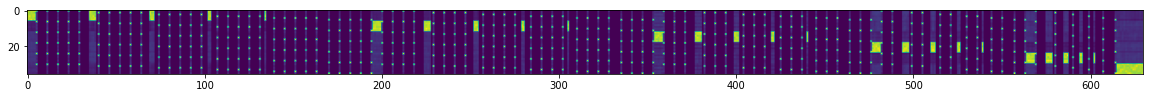

In [31]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

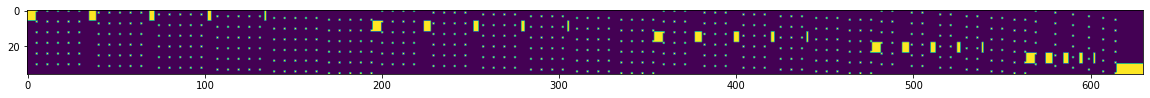

In [32]:
plt.figure(figsize = figsize)
plt.imshow(xy[figrange[0]:figrange[1], figrange[2]:figrange[3]])

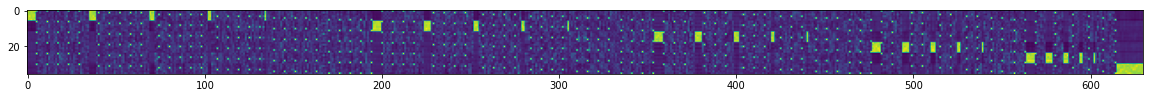

In [33]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_div_xyind_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

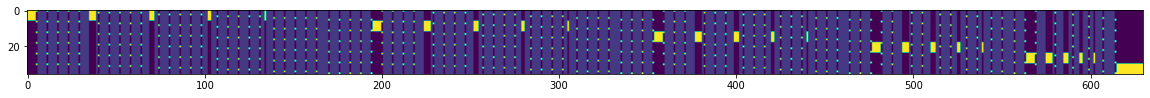

In [34]:
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

## Continue Training from checkpoint

In [ ]:
checkpoint_PATH = os.path.join(ckpt_dir_PATH, 'last.ckpt')
run_PATH = os.path.join(project_name, 'e0393wx7') # also from wandb interface

wandb.restore(checkpoint_PATH, run_path=run_PATH)
checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
trainmodule.load_state_dict(checkpoint['state_dict'])

In [ ]:
trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=12000, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    callbacks=[checkpoint_callback]
)

with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)
    
wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

## Test after reloading checkpoint

In [ ]:
checkpoint_PATH = os.path.join(ckpt_dir_PATH, 'last.ckpt')
run_PATH = os.path.join(project_name, 'e0393wx7') # also from wandb interface

wandb.restore(checkpoint_PATH, run_path=run_PATH)
checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
trainmodule.load_state_dict(checkpoint['state_dict'])

trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=300, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
#     callbacks=[checkpoint_callback]
)

In [ ]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )
res = trainer.test(model=trainmodule, test_dataloaders=test_loader)

In [ ]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(xy[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_div_xyind_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])